## How to generate text: using different decoding methods for language generation with Transformers

In [ ]:
!pip install python-mlb-statsapi==0.5.10
!pip install MLB-StatsAPI

In [2]:
import math
import random
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import json
import scipy.stats
import matplotlib.pyplot as plt
from peft import PeftModel
import collections
from pybaseball import playerid_reverse_lookup
from pybaseball import playerid_lookup
from unidecode import unidecode 
from decimal import Decimal
from pandas._libs.missing import NAType
import mlbstatsapi

from datetime import datetime
import statsapi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base model
base_path="../models/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="../models/phi-2-mlb/checkpoint-13100" 
      
# # Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
).to(device)


if torch.cuda.device_count() > 1: # If more than 1 GPU
    base_model.is_parallelizable = False
    base_model.model_parallel = False

tokenizer = AutoTokenizer.from_pretrained(base_path)

# # Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

base_model.config.eos_token_id = tokenizer.eos_token_id

# Load LoRA and merge
merged_model = PeftModel.from_pretrained(base_model, adapter_path).to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


bin e:\src\transformer-sketchbook\.venv\lib\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


In [4]:
def remove_last_newline(s):
    last_newline_index = s.rfind('\n')  # Find the index of the last newline character
    if last_newline_index != -1:  # Check if newline character exists
        s = s[:last_newline_index]  # Remove the newline character
    return s

def extract_between_quotes(s):
    first_quote_index = s.find('"')
    if first_quote_index != -1:
        second_quote_index = s.find('"', first_quote_index + 1)
        if second_quote_index != -1:
            return s[first_quote_index + 1:second_quote_index]
    # print(s)
    return None

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if obj is None:
            return ""
        if isinstance(obj, Decimal):
            return str(obj)
        if isinstance(obj, NAType):
            return ""
        # 👇️ otherwise use the default behavior
        return json.JSONEncoder.default(self, obj)
    
def calculate_american_odds(dec_odds):
    return (dec_odds/(1.0-dec_odds) - 1.0)*100.0 if dec_odds >= 2.0 else -100.0/(dec_odds/(1.0-dec_odds) - 1.0) 

def calculate_dec_odds(probs, num_events):
    return float((1.0-math.pow(1-probs, num_events))/(1.0-(1.0-math.pow(1-probs, num_events))))

def calculate_dec_odds_handy_capped(probs, num_events, handy_cap):
    handy_cap_prob = math.pow(probs, handy_cap+0.5)
    return float((1.0-math.pow(1.0-handy_cap_prob, num_events))/(1.0-(1.0-math.pow(1-handy_cap_prob, num_events))))

def get_player_name(id):
    name_data = playerid_reverse_lookup([id], key_type='mlbam')
    if not name_data.empty:
        if "name_first" in name_data and 'name_last' in name_data:
            if len(name_data['name_first']) > 0 and len(name_data['name_last']) > 0:
                return f"{unidecode(name_data['name_first'][0])} {unidecode(name_data['name_last'][0])}"
            else:
                return id

In [155]:
date = "2024-04-15"

In [156]:

schedule = statsapi.schedule(end_date=date)
games = {}
got_hit = []
for game in schedule:
    print(game)
    box_score = statsapi.boxscore_data(game['game_id'], timecode=None)
    for player in box_score['away']['players']:
        if 'hits' in box_score['away']['players'][player]['stats']['batting']:
            if box_score['away']['players'][player]['stats']['batting']['hits'] > 0:
                got_hit.append(box_score['away']['players'][player]['person']['id'])

mlb = mlbstatsapi.Mlb()
for g in range(int(len(schedule))):
    game = schedule[g]
    print(game)
    home_pitch_id = 0
    if '' != game['home_probable_pitcher']:
        player = game['home_probable_pitcher'].split(" ")
        data = playerid_lookup(player[1], player[0])
        for index, row in data.iterrows():
            home_pitch_id = row.key_mlbam

    away_pitch_id = 0
    if '' != game['away_probable_pitcher']:
        player = game['away_probable_pitcher'].split(" ")
        data = playerid_lookup(player[1], player[0])
        for index, row in data.iterrows():
            away_pitch_id = row.key_mlbam

    box_score = statsapi.boxscore_data(game['game_id'], timecode=None)
    lineup = mlb.get_team_roster(game['away_id'])
    away_roster = []
    away_roster_names = {}
    for person in box_score['awayBatters']:
        if person['personId'] != 0:
            away_roster.append(person['personId'])
            away_roster_names[str(person['personId'])] = unidecode(person['namefield'])
    
    lineup = mlb.get_team_roster(game['home_id'])
    home_roster = []
    home_roster_names = {}
    for person in box_score['homeBatters']:
        if person['personId'] != 0:
            home_roster.append(person['personId'])
            home_roster_names[str(person['personId'])] = unidecode(person['namefield'])
    games[str(game['game_id'])] = {
            'away_name':game['away_name'],
            'home_name':game['home_name'],
            'home_starting':home_pitch_id,
            'away_starting':away_pitch_id,
            "away_name":game['away_name'],
            "home_name":game['home_name'],
            "away_id":game['away_id'],
            "home_id":game['home_id'],
            'away_roster':away_roster,
            'home_roster':home_roster,
            "away_roster_names":away_roster_names,
            'home_roster_names':home_roster_names
        }

with open(f'../data/games_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(games, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

with open(f'../data/got_hit_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(got_hit, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

{'game_id': 746974, 'game_datetime': '2024-04-15T15:10:00Z', 'game_date': '2024-04-15', 'game_type': 'R', 'status': 'Final', 'away_name': 'Cleveland Guardians', 'home_name': 'Boston Red Sox', 'away_id': 114, 'home_id': 111, 'doubleheader': 'N', 'game_num': 1, 'home_probable_pitcher': 'Kutter Crawford', 'away_probable_pitcher': 'Xzavion Curry', 'home_pitcher_note': '', 'away_pitcher_note': '', 'away_score': 6, 'home_score': 0, 'current_inning': 9, 'inning_state': 'Bottom', 'venue_id': 3, 'venue_name': 'Fenway Park', 'national_broadcasts': ['MLBN (out-of-market only)'], 'series_status': 'CLE leads 1-0', 'winning_team': 'Cleveland Guardians', 'losing_team': 'Boston Red Sox', 'winning_pitcher': 'Tim Herrin', 'losing_pitcher': 'Brennan Bernardino', 'save_pitcher': None, 'summary': '2024-04-15 - Cleveland Guardians (6) @ Boston Red Sox (0) (Final)'}
{'game_id': 747053, 'game_datetime': '2024-04-15T22:35:00Z', 'game_date': '2024-04-15', 'game_type': 'R', 'status': 'Final', 'away_name': 'Minne

In [ ]:
with open(f'../data/players_data.json', 'r', encoding='utf-8') as f:
    players = json.load(f)

In [ ]:
def generate_sequences(inning, pitcher, batter, top_k, top_p, temperature, num_returns):
    input = {
                'pitcher': players[pitcher],
                'batter': players[batter],
                "at_bat_number":random.randint(0, 45),
                "inning_topbot":inning,
                "inning":random.randint(1, 10),
                "outs_when_up":row.outs_when_up,
                "on_1b":False if random.randint(0, 10000) < 10000/2 else True,
                "on_2b":False if random.randint(0, 10000) < 10000/2 else True,
                "on_3b":False if random.randint(0, 10000) < 10000/2 else True,
                "home_score":row.home_score,
                "away_score":row.away_score,
                "pitch_number":row.pitch_number,
            }
    
    input_string = json.dumps(input, ensure_ascii=True, allow_nan=True, cls=MyEncoder)
    input_string = f"Instruct: {input_string} Output: "
    input_tokens = tokenizer(input_string, return_tensors="pt").to(device)
    output_tokens = merged_model.generate(**input_tokens, max_new_tokens=15, do_sample=True, top_k=top_k, top_p=top_p, temperature=temperature, output_scores=True, return_dict_in_generate=True, num_return_sequences=num_returns)
    gen_sequences = output_tokens.sequences[:, input_tokens['input_ids'].shape[-1]:]
    return output_tokens, gen_sequences, input_tokens

In [135]:
def generate_samples(inning, game, team_name, pitcher, pitcher_name, batter, batter_name, top_k, top_p, temperature, num_returns, probs_for_graph, out):
    output_pick = {}
    for i in range(0, 5):
        sequences, gen_sequences, input_tokens = generate_sequences(inning, pitcher, batter, top_k, top_p, temperature, num_returns)
        

        keys = []

        for i in sequences:
            output_decode =tokenizer.decode(
                i[len(input_tokens[0]):],
                skip_special_tokens=True
                )
            if "single" in output_decode:
                keys.append("single")
            elif "double_play" in output_decode:
                keys.append("double_play")
            elif "triple_play" in output_decode:
                keys.append("triple_play")
            elif "triple" in output_decode:
                keys.append("triple")
            elif "double" in output_decode:
                keys.append("double")
            elif "home_run" in output_decode:
                keys.append("home_run")
            elif "field_out" in output_decode:
                keys.append("field_out")
            elif "fielders_choice_out" in output_decode:
                keys.append("fielders_choice_out")
            elif "fielders_choice" in output_decode:
                keys.append("fielders_choice")
            elif "field_out" in output_decode:
                keys.append("field_out")
            elif "sac_bunt" in output_decode:
                keys.append("sac_bunt")
            elif "force_out" in output_decode:
                keys.append("force_out")
            elif "strikeout" in output_decode:
                keys.append("strikeout")
            elif "field_error" in output_decode:
                keys.append("field_error")
            elif "hit_by_pitch" in output_decode:
                keys.append("hit_by_pitch")
            elif "walk" in output_decode:
                keys.append("walk")
            elif "caught_stealing" in output_decode:
                keys.append("caught_stealing_2b")
            elif "sac_fly" in output_decode:
                keys.append("sac_fly")
            elif 'foul_tip' in output_decode:
                keys.append("foul_tip")
            elif 'bunt' in output_decode:
                keys.append('bunt')
            else:
                keys.append("+")

            probs = torch.stack(output_tokens.scores, dim=1).softmax(-1)
            gen_probs = torch.gather(probs, 2, gen_sequences[:, :, None]).squeeze(-1)
            unique_prob_per_sequence = gen_probs.prod(-1).cpu().numpy()
            count = 0
            for k in keys:
                if k is not None and k != "+":
                    if k not in probs_for_graph:
                        probs_for_graph[k] = float(unique_prob_per_sequence[count])
                    else:
                        probs_for_graph[k] += float(unique_prob_per_sequence[count])
                        probs_for_graph[k] /= 2
                count+=1

    for k in probs_for_graph:
        if 'single' in k or ('double' == k) or ('triple' == k) or 'home_run' in k:
            probs_for_graph['hit'] += float(probs_for_graph[k])
            probs_for_graph['obp'] += float(probs_for_graph[k])
        elif 'walk' in k or 'hit_by_pitch' in k or 'field_error' in k or 'fielders_choice' in k:
            probs_for_graph['obp'] += float(probs_for_graph[k])
        else:
            probs_for_graph['out'] +=float( probs_for_graph[k])

        od = collections.OrderedDict(sorted(probs_for_graph.items()))

        hit_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['hit'], 3))
        hit_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['hit'], 4))
        single_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['single'], 3))
        single_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['single'], 4))
        double_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['double'], 3))
        double_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['double'], 4))
        triple_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['triple'], 3))
        triple_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['triple'], 4))
        home_run_3 = calculate_american_odds(calculate_dec_odds(probs_for_graph['home_run'], 3))
        home_run_4 = calculate_american_odds(calculate_dec_odds(probs_for_graph['home_run'], 4))
        

        out[game][batter] = {
                                    "name":batter_name,
                                    "team":team_name,
                                    "raw":dict(sorted(od.items(), key=lambda item: item[1], reverse=True)),
                                    "odds_dec":{
                                        "hit_3":float(calculate_dec_odds(probs_for_graph['hit'], 3)),
                                        "hit_4":float(calculate_dec_odds(probs_for_graph['hit'], 4)),
                                        "single_3":float(calculate_dec_odds(probs_for_graph['single'], 3)),
                                        "single_4":float(calculate_dec_odds(probs_for_graph['single'], 4)),
                                        "double_3":float(calculate_dec_odds(probs_for_graph['double'], 3)),
                                        "double_4":float(calculate_dec_odds(probs_for_graph['double'], 4)),
                                        "triple_3":float(calculate_dec_odds(probs_for_graph['triple'], 3)),
                                        "triple_4":float(calculate_dec_odds(probs_for_graph['triple'], 4)),
                                        "home_run_3":float(calculate_dec_odds(probs_for_graph['home_run'], 3)),
                                        "home_run_4":float(calculate_dec_odds(probs_for_graph['home_run'], 4)),
                                    },                        
                                    "odds_moneyline":{
                                        "hit_3": hit_3,
                                        "hit_4": hit_4,
                                        "single_3":single_3,
                                        "single_4":single_4,
                                        "double_3":double_3,
                                        "double_4":double_4,
                                        "triple_3":triple_3,
                                        "triple_4":triple_4,
                                        "home_run_3":home_run_3,
                                        "home_run_4":home_run_4 
                                    }
                                }
        if float(hit_3) < 0.0 or float(hit_4) < 0.0 or float(single_3) < 0.0 or float(single_4) < 0.0 or float(double_3) < 0.0 or float(double_4) < 0.0 or float(triple_3) < 0.0 or float(triple_4) < 0.0 or float(home_run_3) < 0.0 or float(home_run_4) < 0.0:
            output_pick = out[game][batter]

    return output_pick, out

In [157]:
obp_data= []
output_data = {}
num_returns = 15          
output_pick = {}
top_k = 80
top_p = 1.0
temperature = 1.0
for game in games:
    output_pick[game] = {
        games[game]["home_name"]:{},
        games[game]["away_name"]:{}
    }
    output_data[game] = {

    }
    home_starter = get_player_name(games[game]["home_starting"])
    away_starting = get_player_name(games[game]["away_starting"])
    for player in games[game]['away_roster']: 
        player_name = get_player_name(player)

        probs_for_graph = {
            'out':0,
            'hit':0,
            "obp":0,
            "single":0,
            "double":0,
            "triple":0,
            "home_run":0
        }
    
        output_pick[game][games[game]["away_name"]][player], output_data = (generate_samples('top', game, games[game]["away_name"], games[game]["home_starting"], home_starter, player, player_name, top_k, top_p, temperature, num_returns, probs_for_graph, output_data))
        print(output_data[game][player])
        if player in got_hit:
            print("got hit")
                         
    for player in games[game]['home_roster']: 
        player_name = get_player_name(player)

        probs_for_graph = {
            'out':0,
            'hit':0,
            "obp":0,
            "single":0,
            "double":0,
            "triple":0,
            "home_run":0
        }

        output_pick[game][games[game]["home_name"]][player], output_data = generate_samples('bot', game, games[game]["home_name"], games[game]["away_starting"], away_starting, player, player_name, top_k, top_p, temperature, num_returns, probs_for_graph, output_data)
        print(output_data[game][player])
        if player in got_hit:
            print("got hit")


with open(f'../data/odds-{date}.json', 'w', encoding='utf-8') as f:
    json.dump(output_data, f, ensure_ascii=True, indent=4, allow_nan=True, cls=MyEncoder)

with open(f'../data/picks-{date}.json', 'w', encoding='utf-8') as f:
    json.dump(output_pick, f, ensure_ascii=True, indent=4, allow_nan=True, cls=MyEncoder)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'steven kwan', 'team': 'Cleveland Guardians', 'raw': {'out': 0.5785632542070971, 'obp': 0.34462591791145136, 'strikeout': 0.24406804144382477, 'field_out': 0.2433290034532547, 'walk': 0.2198789264075458, 'hit': 0.12474699150390556, 'single': 0.11205879241475081, 'force_out': 0.050334215044699704, 'double_play': 0.04083199426531792, 'home_run': 0.01268819908915475, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.4914172547548075, 'hit_4': 0.7039841511855398, 'single_3': 0.4283918593288064, 'single_4': 0.6086558965016498, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0390513622194606, 'home_run_4': 0.0524044797812433}, 'odds_moneyline': {'hit_3': 2962.8209315082954, 'hit_4': -72.55854121362847, 'single_3': 399.12231717890364, 'single_4': -180.08415378193877, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.23597761428391, 'home_run_4': 105.8539995837795}}
got hit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'andres gimenez', 'team': 'Cleveland Guardians', 'raw': {'out': 0.524908540449102, 'obp': 0.4661825537849608, 'walk': 0.3483070433139801, 'strikeout': 0.27038428172201423, 'field_out': 0.20628224781466997, 'hit': 0.1057340079795494, 'single': 0.08808614797544573, 'force_out': 0.04735901934327558, 'home_run': 0.017647860004103677, 'hit_by_pitch': 0.01214150249143131, 'double_play': 0.0008829915691421775, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.398298378600171, 'hit_4': 0.5636269198171564, 'single_3': 0.3186773960604537, 'single_4': 0.44605479249255553, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05486871731469242, 'home_run_4': 0.07381933052957873}, 'odds_moneyline': {'hit_3': 295.81712322672996, 'hit_4': -342.9154526392614, 'single_3': 187.8758050945215, 'single_4': 513.4331974077584, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 106.16320616512171, 'home_run_4': 108.66056766738245}}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jose ramirez', 'team': 'Cleveland Guardians', 'raw': {'out': 0.750100071994133, 'obp': 0.4061187345604736, 'field_out': 0.33769908547401417, 'strikeout': 0.3052046298980713, 'walk': 0.27275371551089833, 'hit': 0.13336501904957526, 'single': 0.09028197032587373, 'force_out': 0.054072208223409746, 'double_play': 0.05312414839863777, 'double': 0.043083048723701535, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.536354210988865, 'hit_4': 0.772781210959163, 'single_3': 0.32824929418799753, 'single_4': 0.4600670217163828, 'double_3': 0.1412407122988233, 'double_4': 0.1926225267267771, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -637.6782446924037, 'hit_4': -41.64854101238907, 'single_3': 195.55980938654707, 'single_4': 676.0489719159375, 'double_3': 119.68460708067684, 'double_4': 131.33322111662326, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'josh naylor', 'team': 'Cleveland Guardians', 'raw': {'out': 0.5535316600586563, 'obp': 0.34543928470060337, 'strikeout': 0.2933378771213506, 'field_out': 0.22692623176015303, 'walk': 0.18162742257118228, 'hit': 0.15745615180179584, 'single': 0.11017569722406506, 'double': 0.03514530396819282, 'force_out': 0.03326755117715265, 'home_run': 0.012135150609537959, 'field_error': 0.006355710327625275, 'triple': 0}, 'odds_dec': {'hit_3': 0.6719468373478961, 'hit_4': 0.9844033529214958, 'single_3': 0.41934251256625416, 'single_4': 0.5950817573069326, 'double_3': 0.11330524518066035, 'double_4': 0.15385793297103814, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03730722446967009, 'home_run_4': 0.05004973616554465}, 'odds_moneyline': {'hit_3': -95.39377627177915, 'hit_4': -1.6098822380603768, 'single_3': 359.9526255455907, 'single_4': -212.9316149395275, 'double_3': 114.65047608851012, 'double_4': 122.22467992573766, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.031533064

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bo naylor', 'team': 'Cleveland Guardians', 'raw': {'out': 0.5123069787960413, 'obp': 0.423206886263435, 'walk': 0.24788430333148428, 'strikeout': 0.21567703783506403, 'field_out': 0.21348929812489933, 'hit': 0.1570374071465284, 'single': 0.11709953915706131, 'force_out': 0.07754114315597604, 'double': 0.025953034095437033, 'home_run': 0.013984833894030047, 'hit_by_pitch': 0.009297892451286316, 'field_error': 0.00898728333413601, 'double_play': 0.0055994996801018715, 'triple': 0}, 'odds_dec': {'hit_3': 0.6694564383228786, 'hit_4': 0.9804632524341121, 'single_3': 0.45299717354131597, 'single_4': 0.6457089309411893, 'double_3': 0.08208233277035318, 'double_4': 0.110913919602903, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04315589126987983, 'home_run_4': 0.05795116254608279}, 'odds_moneyline': {'hit_3': -97.53054087189976, 'hit_4': -2.033115692710236, 'single_3': 581.8829075518526, 'single_4': -121.57493256257875, 'double_3': 109.82039516473094, 'double_4': 114.25313384247

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'tyler freeman', 'team': 'Cleveland Guardians', 'raw': {'out': 0.6226063128204962, 'obp': 0.3357241448609425, 'field_out': 0.24254351854207207, 'strikeout': 0.2335588558640562, 'hit': 0.20741766635975709, 'single': 0.15159732102764864, 'walk': 0.11805398879282142, 'force_out': 0.07438483598066481, 'double_play': 0.05573558676280754, 'double': 0.04035302048498579, 'sac_fly': 0.016383515670895576, 'home_run': 0.013103995006531477, 'hit_by_pitch': 0.01025248970836401, 'triple': 0.0023633298405911773}, 'odds_dec': {'hit_3': 1.008476878236318, 'hit_4': 1.5340924128495337, 'single_3': 0.6375475001990022, 'single_4': 0.9301536178345426, 'double_3': 0.13152850213372944, 'double_4': 0.17910911646445313, 'triple_3': 0.0071236339585993465, 'triple_4': 0.009509437737162035, 'home_run_3': 0.04036522516139391, 'home_run_4': 0.05417918392351714}, 'odds_moneyline': {'hit_3': 0.833555919565172, 'hit_4': 25.82421098022538, 'single_3': -131.75539332834313, 'single_4': -8.118771907240307, 'double

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'will brennan', 'team': 'Cleveland Guardians', 'raw': {'out': 0.6130575799800069, 'obp': 0.36023266244299457, 'strikeout': 0.30234846472740173, 'field_out': 0.23942703008719762, 'walk': 0.19170462154147389, 'hit': 0.16291925779799504, 'single': 0.13176267944939474, 'force_out': 0.05492724849271745, 'double': 0.024775299491011538, 'double_play': 0.01635483667269, 'home_run': 0.006381278857588768, 'field_error': 0.005608783103525639, 'triple': 0}, 'odds_dec': {'hit_3': 0.7048962200245958, 'hit_4': 1.036716572334152, 'single_3': 0.5278638337834038, 'single_4': 0.7597306607535447, 'double_3': 0.07816672013777991, 'double_4': 0.10555723165652389, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.019390784491371903, 'home_run_4': 0.025937578268784324}, 'odds_moneyline': {'hit_3': -72.01298782866266, 'hit_4': 3.4204805875914737, 'single_3': -847.2203966738572, 'single_4': -46.25355715597321, 'double_3': 109.26512011609312, 'double_4': 113.38055101121867, 'triple_3': 100.0, 'triple_4'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'estevan florial', 'team': 'Cleveland Guardians', 'raw': {'out': 0.564304122512722, 'obp': 0.40128963438840515, 'strikeout': 0.2478619981749255, 'walk': 0.22330473088818792, 'field_out': 0.21803391197139882, 'hit': 0.16778718207849863, 'single': 0.11488287005400366, 'force_out': 0.049828627795624136, 'double_play': 0.03773981609205575, 'double': 0.036742923315998155, 'home_run': 0.016161388708496816, 'sac_fly': 0.010839768478717815, 'hit_by_pitch': 0.010197721421718597, 'triple': 0}, 'odds_dec': {'hit_3': 0.7349892897002238, 'hit_4': 1.0847903953624, 'single_3': 0.44210792139758776, 'single_4': 0.6292848399460702, 'double_3': 0.11885388733760464, 'double_4': 0.1615319673427601, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05009456801479103, 'home_run_4': 0.06734433469358606}, 'odds_moneyline': {'hit_3': -56.387827427762936, 'hit_4': 7.249639873946174, 'single_3': 481.8380096816616, 'single_4': -143.37147348775372, 'double_3': 115.59164364912215, 'double_4': 123.8622191399

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gabriel arias', 'team': 'Cleveland Guardians', 'raw': {'out': 0.5622113997976718, 'obp': 0.46638643263218404, 'walk': 0.34106552599713513, 'field_out': 0.25932699444790996, 'strikeout': 0.20615065097634433, 'hit': 0.12532090663504888, 'single': 0.08625911183367377, 'force_out': 0.06802606383644161, 'double': 0.03906179480137511, 'double_play': 0.02870769053697586, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.49435493332569835, 'hit_4': 0.7084607882609968, 'single_3': 0.3107830669250465, 'single_4': 0.4345238173105015, 'double_3': 0.12697327800747518, 'double_4': 0.17278433921204217, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 4478.645655118452, 'hit_4': -69.92663084771382, 'single_3': 182.12348172928515, 'single_4': 431.81822722554136, 'double_3': 117.0193273727478, 'double_4': 126.4022111282763, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brayan rocchio', 'team': 'Cleveland Guardians', 'raw': {'out': 0.6956921116240993, 'obp': 0.32951392504325694, 'field_out': 0.2858493626033736, 'strikeout': 0.22356100845944307, 'hit': 0.22204765090206846, 'single': 0.137931797143365, 'walk': 0.10746627414118848, 'force_out': 0.10741939000034328, 'double_play': 0.0650987576332227, 'double': 0.0601919465661922, 'home_run': 0.02392390719251125, 'sac_fly': 0.012881308794021606, 'caught_stealing_2b': 0.000882284133695066, 'triple': 0}, 'odds_dec': {'hit_3': 1.123933966922208, 'hit_4': 1.7301594620608818, 'single_3': 0.5609001427172668, 'single_4': 0.8106457674055401, 'double_3': 0.2047099940418919, 'double_4': 0.2818681321576285, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.07534785469294789, 'home_run_4': 0.1017049414661143}, 'odds_moneyline': {'hit_3': 9.931657314119269, 'hit_4': 29.67743144606831, 'single_3': -360.5080691857199, 'single_4': -30.477516911933787, 'double_3': 134.6625334267042, 'double_4': 164.60957194051875

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jarren duran', 'team': 'Boston Red Sox', 'raw': {'out': 0.7025041590385879, 'field_out': 0.32820823766945184, 'obp': 0.3192949189232714, 'strikeout': 0.24462746027797616, 'hit': 0.2325306591234501, 'single': 0.18229918181508803, 'force_out': 0.06628614272254982, 'walk': 0.06315974175231531, 'double_play': 0.05219793332224715, 'double': 0.035269572851708286, 'home_run': 0.014961904456653796, 'hit_by_pitch': 0.014051828021621304, 'sac_fly': 0.011184385046362877, 'field_error': 0.009552690025884658, 'triple': 0}, 'odds_dec': {'hit_3': 1.212161830349072, 'hit_4': 1.8824106873409368, 'single_3': 0.8290126242703983, 'single_4': 1.2367748491805863, 'double_3': 0.1137355219224622, 'double_4': 0.15445257097842774, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.046263126143038916, 'home_run_4': 0.06215498758545067}, 'odds_moneyline': {'hit_3': 14.895619317668226, 'hit_4': 31.915649069461814, 'single_3': -25.984926278858534, 'single_4': 16.068331420644892, 'double_3': 114.72249305560

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'rafael devers', 'team': 'Boston Red Sox', 'raw': {'out': 0.5795682766620268, 'obp': 0.4623275083535539, 'walk': 0.2853155732154846, 'strikeout': 0.27254475842744014, 'field_out': 0.21534448862075806, 'hit': 0.1696173875638472, 'single': 0.13593669235560418, 'force_out': 0.08244250701284254, 'double': 0.03158439229177257, 'double_play': 0.009236522600986063, 'field_error': 0.007394547574222088, 'triple': 0.0020963029164704494, 'home_run': 0}, 'odds_dec': {'hit_3': 0.7464866069249799, 'hit_4': 1.103231186165119, 'single_3': 0.5501128277480948, 'single_4': 0.7939806192835606, 'double_3': 0.1010693138608099, 'double_4': 0.13698014065108857, 'triple_3': 0.006315368077178581, 'triple_4': 0.008429341446707667, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -51.42538903790801, 'hit_4': 8.556519335595333, 'single_3': -448.874262806901, 'single_4': -35.03961948554887, 'double_3': 112.6675281411601, 'double_4': 118.86675578806724, 'triple_3': 100.6396156239036, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': "tyler o'neill", 'team': 'Boston Red Sox', 'raw': {'out': 0.5979056625915868, 'obp': 0.45692624915180696, 'strikeout': 0.27761873607926235, 'walk': 0.25970511311072275, 'field_out': 0.21203730534762227, 'hit': 0.17758994721258609, 'single': 0.13279227912425035, 'force_out': 0.06271862773983772, 'double_play': 0.0345234926124531, 'double': 0.031785312298211466, 'hit_by_pitch': 0.01398969255387783, 'home_run': 0.013012355790124275, 'sac_fly': 0.011007500812411308, 'field_error': 0.005641496274620295, 'triple': 0}, 'odds_dec': {'hit_3': 0.7977726498278425, 'hit_4': 1.1859808786804211, 'single_3': 0.5333122049284645, 'single_4': 0.7681025756782349, 'double_3': 0.10175492450394835, 'double_4': 0.13792420059143992, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0400754665116158, 'home_run_4': 0.05378772734712309}, 'odds_moneyline': {'hit_3': -33.95666967551846, 'hit_4': 13.555835480296551, 'single_3': -700.4756906270728, 'single_4': -43.247891918815114, 'double_3': 112.7754152863

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'david hamilton', 'team': 'Boston Red Sox', 'raw': {'out': 0.826793133186233, 'obp': 0.5569953267792094, 'field_out': 0.3851314783096311, 'hit': 0.3212920985512526, 'strikeout': 0.25304053110730834, 'single': 0.24179372748403694, 'walk': 0.22382187090713962, 'force_out': 0.07845365584944375, 'double_play': 0.06923726941432903, 'double': 0.06560315807985129, 'sac_fly': 0.027543889358639717, 'sac_bunt': 0.013386309146881104, 'hit_by_pitch': 0.011881357320817187, 'home_run': 0.010453687154949876, 'triple': 0.003441525832414527}, 'odds_dec': {'hit_3': 2.1985363032108345, 'hit_4': 3.7126846414832433, 'single_3': 1.2942348955629914, 'single_4': 2.025871690496585, 'double_3': 0.22576132423627374, 'double_4': 0.3118209193830134, 'triple_3': 0.010396051829763503, 'triple_4': 0.013885364502806943, 'home_run_3': 0.03202834444958314, 'home_run_4': 0.04293081693406825}, 'odds_moneyline': {'hit_3': -283.43510307706464, 'hit_4': -236.8638501028715, 'single_3': 18.52316595548372, 'single_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'triston casas', 'team': 'Boston Red Sox', 'raw': {'out': 0.5558540580280875, 'obp': 0.49219113550452515, 'hit': 0.2444630643176408, 'field_out': 0.23790334165096025, 'walk': 0.22323506139218807, 'strikeout': 0.21258075535292567, 'single': 0.20484535391369557, 'force_out': 0.06906293169838715, 'sac_fly': 0.032447341829538345, 'double': 0.023551957681775093, 'hit_by_pitch': 0.01775897574816554, 'home_run': 0.016065752722170146, 'field_error': 0.006734034046530724, 'double_play': 0.0038596874962761036, 'triple': 0}, 'odds_dec': {'hit_3': 1.3186377308123831, 'hit_4': 2.06886086081062, 'single_3': 0.9890476962473618, 'single_4': 1.5014601952429196, 'double_3': 0.0741194551728126, 'double_4': 0.10002725042358834, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04978839795586129, 'home_run_4': 0.0669294222253415}, 'odds_moneyline': {'hit_3': 19.461461328943383, 'hit_4': -293.5575467925361, 'single_3': -1.1197582400120865, 'single_4': 25.036451654540436, 'double_3': 108.70190668170

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'masataka yoshida', 'team': 'Boston Red Sox', 'raw': {'out': 0.6069440465853617, 'obp': 0.344761502166098, 'field_out': 0.2426627244840065, 'strikeout': 0.21702338758735196, 'hit': 0.18380320508108106, 'walk': 0.1543990522623062, 'single': 0.13350815439313607, 'force_out': 0.08084643154870719, 'double_play': 0.04909722509948855, 'double': 0.03621922446214605, 'sac_fly': 0.017314277865807526, 'home_run': 0.014075826225798949, 'field_error': 0.0065592448227107525, 'triple': 0}, 'odds_dec': {'hit_3': 0.8391423494995243, 'hit_4': 1.2533074877881933, 'single_3': 0.537115705458292, 'single_4': 0.7739528805164274, 'double_3': 0.11703099094331978, 'double_4': 0.1590094130275031, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04344474090953355, 'home_run_4': 0.05834177583367177}, 'odds_moneyline': {'hit_3': -23.71535886595333, 'hit_4': 16.81302070499368, 'single_3': -623.5693068825873, 'single_4': -41.256569205889, 'double_3': 115.27943360633641, 'double_4': 123.31580681438696, 'tri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'wilyer abreu', 'team': 'Boston Red Sox', 'raw': {'out': 0.6951411384398051, 'obp': 0.36050934143660845, 'strikeout': 0.2621931135654309, 'hit': 0.2330273021132438, 'field_out': 0.22775909630773344, 'single': 0.14233293830586913, 'walk': 0.1108105065583338, 'force_out': 0.08355591660233852, 'double': 0.075694352370758, 'double_play': 0.06222423727028185, 'sac_bunt': 0.03723491355776787, 'sac_fly': 0.022173861136252526, 'hit_by_pitch': 0.01667153276503086, 'home_run': 0.015000011436616667, 'triple': 0}, 'odds_dec': {'hit_3': 1.2164619817410163, 'hit_4': 1.8898838092256032, 'single_3': 0.5850530619725783, 'single_4': 0.8480983271546628, 'double_3': 0.26634832446060086, 'double_4': 0.37005364806399976, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04638456209509807, 'home_run_4': 0.062319364715165006}, 'odds_moneyline': {'hit_3': 15.106313192991031, 'hit_4': 32.01288493753361, 'single_3': -243.9341561631275, 'single_4': -21.81878811182078, 'double_3': 156.99687876102738, 'dou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'enmanuel valdez', 'team': 'Boston Red Sox', 'raw': {'out': 0.6064897369437283, 'obp': 0.42305697574177836, 'walk': 0.3052234649159566, 'strikeout': 0.2685295641422272, 'field_out': 0.23134248271440971, 'hit': 0.1178335108258218, 'force_out': 0.0910668579376761, 'single': 0.08746798694361155, 'double': 0.030365523882210255, 'sac_fly': 0.012439497746527195, 'double_play': 0.003111334402888133, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.4566269180082575, 'hit_4': 0.6511927576979811, 'single_3': 0.31599934346742825, 'single_4': 0.44214046700639764, 'double_3': 0.09692226982550745, 'double_4': 0.13127399741122125, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 626.3943637844222, 'hit_4': -115.3518355021963, 'single_3': 185.8690804213218, 'single_4': 482.0809157371578, 'double_3': 112.02277657259181, 'double_4': 117.80102250581233, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'reese mcguire', 'team': 'Boston Red Sox', 'raw': {'out': 0.6281028374433788, 'field_out': 0.3244200050830841, 'obp': 0.32271262243663845, 'strikeout': 0.22903904918348417, 'hit': 0.18718972598799596, 'single': 0.13971284768898515, 'walk': 0.12332164498654055, 'force_out': 0.07464378317681053, 'double': 0.03699735618876587, 'hit_by_pitch': 0.012201251462101936, 'home_run': 0.010479522110244943, 'triple': 0}, 'odds_dec': {'hit_3': 0.8622262598664325, 'hit_4': 1.2910958675196693, 'single_3': 0.5706148113485764, 'single_4': 0.8256866990625018, 'double_3': 0.1197409516570559, 'double_4': 0.16275999744456077, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0321091808835762, 'home_run_4': 0.04303973888912892}, 'odds_moneyline': {'hit_3': -19.017635577328132, 'hit_4': 18.39826748383512, 'single_3': -304.03337518799447, 'single_4': -26.760887294332846, 'double_3': 115.74465514743848, 'double_4': 124.13118197889418, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.431268532284

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ceddanne rafaela', 'team': 'Boston Red Sox', 'raw': {'out': 0.6352485694186859, 'obp': 0.3937796648134335, 'strikeout': 0.2900710701855266, 'field_out': 0.24758756014989558, 'walk': 0.22621783614158636, 'hit': 0.15449672243640264, 'single': 0.10687631611591875, 'force_out': 0.05637205683888169, 'double_play': 0.037168331968132406, 'double': 0.033157627117812005, 'home_run': 0.014462779202671892, 'hit_by_pitch': 0.013065106235444546, 'sac_bunt': 0.004049550276249647, 'triple': 0}, 'odds_dec': {'hit_3': 0.6544517788680552, 'hit_4': 0.9567656598984737, 'single_3': 0.4036705284521093, 'single_4': 0.5716418159999125, 'double_3': 0.10645300674598313, 'double_4': 0.1443985470430008, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04467429142699871, 'home_run_4': 0.06000490837050988}, 'odds_moneyline': {'hit_3': -111.86281688187589, 'hit_4': -4.732660956948478, 'single_3': 309.52597474357714, 'single_4': -298.9582117799826, 'double_3': 113.5248151517794, 'double_4': 120.30342478106

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'manuel margot', 'team': 'Minnesota Twins', 'raw': {'out': 0.5025366109670166, 'obp': 0.3712908039060865, 'walk': 0.23791828751554056, 'field_out': 0.2026713993865742, 'strikeout': 0.17799355391089822, 'hit': 0.1333725163905459, 'single': 0.09923721432483176, 'force_out': 0.07577686011791229, 'double_play': 0.04609479755163193, 'double': 0.03413530206571413, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5363940851143878, 'hit_4': 0.7728425582758974, 'single_3': 0.36826019882450794, 'single_4': 0.5190016956561169, 'double_3': 0.10981635588636032, 'double_4': 0.14903915451092356, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -636.924809936125, 'hit_4': -41.627934285530664, 'single_3': 239.76801070693304, 'single_4': -1265.6720564541934, 'double_3': 114.07239354379199, 'double_4': 121.23301736169917, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alex kirilloff', 'team': 'Minnesota Twins', 'raw': {'out': 0.5154288430856846, 'obp': 0.40116885522226653, 'field_out': 0.27778062457218766, 'walk': 0.2508506178855896, 'strikeout': 0.22012916207299132, 'hit': 0.1277163392408056, 'single': 0.1277163392408056, 'hit_by_pitch': 0.012483324191833844, 'field_error': 0.010118573904037476, 'sac_fly': 0.009630595333874226, 'double_play': 0.00788846110663144, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5066999969592171, 'hit_4': 0.7273050783134659, 'single_3': 0.5066999969592171, 'single_4': 0.7273050783134659, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -3681.3449770462853, 'hit_4': -59.98434432478299, 'single_3': -3681.3449770462853, 'single_4': -59.98434432478299, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ryan jeffers', 'team': 'Minnesota Twins', 'raw': {'out': 0.5888860195215906, 'obp': 0.424370911270957, 'walk': 0.26041436195373535, 'field_out': 0.25252306562561067, 'strikeout': 0.22919210697824194, 'hit': 0.15253900393901348, 'single': 0.09582018527669504, 'double_play': 0.055828091198691254, 'force_out': 0.05134275571904666, 'double': 0.03957484867351013, 'home_run': 0.014728903163756968, 'hit_by_pitch': 0.01141754537820816, 'triple': 0.0024150668250513263}, 'odds_dec': {'hit_3': 0.6430124052643278, 'hit_4': 0.9387469310104868, 'single_3': 0.3528061772116191, 'single_4': 0.49616940699522455, 'double_3': 0.12878031188770414, 'double_4': 0.1752923279119574, 'triple_3': 0.007280337133707049, 'triple_4': 0.009718875693021356, 'home_run_3': 0.045521026787562244, 'home_run_4': 0.06115061138481063}, 'odds_moneyline': {'hit_3': -124.81001003928895, 'hit_4': -6.980455549676445, 'single_3': 219.84408398674623, 'single_4': 6576.4046503591535, 'double_3': 117.34556598312041, 'double_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'byron buxton', 'team': 'Minnesota Twins', 'raw': {'out': 0.6530443091181146, 'field_out': 0.39746785163879395, 'obp': 0.34370645411903444, 'hit': 0.19138430577133717, 'walk': 0.15232214834769725, 'single': 0.15076842903689924, 'strikeout': 0.15066594625385998, 'force_out': 0.04383579129080317, 'double_play': 0.041770409022382105, 'double': 0.024788210122852632, 'home_run': 0.0158276666115853, 'sac_fly': 0.015351932970816051, 'sac_bunt': 0.003952377941459417, 'triple': 0}, 'odds_dec': {'hit_3': 0.8913569576718426, 'hit_4': 1.339005996508644, 'single_3': 0.6327571969033371, 'single_4': 0.9226289421290026, 'double_3': 0.0782095415987606, 'double_4': 0.10561577781436422, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04902670337632803, 'home_run_4': 0.06589737161643815}, 'odds_moneyline': {'hit_3': -13.880300349643433, 'hit_4': 20.202835135824404, 'single_3': -138.31370790543994, 'single_4': -9.153544653288414, 'double_3': 109.27113689285518, 'double_4': 113.38995982509807, 't

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kyle farmer', 'team': 'Minnesota Twins', 'raw': {'out': 0.5972491920364202, 'obp': 0.41790138558462825, 'strikeout': 0.2510410845279032, 'field_out': 0.24544229346975213, 'hit': 0.20589978594727043, 'walk': 0.19768533109926206, 'single': 0.14919662486032692, 'force_out': 0.056692419049795065, 'double_play': 0.044073394988969936, 'double': 0.04257214673884846, 'hit_by_pitch': 0.014316268538095756, 'home_run': 0.01413101434809505, 'triple': 0}, 'odds_dec': {'hit_3': 0.9969815880398966, 'hit_4': 1.5147727612969681, 'single_3': 0.6237246647166765, 'single_4': 0.9084605352560055, 'double_3': 0.13941472280442, 'double_4': 0.19007893798304726, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04361998421408419, 'home_run_4': 0.058578776087566495}, 'odds_moneyline': {'hit_3': -0.30367442504340103, 'hit_4': 25.363942595337484, 'single_3': -152.06156999696694, 'single_4': -11.205423393795138, 'double_3': 119.33172700348523, 'double_4': 130.66570189615734, 'triple_3': 100.0, 'triple_4':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'willi castro', 'team': 'Minnesota Twins', 'raw': {'out': 0.6007016112143908, 'obp': 0.3794602741427161, 'strikeout': 0.30395908875209443, 'walk': 0.23756641149553182, 'field_out': 0.22941294312477173, 'hit': 0.13368909702933687, 'single': 0.08740947470508942, 'force_out': 0.05965781482564125, 'double': 0.028782013639640197, 'home_run': 0.01642123599503975, 'field_error': 0.008204765617847443, 'double_play': 0.007671764511883339, 'triple': 0.0010763726895675063}, 'odds_dec': {'hit_3': 0.5380790589013277, 'hit_4': 0.775435416577475, 'single_3': 0.3157462273271524, 'single_4': 0.4417706417694387, 'double_3': 0.09156562333649548, 'double_4': 0.12391413530873584, 'triple_3': 0.003236082028487505, 'triple_4': 0.004317101528238137, 'home_run_3': 0.050927047305410755, 'home_run_4': 0.06847268949384408}, 'odds_moneyline': {'hit_3': -606.5288303154033, 'hit_4': -40.76537908830602, 'single_3': 185.68243210080064, 'single_4': 479.33669131319584, 'double_3': 111.20934335700314, 'double_4'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jose miranda', 'team': 'Minnesota Twins', 'raw': {'out': 0.5748422783766864, 'obp': 0.39231587771669624, 'field_out': 0.3325192630290985, 'hit': 0.30953409343257454, 'single': 0.20974631657829174, 'strikeout': 0.11143204655669625, 'force_out': 0.0693134829165964, 'double': 0.06908375909551978, 'walk': 0.05328486286437058, 'double_play': 0.045953135937452316, 'home_run': 0.030704017758762997, 'field_error': 0.01669875904917717, 'sac_fly': 0.015624349936842918, 'hit_by_pitch': 0.012798162370573976, 'triple': 0}, 'odds_dec': {'hit_3': 2.037898662699899, 'hit_4': 3.3997808346576814, 'single_3': 1.026284459453826, 'single_4': 1.56409366000073, 'double_3': 0.23956178463928732, 'double_4': 0.33155028365916844, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.09807186032557468, 'home_run_4': 0.13285506227579513}, 'odds_moneyline': {'hit_3': -296.3485199411171, 'hit_4': -241.67047196802227, 'single_3': 2.4971722973830426, 'single_4': 26.505827503959708, 'double_3': 145.99205694669058

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'carlos santana', 'team': 'Minnesota Twins', 'raw': {'out': 0.5900692661555184, 'obp': 0.42181307813117014, 'strikeout': 0.2836174368858262, 'walk': 0.25155612824960655, 'field_out': 0.24387899224723786, 'hit': 0.1484194359703268, 'single': 0.09258126914026785, 'force_out': 0.059889275556198385, 'double': 0.03940525121288374, 'hit_by_pitch': 0.014494284073521158, 'home_run': 0.014198972355503402, 'field_error': 0.007343229837715626, 'double_play': 0.0026835614662559237, 'triple': 0.0022339432616718113}, 'odds_dec': {'hit_3': 0.6192830787801161, 'hit_4': 0.9015030957466664, 'single_3': 0.3383718111624788, 'single_4': 0.47492195790849623, 'double_3': 0.12818254323214076, 'double_4': 0.1744625344419457, 'triple_3': 0.006731884659736421, 'triple_4': 0.008985901916444569, 'home_run_3': 0.043835830683818966, 'home_run_4': 0.058870706574522966}, 'odds_moneyline': {'hit_3': -159.58546891704955, 'hit_4': -12.266020523473308, 'single_3': 204.6759892553864, 'single_4': 1046.8880309228682

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'christian vazquez', 'team': 'Minnesota Twins', 'raw': {'out': 0.6017950470500064, 'obp': 0.5173381717612557, 'hit': 0.3656810999817736, 'field_out': 0.3385789692401886, 'single': 0.2417797893285602, 'walk': 0.13275072863325477, 'strikeout': 0.11735048581332101, 'double': 0.08923255592323542, 'force_out': 0.05716948008974043, 'double_play': 0.04662068682955578, 'home_run': 0.03466875472997799, 'sac_fly': 0.029830442432285054, 'sac_bunt': 0.01224498264491558, 'hit_by_pitch': 0.009508630144409835, 'field_error': 0.008307996205985546, 'fielders_choice_out': 0.0010897167958319187, 'triple': 0}, 'odds_dec': {'hit_3': 2.918113791622681, 'hit_4': 5.1768832546375325, 'single_3': 1.2941083750044673, 'single_4': 2.0256492015333203, 'double_3': 0.32366323276464354, 'double_4': 0.4533493059871361, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.11165726299414606, 'home_run_4': 0.1515811473430489}, 'odds_moneyline': {'hit_3': -252.1345503258189, 'hit_4': -223.94129639342236, 'single_3': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'matt wallner', 'team': 'Minnesota Twins', 'raw': {'out': 0.6246653475949867, 'obp': 0.38142907495173073, 'strikeout': 0.266177833077914, 'field_out': 0.2584441159270128, 'walk': 0.2351822406053551, 'hit': 0.14624683434637567, 'single': 0.11111607687458494, 'force_out': 0.05969336049747653, 'double_play': 0.04035003809258342, 'double': 0.03513075747179073, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6069524234399478, 'hit_4': 0.8822213352610903, 'single_3': 0.42385198784534267, 'single_4': 0.6018424349929967, 'double_3': 0.11325489292811391, 'double_4': 0.15378835168493454, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -183.74879405175076, 'hit_4': -15.407128523903136, 'single_3': 378.307979323541, 'single_4': -195.47724140452013, 'double_3': 114.64205892423388, 'double_4': 122.21016427861223, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'austin martin', 'team': 'Minnesota Twins', 'raw': {'out': 0.5895249264125608, 'obp': 0.4400326430486088, 'walk': 0.2928585708141327, 'field_out': 0.2821224443614483, 'strikeout': 0.2565059065820164, 'hit': 0.13698709827526853, 'single': 0.08837494142847076, 'force_out': 0.050896575469096206, 'double': 0.032455291536120826, 'home_run': 0.01615686531067695, 'hit_by_pitch': 0.010186973959207535, 'triple': 0}, 'odds_dec': {'hit_3': 0.5557798240128105, 'hit_4': 0.8027306670660245, 'single_3': 0.3199310234680126, 'single_4': 0.4478880446049589, 'double_3': 0.10404525022969993, 'double_4': 0.1410793119653722, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05008008407886715, 'home_run_4': 0.0673247055898401}, 'odds_moneyline': {'hit_3': -398.1907292188386, 'hit_4': -32.58165663324618, 'single_3': 188.83568664344025, 'single_4': 529.7363639587965, 'double_3': 113.13852786082984, 'double_4': 119.65327113601226, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.56544423870822, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'edouard julien', 'team': 'Minnesota Twins', 'raw': {'out': 0.5579926447899464, 'obp': 0.3154002462116981, 'field_out': 0.2585786620598007, 'hit': 0.17699888994427623, 'strikeout': 0.17619241766744914, 'single': 0.1624131712284117, 'walk': 0.1264484550083572, 'force_out': 0.07671594751621313, 'double_play': 0.04650561754648342, 'home_run': 0.014585718715864537, 'hit_by_pitch': 0.011952901259064674, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7939020949523716, 'hit_4': 1.1797079894957978, 'single_3': 0.7018076906249686, 'single_4': 1.031798533796017, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.045065338446459914, 'home_run_4': 0.06053398889712725}, 'odds_moneyline': {'hit_3': -35.06234024650754, 'hit_4': 13.21949956988911, 'single_3': -73.88031359250331, 'single_4': 2.9897161965675862, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.95294624205681, 'home_run_4': 106.88722078246879}}
got

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gunnar henderson', 'team': 'Baltimore Orioles', 'raw': {'out': 0.5979312422830251, 'obp': 0.33447183203173836, 'strikeout': 0.28528264296347855, 'field_out': 0.21662925186013834, 'hit': 0.16847331701470272, 'walk': 0.16599851501703566, 'single': 0.11986474692813123, 'force_out': 0.0538983808007778, 'double': 0.03481235800836657, 'double_play': 0.026637616165616492, 'sac_fly': 0.015483350493013859, 'home_run': 0.013796212078204917, 'triple': 0}, 'odds_dec': {'hit_3': 0.7392877181814188, 'hit_4': 1.091679983060955, 'single_3': 0.46673531954646635, 'single_4': 0.6664885475581533, 'double_3': 0.1121535231190226, 'double_4': 0.15226664198075504, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04255746223192421, 'home_run_4': 0.05714201770496338}, 'odds_moneyline': {'hit_3': -54.476737000960306, 'hit_4': 7.747429834170176, 'single_3': 801.5478777835149, 'single_4': -100.16047870360372, 'double_3': 114.45849450805251, 'double_4': 121.89416667530757, 'triple_3': 100.0, 'triple_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'adley rutschman', 'team': 'Baltimore Orioles', 'raw': {'out': 0.5454694828745079, 'obp': 0.43711430387810724, 'walk': 0.28373112560569447, 'field_out': 0.24253085255622864, 'strikeout': 0.2192769482826205, 'hit': 0.14410073586601083, 'single': 0.09236746985676017, 'force_out': 0.042819073719788575, 'double': 0.034239432017784566, 'double_play': 0.028579339385032654, 'home_run': 0.014708636706927791, 'sac_fly': 0.009564202278852463, 'hit_by_pitch': 0.00928244240640197, 'triple': 0.002785197284538299, 'sac_bunt': 0.0026990666519850492}, 'odds_dec': {'hit_3': 0.594894796183502, 'hit_4': 0.8634141458191796, 'single_3': 0.3374262449985756, 'single_4': 0.4735327355306524, 'double_3': 0.1101753814729927, 'double_4': 0.14953480011355852, 'triple_3': 0.008402352760046595, 'triple_4': 0.011218796606428856, 'home_run_3': 0.04545651215247335, 'home_run_4': 0.06106330685607074}, 'odds_moneyline': {'hit_3': -213.4496411337082, 'hit_4': -18.79203874589681, 'single_3': 203.77635830445672, 's

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': "ryan o'hearn", 'team': 'Baltimore Orioles', 'raw': {'out': 0.5506104170356494, 'obp': 0.34531016117733665, 'strikeout': 0.2668316662311554, 'field_out': 0.2301443532342057, 'hit': 0.164354409066031, 'walk': 0.16311869103022403, 'single': 0.12704438921758993, 'force_out': 0.047475948698131876, 'double': 0.03731001984844105, 'field_error': 0.011265414766967297, 'hit_by_pitch': 0.006571646314114332, 'sac_bunt': 0.004632861819118261, 'double_play': 0.0015255870530381799, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7136953636471457, 'hit_4': 1.050744217691395, 'single_3': 0.5032233666068744, 'single_4': 0.7219929032354462, 'double_3': 0.12083231864963721, 'double_4': 0.16427130411514357, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -66.98896772173335, 'hit_4': 4.606877027606774, 'single_3': -7705.866163868268, 'single_4': -62.6162126610189, 'double_3': 115.93388948911819, 'double_4': 124.46488878202462, 'triple_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ryan mountcastle', 'team': 'Baltimore Orioles', 'raw': {'out': 0.6453465884553322, 'field_out': 0.3088134825229645, 'obp': 0.2980507565375625, 'strikeout': 0.28144643459457075, 'walk': 0.17104710594483313, 'hit': 0.12036087699534255, 'single': 0.10373525996335138, 'force_out': 0.05505535264399684, 'home_run': 0.01662561703199117, 'hit_by_pitch': 0.006642773597386853, 'foul_tip': 3.131869380013086e-05, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.46921850377523683, 'hit_4': 0.6702514307875523, 'single_3': 0.38896424593841483, 'single_4': 0.54972541470461, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0515824463302408, 'home_run_4': 0.06936123672081757}, 'odds_moneyline': {'hit_3': 862.1762443726798, 'hit_4': -96.84164405758307, 'single_3': 275.1527015895613, 'single_4': -452.7610156398004, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.75160873031177, 'home_run_4': 108.05329694343503}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'colton cowser', 'team': 'Baltimore Orioles', 'raw': {'out': 0.5317010867986565, 'obp': 0.4025241899628644, 'walk': 0.250385493037129, 'strikeout': 0.24719883495368694, 'field_out': 0.2136692351923557, 'hit': 0.14500771131182305, 'single': 0.10438785701981884, 'force_out': 0.057701659854501486, 'double': 0.0305151848011751, 'sac_fly': 0.013131356798112392, 'home_run': 0.01010466949082911, 'field_error': 0.007130985613912344, 'triple': 0}, 'odds_dec': {'hit_3': 0.5999757733784226, 'hit_4': 0.8713335717135898, 'single_3': 0.392002708386035, 'single_4': 0.5542472478701514, 'double_3': 0.0974303491774279, 'double_4': 0.13197270547488002, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03093711047413696, 'home_run_4': 0.04146072690721293}, 'odds_moneyline': {'hit_3': -200.06058123072913, 'hit_4': -17.32491189695754, 'single_3': 281.4872866382816, 'single_4': -410.8528723860991, 'double_3': 112.10105493277351, 'double_4': 117.929744266002, 'triple_3': 100.0, 'triple_4': 100.0, 'ho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jordan westburg', 'team': 'Baltimore Orioles', 'raw': {'out': 0.6077558929012152, 'obp': 0.3681810993302565, 'field_out': 0.2678348563372135, 'strikeout': 0.2190814235927272, 'hit': 0.19072097649352315, 'walk': 0.1681714802812581, 'single': 0.13098061341163714, 'force_out': 0.06186543260070529, 'double': 0.0430434211753834, 'double_play': 0.03749861940741539, 'sac_fly': 0.02147556096315384, 'home_run': 0.016696941906502616, 'field_error': 0.009288642555475235, 'triple': 0}, 'odds_dec': {'hit_3': 0.8867099903457604, 'hit_4': 1.3313467117570241, 'single_3': 0.52374258369956, 'single_4': 0.7534045928267954, 'double_3': 0.141098941920478, 'double_4': 0.19242499311936861, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05181129569471655, 'home_run_4': 0.06967153924452152}, 'odds_moneyline': {'hit_3': -14.647929001387597, 'hit_4': 19.928310719888074, 'single_3': -1002.9603819176316, 'single_4': -48.656459699954034, 'double_3': 119.65708079484327, 'double_4': 131.2809865585158, 't

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'cedric mullins', 'team': 'Baltimore Orioles', 'raw': {'out': 0.6554092519424948, 'obp': 0.37497608936594545, 'strikeout': 0.29904979465217263, 'field_out': 0.2544631958008173, 'walk': 0.2334395051064359, 'hit': 0.14153658425950955, 'single': 0.09732428938357619, 'force_out': 0.051034046497079544, 'double_play': 0.04679081588857521, 'double': 0.03566422193830476, 'home_run': 0.006586453877389431, 'sac_bunt': 0.004071399103850126, 'triple': 0.0019616190602391725}, 'odds_dec': {'hit_3': 0.5806460267307311, 'hit_4': 0.8412503057772158, 'single_3': 0.35957988449276085, 'single_4': 0.5061664654345511, 'double_3': 0.11510345190533841, 'double_4': 0.15634354472120143, 'triple_3': 0.005908020581562427, 'triple_4': 0.007885107218413246, 'home_run_3': 0.02002253566623936, 'home_run_4': 0.026785410413906918}, 'odds_moneyline': {'hit_3': -259.99667328277036, 'hit_4': -23.260007615410522, 'single_3': 228.03717017104407, 'single_4': -4004.1863512155996, 'double_3': 114.95251808247313, 'doub

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'austin hays', 'team': 'Baltimore Orioles', 'raw': {'out': 0.6571712051633635, 'obp': 0.3999856676757187, 'strikeout': 0.27467465400695024, 'field_out': 0.267016112808682, 'walk': 0.24317538737124558, 'hit': 0.13817385621003456, 'single': 0.08644539664381415, 'force_out': 0.07143517398071708, 'double': 0.03781820930817048, 'double_play': 0.02359543414786458, 'sac_fly': 0.02044983021914959, 'home_run': 0.013910250258049928, 'hit_by_pitch': 0.01060597226023674, 'field_error': 0.008030451834201813, 'triple': 0}, 'odds_dec': {'hit_3': 0.5622157311265809, 'hit_4': 0.8126808317238826, 'single_3': 0.31158508390887407, 'single_4': 0.43569424212895136, 'double_3': 0.12260920551782954, 'double_4': 0.16673295668030605, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04291920954351347, 'home_run_4': 0.05763112314719338}, 'odds_moneyline': {'hit_3': -351.8276334185692, 'hit_4': -29.953733851125918, 'single_3': 182.68588559044272, 'single_4': 438.7676753632562, 'double_3': 116.24432912918

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': None, 'team': 'Baltimore Orioles', 'raw': {'out': 0.5267228040488319, 'obp': 0.46764335611885827, 'walk': 0.3298842310904324, 'field_out': 0.2202542258955873, 'strikeout': 0.19856248795986364, 'hit': 0.1280439162446801, 'single': 0.08342191142596006, 'force_out': 0.05883785184002427, 'double_play': 0.035663120448589325, 'double': 0.031081409233365775, 'home_run': 0.013540595585354254, 'sac_fly': 0.010537595488131046, 'field_error': 0.009715208783745766, 'sac_bunt': 0.0028675224166363478, 'triple': 0}, 'odds_dec': {'hit_3': 0.5083987489635527, 'hit_4': 0.7299022015732909, 'single_3': 0.2986484072863044, 'single_4': 0.4168442639804619, 'double_3': 0.09935544924353883, 'double_4': 0.13462107107853044, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04174721348375543, 'home_run_4': 0.05604671497041169}, 'odds_moneyline': {'hit_3': -2926.6337949247027, 'hit_4': -58.74189037302547, 'single_3': 174.1609249922737, 'single_4': 350.64071580252823, 'double_3': 112.39945096669165, 'doub

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'marcus semien', 'team': 'Texas Rangers', 'raw': {'obp': 0.5734806180983689, 'out': 0.4908212200109679, 'walk': 0.3286829590797402, 'field_out': 0.24815107899485156, 'hit': 0.2210832172125508, 'strikeout': 0.19818161041008484, 'single': 0.16952227558839145, 'force_out': 0.04448853060603148, 'double': 0.042111288073413355, 'hit_by_pitch': 0.012276067398488522, 'field_error': 0.011438374407589436, 'home_run': 0.009449653550746007, 'triple': 0}, 'odds_dec': {'hit_3': 1.116054338576996, 'hit_4': 1.7166629161647238, 'single_3': 0.7458866169569893, 'single_4': 1.1022678461291007, 'double_3': 0.1377709309659455, 'double_4': 0.18779031091990286, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.028893295732757462, 'home_run_4': 0.03870873340355518}, 'odds_moneyline': {'hit_3': 9.41916413128964, 'hit_4': 29.451991453140295, 'single_3': -51.672877968681874, 'single_4': 8.490229620126422, 'double_3': 119.01710033009432, 'double_4': 130.07438870222336, 'triple_3': 100.0, 'triple_4': 100.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'travis jankowski', 'team': 'Texas Rangers', 'raw': {'out': 0.5737234540192435, 'obp': 0.3904055701868452, 'strikeout': 0.24020748168940126, 'walk': 0.21511423116246134, 'field_out': 0.20835426449775696, 'hit': 0.16976085470496172, 'single': 0.11512212886941649, 'force_out': 0.06974490542568695, 'double_play': 0.04793728282311349, 'double': 0.029100351886924666, 'home_run': 0.025538373948620574, 'sac_fly': 0.007479519583284855, 'field_error': 0.005530484319422158, 'triple': 0}, 'odds_dec': {'hit_3': 0.7473921535098963, 'hit_4': 1.1046853348367875, 'single_3': 0.4432780162069779, 'single_4': 0.631047699681926, 'double_3': 0.09263968192042316, 'double_4': 0.1253888947678034, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.08070155336939756, 'home_run_4': 0.1090242288436883}, 'odds_moneyline': {'hit_3': -51.05413468176119, 'hit_4': 8.6561827123725, 'single_3': 490.74622092246807, 'single_4': -140.7702314552568, 'double_3': 111.37072977028733, 'double_4': 116.735875287264, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'evan carter', 'team': 'Texas Rangers', 'raw': {'out': 0.7446664531517616, 'obp': 0.36005618710177867, 'field_out': 0.31000760214135425, 'strikeout': 0.28940236568450894, 'hit': 0.17882996115783525, 'walk': 0.158574164287826, 'single': 0.12958628498017788, 'force_out': 0.10420142224563733, 'double': 0.03015191172541589, 'double_play': 0.026721897829542485, 'home_run': 0.019091764452241478, 'sac_fly': 0.014333165250718594, 'hit_by_pitch': 0.011486262083053589, 'field_error': 0.01116579957306385, 'triple': 0}, 'odds_dec': {'hit_3': 0.80592917427641, 'hit_4': 1.1992146435624198, 'single_3': 0.5164315913628238, 'single_4': 0.742196343181805, 'double_3': 0.09619762749333866, 'double_4': 0.13027765971425248, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05953390230285182, 'home_run_4': 0.08015598595844922}, 'odds_moneyline': {'hit_3': -31.718260637059274, 'hit_4': 14.245600074066216, 'single_3': -1471.4594525860775, 'single_4': -53.22203742454407, 'double_3': 111.9114737855771, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'adolis garcia', 'team': 'Texas Rangers', 'raw': {'out': 0.5986008352875736, 'obp': 0.3756331513545914, 'strikeout': 0.2854188382625583, 'field_out': 0.24473146196043025, 'walk': 0.2230132669210434, 'hit': 0.14218065896103813, 'single': 0.10528960832473004, 'force_out': 0.05302468628997303, 'double': 0.036891050636308084, 'sac_fly': 0.01542584877461195, 'hit_by_pitch': 0.010439225472509861, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5842090800820546, 'hit_4': 0.8467863853049923, 'single_3': 0.3962158229775284, 'single_4': 0.5605226405867841, 'double_3': 0.11937020998046409, 'double_4': 0.1622467122956453, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -246.88009862641428, 'hit_4': -22.09048872553909, 'single_3': 290.8845039507991, 'single_4': -363.0685600895455, 'double_3': 115.68061842641603, 'double_4': 124.01852449733437, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'josh smith', 'team': 'Texas Rangers', 'raw': {'out': 0.5885388372220713, 'field_out': 0.4101463258262986, 'obp': 0.3709236765675382, 'hit': 0.287598320314135, 'single': 0.2265177070605551, 'strikeout': 0.12155728880321903, 'walk': 0.08332535625340318, 'force_out': 0.04880190414746721, 'double': 0.048494351853150874, 'home_run': 0.010335266284528188, 'sac_fly': 0.00803331844508648, 'triple': 0.002250995115900878}, 'odds_dec': {'hit_3': 1.7658281706614727, 'hit_4': 2.8823998448193877, 'single_3': 1.160970667974979, 'single_4': 1.7938204761775438, 'double_3': 0.16082268929714333, 'double_4': 0.21998507476856255, 'triple_3': 0.006783501665555009, 'triple_4': 0.009054879270468828, 'home_run_3': 0.03165791878679993, 'home_run_4': 0.042431728282035626}, 'odds_moneyline': {'hit_3': 30.250084032388084, 'hit_4': -253.12367628759276, 'single_3': 12.17683898652765, 'single_4': 30.67738108933021, 'double_3': 123.70776054622878, 'double_4': 139.28095521814433, 'triple_3': 100.6876799223528

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ezequiel duran', 'team': 'Texas Rangers', 'raw': {'out': 0.6683374286707279, 'obp': 0.3881309863457743, 'field_out': 0.31405216449707163, 'hit': 0.3061004122167151, 'single': 0.2519624232876, 'strikeout': 0.24899408279283758, 'walk': 0.08203057412905922, 'force_out': 0.05570647212469813, 'double_play': 0.04958470925612063, 'double': 0.04301925227261601, 'home_run': 0.011118736656499095, 'triple': 0}, 'odds_dec': {'hit_3': 1.9930233949756064, 'hit_4': 3.3133379060463883, 'single_3': 1.3890748478858082, 'single_4': 2.193789887382011, 'double_3': 0.14101248747635478, 'double_4': 0.19230453714560627, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03411194635599848, 'home_run_4': 0.04573924563963161}, 'odds_moneyline': {'hit_3': 33.25545327412069, 'hit_4': -243.2275802590833, 'single_3': 21.880882628218302, 'single_4': -283.7668345635769, 'double_3': 119.64030538068741, 'double_4': 131.249166848555, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.6609595469542, 'home_ru

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jonah heim', 'team': 'Texas Rangers', 'raw': {'out': 0.5933372121736586, 'obp': 0.3577258759440484, 'field_out': 0.3305783864169434, 'hit': 0.2607711692698719, 'single': 0.20756836235522685, 'strikeout': 0.12390111046232999, 'walk': 0.09079902580912715, 'force_out': 0.08651918341691811, 'double': 0.03969012702978336, 'double_play': 0.03604864066801383, 'home_run': 0.013512679884861722, 'sac_fly': 0.009993065148591995, 'sac_bunt': 0.006296826060861349, 'field_error': 0.006155680865049362, 'triple': 0}, 'odds_dec': {'hit_3': 1.4755021650561206, 'hit_4': 2.348763011057205, 'single_3': 1.0096229467557087, 'single_4': 1.5360205868718382, 'double_3': 0.1291868667832257, 'double_4': 0.17585677140929137, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04165877763767045, 'home_run_4': 0.055927183652084614}, 'odds_moneyline': {'hit_3': 24.37217374237017, 'hit_4': -274.14200951553136, 'single_3': 0.944124162478261, 'single_4': 25.86920538376073, 'double_3': 117.41940282192003, 'double

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jared walsh', 'team': 'Texas Rangers', 'raw': {'out': 0.6288085680644064, 'obp': 0.3132658074267849, 'strikeout': 0.24992072578879032, 'field_out': 0.2464858889579764, 'hit': 0.17830103784459544, 'single': 0.15467823321242696, 'walk': 0.12057379807058707, 'force_out': 0.07231506980951963, 'double_play': 0.044311441481113434, 'double': 0.02362280463216848, 'hit_by_pitch': 0.014390971511602402, 'sac_fly': 0.010657295302053171, 'sac_bunt': 0.005118146724953476, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8024440171972795, 'hit_4': 1.193557616854323, 'single_3': 0.6555177586799609, 'single_4': 0.9584468586102173, 'double_3': 0.07435328983223094, 'double_4': 0.10034656168663267, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -32.65992573327343, 'hit_4': 13.953968073497375, 'single_3': -110.75334554844865, 'single_4': -4.531947444874109, 'double_3': 108.73415535185559, 'double_4': 112.5541972202365, 'triple_3': 100.0, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'leody taveras', 'team': 'Texas Rangers', 'raw': {'out': 0.605504623110419, 'obp': 0.4160654810257437, 'walk': 0.3025136291980743, 'strikeout': 0.2660845816137196, 'field_out': 0.22759614882200674, 'hit': 0.09811744326727419, 'single': 0.09811744326727419, 'force_out': 0.07286287844181061, 'double_play': 0.03896101423288201, 'hit_by_pitch': 0.008058598265051842, 'field_error': 0.007375810295343399, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.36317005714127387, 'hit_4': 0.511471806351003, 'single_3': 0.36317005714127387, 'single_4': 0.511471806351003, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 232.7085466651985, 'hit_4': -2129.2557540699995, 'single_3': 232.7085466651985, 'single_4': -2129.2557540699995, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'riley greene', 'team': 'Detroit Tigers', 'raw': {'out': 0.5673486551962807, 'obp': 0.4651439935211775, 'walk': 0.27933433623325954, 'strikeout': 0.242636650002975, 'field_out': 0.23813396692279876, 'hit': 0.18580965728791798, 'single': 0.1425646880560757, 'force_out': 0.08646888097105876, 'double': 0.034128621927471584, 'home_run': 0.00911634730437072, 'double_play': 0.00010915729944827035, 'triple': 0}, 'odds_dec': {'hit_3': 0.852772771046764, 'hit_4': 1.2756015072288205, 'single_3': 0.5863386456407466, 'single_4': 0.8500971718138105, 'double_3': 0.10979332898368482, 'double_4': 0.14900736700404552, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.027855369978872915, 'home_run_4': 0.03731186520502654}, 'odds_moneyline': {'hit_3': -20.867147500695204, 'hit_4': 17.76695278826422, 'single_3': -239.5574723748218, 'single_4': -21.40874595038305, 'double_3': 114.06861249933554, 'double_4': 121.22656617208301, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 102.94987681821421,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mark canha', 'team': 'Detroit Tigers', 'raw': {'out': 0.616488305897206, 'obp': 0.423026558035838, 'walk': 0.2795807855180411, 'field_out': 0.27180793881412346, 'strikeout': 0.2461194842989238, 'hit': 0.13500468938457622, 'single': 0.09077849177093394, 'force_out': 0.048946520984614494, 'double_play': 0.04089220502478871, 'double': 0.029490669134946856, 'home_run': 0.014735528478695414, 'sac_fly': 0.008710140708107161, 'hit_by_pitch': 0.008441083133220673, 'bunt': 1.2016066648357082e-05, 'triple': 0}, 'odds_dec': {'hit_3': 0.5451076432920184, 'hit_4': 0.7862612945181296, 'single_3': 0.3304265341804749, 'single_4': 0.46325897720106723, 'double_3': 0.0939585182541433, 'double_4': 0.12720041267305998, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.045542118442209976, 'home_run_4': 0.061179154088275595}, 'odds_moneyline': {'hit_3': -504.22979733511414, 'hit_4': -37.33279866592892, 'single_3': 197.4287258279381, 'single_4': 730.4383246708686, 'double_3': 111.57006395629207, 'do

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'spencer torkelson', 'team': 'Detroit Tigers', 'raw': {'out': 0.6858036424300592, 'strikeout': 0.2944948198494898, 'field_out': 0.28885531425476074, 'obp': 0.26480461381217596, 'hit': 0.1411992697213884, 'walk': 0.12360534409078754, 'single': 0.10908804606819683, 'force_out': 0.09598564916102248, 'double': 0.02052268708443976, 'home_run': 0.011588536568751806, 'double_play': 0.006467859164786205, 'triple': 0}, 'odds_dec': {'hit_3': 0.5787842485234987, 'hit_4': 0.8383592291675284, 'single_3': 0.4141505327180466, 'single_4': 0.5873067214746295, 'double_3': 0.06418432245686988, 'double_4': 0.08648184947660147, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.035587212496932065, 'home_run_4': 0.04772885666654884}, 'odds_moneyline': {'hit_3': -267.32231338785095, 'hit_4': -23.885970427075314, 'single_3': 341.20739815301454, 'single_4': -236.34679641778513, 'double_3': 107.36370050048485, 'double_4': 110.45683839598571, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.831420

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'parker meadows', 'team': 'Detroit Tigers', 'raw': {'out': 0.6494031295148193, 'field_out': 0.35538023710250854, 'obp': 0.31671591103072705, 'strikeout': 0.19468058660665588, 'hit': 0.18211333448408415, 'single': 0.1359894200127609, 'walk': 0.13460257654664287, 'force_out': 0.048702945989661905, 'double': 0.046123914471323246, 'double_play': 0.0334400130203147, 'sac_fly': 0.01719934679567814, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8277660950292034, 'hit_4': 1.234742504178454, 'single_3': 0.5503966395705546, 'single_4': 0.7944185817648821, 'double_3': 0.1521900424348472, 'double_4': 0.20790326952819752, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -26.27390501684606, 'hit_4': 15.974474243934573, 'single_3': -446.0648212466693, 'single_4': -34.91311876491747, 'double_3': 121.87833314207782, 'double_4': 135.58808569893725, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kerry carpenter', 'team': 'Detroit Tigers', 'raw': {'out': 0.650550851502951, 'obp': 0.3186275890341258, 'field_out': 0.29309562114582377, 'strikeout': 0.2664936480716684, 'hit': 0.15392392082253537, 'walk': 0.14362783730030426, 'single': 0.11189316167315155, 'force_out': 0.08705923010326423, 'double': 0.03739955648143223, 'hit_by_pitch': 0.01127832941710949, 'field_error': 0.009797501494176686, 'home_run': 0.004631202667951584, 'double_play': 0.0039023521821945906, 'triple': 0}, 'odds_dec': {'hit_3': 0.6510938141401927, 'hit_4': 0.9514720422604875, 'single_3': 0.4275928288318318, 'single_4': 0.6074561834489975, 'double_3': 0.12114511162890453, 'double_4': 0.16470454504551518, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.014023296480171964, 'home_run_4': 0.01874129387833375}, 'odds_moneyline': {'hit_3': -115.46011590390917, 'hit_4': -5.374414492704412, 'single_3': 395.2696686898128, 'single_4': -182.65296791287838, 'double_3': 115.988326315357, 'double_4': 124.5611061247

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'matt vierling', 'team': 'Detroit Tigers', 'raw': {'out': 0.5947995444208236, 'obp': 0.3473671942464189, 'field_out': 0.26962113380347064, 'strikeout': 0.21654845774173742, 'walk': 0.17137080414069622, 'hit': 0.16504533023530077, 'single': 0.11780085053259447, 'force_out': 0.08125180540764476, 'double': 0.034829060291785785, 'sac_fly': 0.019927455112338066, 'home_run': 0.012415419410920503, 'hit_by_pitch': 0.010951059870421886, 'double_play': 0.007450692355632782, 'triple': 0}, 'odds_dec': {'hit_3': 0.7179531101895981, 'hit_4': 1.0575405736382537, 'single_3': 0.4564651446680928, 'single_4': 0.6509482530643775, 'double_3': 0.11221126156939093, 'double_4': 0.15234640394957313, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.038190614221091365, 'home_run_4': 0.05124222737644016}, 'odds_moneyline': {'hit_3': -64.70357077378904, 'hit_4': 5.160214014808856, 'single_3': 624.2525112212145, 'single_4': -115.61967093012872, 'double_3': 114.46809183055609, 'double_4': 121.9106613134925

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': None, 'team': 'Detroit Tigers', 'raw': {'out': 0.6403889853464875, 'obp': 0.6163674663629255, 'hit': 0.3393896106507569, 'strikeout': 0.2943812608711139, 'single': 0.2626931369300053, 'walk': 0.26019194722174926, 'field_out': 0.25465041394840027, 'double': 0.06525186020235196, 'force_out': 0.05123415570301404, 'double_play': 0.04012315482395934, 'hit_by_pitch': 0.016785908490419388, 'home_run': 0.011444613518399621, 'triple': 0}, 'odds_dec': {'hit_3': 2.4686765274923506, 'hit_4': 4.250714465616093, 'single_3': 1.4949116479764346, 'single_4': 2.383817204126019, 'double_3': 0.22437984342160178, 'double_4': 0.30984999198463503, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03513496720763526, 'home_run_4': 0.04711883761193974}, 'odds_moneyline': {'hit_3': -268.0885124314897, 'hit_4': -230.76246808439618, 'single_3': 24.872140605803676, 'single_4': -272.2638797247482, 'double_3': 140.70454175178918, 'double_4': 181.4751456543714, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'colt keith', 'team': 'Detroit Tigers', 'raw': {'out': 0.6183694306407642, 'obp': 0.33660706425997455, 'field_out': 0.2922474145889282, 'hit': 0.24996906426262955, 'single': 0.20783343740896498, 'strikeout': 0.1708617211795003, 'walk': 0.086637999997345, 'force_out': 0.07646726360143843, 'double_play': 0.06108526803115591, 'double': 0.0402147671452302, 'sac_fly': 0.017707763239741325, 'triple': 0.0019208597084343637, 'home_run': 0}, 'odds_dec': {'hit_3': 1.3700770779449556, 'hit_4': 2.159972429157053, 'single_3': 1.0116410040995203, 'single_4': 1.539416707415424, 'double_3': 0.13103959569107648, 'double_4': 0.17842987886668196, 'triple_3': 0.005784788416178536, 'triple_4': 0.007720478079886405, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 21.26691343363766, 'hit_4': -286.2089455631886, 'single_3': 1.1376144607495118, 'single_4': 25.948048726132086, 'double_3': 117.75794830024086, 'double_4': 127.74354132122674, 'triple_3': 100.58524993571524, 'triple_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gio urshela', 'team': 'Detroit Tigers', 'raw': {'out': 0.5737884174779042, 'obp': 0.46972668409370244, 'walk': 0.24264936149119207, 'field_out': 0.20667600631760807, 'hit': 0.20155133638554806, 'strikeout': 0.193599005427306, 'single': 0.16933323442935483, 'force_out': 0.07961192609894852, 'double_play': 0.07040702367066842, 'sac_fly': 0.023494455963373184, 'double': 0.022808037908362166, 'hit_by_pitch': 0.013687375001609325, 'field_error': 0.011838611215353012, 'home_run': 0.009410064047831068, 'triple': 0}, 'odds_dec': {'hit_3': 0.9645315368587087, 'hit_4': 1.460435625210495, 'single_3': 0.7446949140806958, 'single_4': 1.1003547829220521, 'double_3': 0.07166819510173263, 'double_4': 0.09668134478702883, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.028769939705986958, 'home_run_4': 0.03854269296317745}, 'odds_moneyline': {'hit_3': -3.8176593327913597, 'hit_4': 23.970145063578993, 'single_3': -52.16804094160891, 'single_4': 8.357956476469168, 'double_3': 108.365967023947

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'javier baez', 'team': 'Detroit Tigers', 'raw': {'out': 0.6982034641656583, 'field_out': 0.39405256509780884, 'obp': 0.367639802452291, 'hit': 0.2085826947598745, 'strikeout': 0.19143112911024218, 'single': 0.16944830123360938, 'walk': 0.14949965079004235, 'force_out': 0.056765369507616015, 'double_play': 0.055954400449991226, 'double': 0.026271422497700314, 'home_run': 0.010146176256651263, 'hit_by_pitch': 0.009557456902374112, 'triple': 0.0027167947719135555}, 'odds_dec': {'hit_3': 1.0173598487373847, 'hit_4': 1.5490469255348078, 'single_3': 0.7454201583360673, 'single_4': 1.101518979406726, 'double_3': 0.08314413316348304, 'double_4': 0.11236761268919922, 'triple_3': 0.008194871504949084, 'triple_4': 0.010941391792883023, 'home_run_3': 0.03106680434974648, 'home_run_4': 0.04163542092562907}, 'odds_moneyline': {'hit_3': 1.6777344414870408, 'hit_4': 26.16884489008448, 'single_3': -51.86612285436685, 'single_4': 8.438551640286846, 'double_3': 109.97276754126752, 'double_4': 11

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'carson kelly', 'team': 'Detroit Tigers', 'raw': {'out': 0.5016500141337841, 'strikeout': 0.25378727912904075, 'obp': 0.19810182899292736, 'hit': 0.18638723399261792, 'single': 0.1383480577686801, 'field_out': 0.10785863359136899, 'force_out': 0.06801827077651978, 'double_play': 0.05158604033234537, 'double': 0.03327795132327083, 'sac_fly': 0.020399790304509224, 'home_run': 0.014761224900667003, 'field_error': 0.009806299582123756, 'walk': 0.0019082954181856952, 'triple': 0}, 'odds_dec': {'hit_3': 0.8567213751641135, 'hit_4': 1.2820701109147383, 'single_3': 0.5631634296974369, 'single_4': 0.8141471667196553, 'double_3': 0.1068662061253201, 'double_4': 0.14496840911037812, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.045623928231484506, 'home_run_4': 0.06128986663772282}, 'odds_moneyline': {'hit_3': -20.082708075731322, 'hit_4': 18.03355651738299, 'single_3': -345.79864677637136, 'single_4': -29.58053628511629, 'double_3': 113.59158227941428, 'double_4': 120.41626897864538

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'charlie blackmon', 'team': 'Colorado Rockies', 'raw': {'out': 0.6056317107369038, 'obp': 0.37095888832420504, 'field_out': 0.29855701325814893, 'strikeout': 0.2385981993964208, 'hit': 0.19740201086399078, 'walk': 0.16429059502843296, 'single': 0.14495929442088762, 'force_out': 0.06847649808233408, 'double': 0.03544216583404847, 'home_run': 0.0170005506090547, 'hit_by_pitch': 0.009266282431781292, 'triple': 0}, 'odds_dec': {'hit_3': 0.9342196814915076, 'hit_4': 1.4099483273982292, 'single_3': 0.5997039916998191, 'single_4': 0.8709097488128967, 'double_3': 0.11433348710158756, 'double_4': 0.1552790798336589, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05278618241738731, 'home_run_4': 0.07099366441118662}, 'odds_moneyline': {'hit_3': -7.574543636822568, 'hit_4': 22.525912464193123, 'single_3': -200.7422177766765, 'single_4': -17.401841229606248, 'double_3': 114.82284347717064, 'double_4': 122.52243347440748, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.901671677

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ezequiel tovar', 'team': 'Colorado Rockies', 'raw': {'out': 0.6568742118180771, 'obp': 0.321448152476119, 'strikeout': 0.2910059988498688, 'field_out': 0.2840431928106765, 'walk': 0.1569320451363012, 'hit': 0.15153864414658, 'single': 0.10963816544317573, 'force_out': 0.07655592951251655, 'double': 0.028598247987247305, 'home_run': 0.013302230716156964, 'hit_by_pitch': 0.012977463193237782, 'sac_bunt': 0.00526909064501524, 'triple': 0}, 'odds_dec': {'hit_3': 0.6372077810082928, 'hit_4': 0.9296197401489391, 'single_3': 0.4167733957210647, 'single_4': 0.5912332949741278, 'double_3': 0.09094624729454255, 'double_4': 0.12306390742459823, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04099240498087768, 'home_run_4': 0.05502661239058273}, 'odds_moneyline': {'hit_3': -132.20541004514175, 'hit_4': -8.190994648740034, 'single_3': 350.38471732202476, 'single_4': -224.02276775260142, 'double_3': 111.11666213706994, 'double_4': 116.32424034851222, 'triple_3': 100.0, 'triple_4': 100.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ryan mcmahon', 'team': 'Colorado Rockies', 'raw': {'out': 0.703659166094458, 'strikeout': 0.31291988492012024, 'field_out': 0.26845770961894705, 'obp': 0.25845577650499546, 'walk': 0.1311347382801853, 'hit': 0.11846233328532559, 'single': 0.09402410919273403, 'force_out': 0.07952241033308383, 'double_play': 0.034572091664699656, 'double': 0.024438224092591554, 'hit_by_pitch': 0.008858704939484596, 'sac_fly': 0.008187069557607174, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.45974628529459255, 'hit_4': 0.655909146497158, 'single_3': 0.34477639699219925, 'single_4': 0.48434015809619607, 'double_3': 0.077049524086116, 'double_4': 0.1040300580496912, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 671.0606942231261, 'hit_4': -110.34979705604191, 'single_3': 211.05798033011533, 'single_4': 1646.4401271463207, 'double_3': 109.10857517297178, 'double_4': 113.13610542473275, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'elias diaz', 'team': 'Colorado Rockies', 'raw': {'out': 0.5314255471872076, 'obp': 0.42321736920443837, 'walk': 0.30669631038131434, 'strikeout': 0.30374004493000945, 'field_out': 0.18050193786621094, 'hit': 0.10237449964988277, 'single': 0.07756216080524259, 'force_out': 0.04716711062047406, 'double': 0.02481233884464018, 'hit_by_pitch': 0.014146559173241258, 'bunt': 1.6453770513180643e-05, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.3826569931630682, 'hit_4': 0.5403495027979547, 'single_3': 0.27405644941775303, 'single_4': 0.38118407038672786, 'double_3': 0.0782895768457179, 'double_4': 0.10572520530890163, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 263.0506169382704, 'hit_4': -569.586321179334, 'single_3': 160.64710603854837, 'single_4': 260.40949712190286, 'double_3': 109.28238579688552, 'double_4': 113.40755314979417, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kyle freeland', 'team': 'Colorado Rockies', 'raw': {'out': 0.5392606168994517, 'obp': 0.38501460795499975, 'strikeout': 0.237995535135275, 'walk': 0.22776103180741772, 'field_out': 0.18767909101027244, 'hit': 0.1466311601227518, 'single': 0.11564457416534435, 'force_out': 0.05547278131632538, 'double_play': 0.03830175846815109, 'double': 0.030986585957407442, 'sac_fly': 0.019811450969427824, 'hit_by_pitch': 0.010622416024830272, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6091245372732006, 'hit_4': 0.8856143581533432, 'single_3': 0.445837437448531, 'single_4': 0.6349053731241011, 'double_3': 0.09903274694736525, 'double_4': 0.13417702068988885, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -179.09604590039018, 'hit_4': -14.831610834518026, 'single_3': 511.573434163926, 'single_4': -135.31507990420954, 'double_3': 112.34923128926508, 'double_4': 118.33906401163306, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jacob stallings', 'team': 'Colorado Rockies', 'raw': {'out': 0.6303865306896167, 'field_out': 0.33846025267903845, 'obp': 0.3158867507098401, 'hit': 0.2435339521706263, 'single': 0.19441737734982584, 'strikeout': 0.1322158554685302, 'force_out': 0.0810431809277361, 'walk': 0.06413702096324414, 'double_play': 0.04688997194170952, 'double': 0.035681359469890594, 'sac_fly': 0.02718103490769863, 'home_run': 0.013435215350909857, 'field_error': 0.008215777575969696, 'sac_bunt': 0.004596234764903784, 'triple': 0}, 'odds_dec': {'hit_3': 1.310104778284355, 'hit_4': 2.0538115820439513, 'single_3': 0.9128007428295855, 'single_4': 1.3744314848015569, 'double_3': 0.11516290464049976, 'double_4': 0.15642574743496357, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041413425450040904, 'home_run_4': 0.05559557938251349}, 'odds_moneyline': {'hit_3': 19.139794419006936, 'hit_4': -294.89362396837777, 'single_3': -10.561906523314153, 'single_4': 21.40999559768426, 'double_3': 114.962552470795

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nolan jones', 'team': 'Colorado Rockies', 'raw': {'out': 0.5993151850483587, 'obp': 0.3559831925601422, 'hit': 0.22658840352439458, 'field_out': 0.2225770164805, 'strikeout': 0.20036885139724775, 'single': 0.15858438611480946, 'walk': 0.12349838744414868, 'force_out': 0.10897616326474235, 'double_play': 0.06739315390586853, 'double': 0.03877356039067341, 'home_run': 0.029230457018911693, 'field_error': 0.005896401591598988, 'triple': 0}, 'odds_dec': {'hit_3': 1.1615633159928196, 'hit_4': 1.7948421330155193, 'single_3': 0.6786814816186568, 'single_4': 0.995068137454019, 'double_3': 0.12595977566173575, 'double_4': 0.17137828222802745, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.09307905628370845, 'home_run_4': 0.12599232658971343}, 'odds_moneyline': {'hit_3': 12.21072209470674, 'hit_4': 30.692627029537384, 'single_3': -89.9137715533116, 'single_4': -0.4980993698507868, 'double_3': 116.8377312740332, 'double_4': 126.07531288405978, 'triple_3': 100.0, 'triple_4': 100.0, 'h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'elehuris montero', 'team': 'Colorado Rockies', 'raw': {'out': 0.6571294811996382, 'field_out': 0.33321669697761536, 'obp': 0.33181055530414943, 'strikeout': 0.235128209000603, 'walk': 0.18353897249273138, 'hit': 0.1357819423082276, 'single': 0.1113686102052327, 'force_out': 0.07341094849753427, 'double': 0.0244133321029949, 'sac_fly': 0.012301436625421047, 'hit_by_pitch': 0.011890917085111141, 'double_play': 0.003072190098464489, 'fielders_choice': 0.0005987234180793166, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5492802702234081, 'hit_4': 0.7926960174395784, 'single_3': 0.4250662335340884, 'single_4': 0.6036640725275445, 'double_3': 0.07696708377901218, 'double_4': 0.10391738552613149, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -457.3024130481536, 'hit_4': -35.412846470180554, 'single_3': 383.62796478904943, 'single_4': -191.1635911116387, 'double_3': 109.09705614241203, 'double_4': 113.11814527181014, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'michael toglia', 'team': 'Colorado Rockies', 'raw': {'out': 0.6072829019649701, 'obp': 0.3901225700838768, 'field_out': 0.25676509737968606, 'walk': 0.21697191894054413, 'strikeout': 0.2019381081766536, 'hit': 0.17315065114333267, 'single': 0.14164674274860717, 'force_out': 0.08592290483454088, 'double_play': 0.04530840522679575, 'double': 0.0315039083947255, 'sac_fly': 0.017348386347293854, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7689714909855622, 'hit_4': 1.1394120868954205, 'single_3': 0.5812546709823728, 'single_4': 0.8421956899725004, 'double_3': 0.10079483370777338, 'double_4': 0.13660224677129557, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -42.946653596614624, 'hit_4': 10.90158363851997, 'single_3': -257.6746197818391, 'single_4': -23.057612157561238, 'double_3': 112.62444003968494, 'double_4': 118.79514190134866, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brenton doyle', 'team': 'Colorado Rockies', 'raw': {'out': 0.6171637481091539, 'obp': 0.317793300288889, 'field_out': 0.25779569149017334, 'strikeout': 0.23096604971674212, 'hit': 0.1760770400427001, 'single': 0.14236805283690138, 'walk': 0.12563286513760832, 'force_out': 0.0761995744507937, 'double_play': 0.052202432451444736, 'home_run': 0.031392435063025914, 'hit_by_pitch': 0.01608339510858059, 'triple': 0.002316552142772821, 'double': 0}, 'odds_dec': {'hit_3': 0.7878874832197342, 'hit_4': 1.1699692448337549, 'single_3': 0.5852477632334238, 'single_4': 0.8484010168664484, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.006981979660455469, 'triple_4': 0.009320122352635182, 'home_run_3': 0.10041481867235011, 'home_run_4': 0.13607910830631656}, 'odds_moneyline': {'hit_3': -36.839482288010394, 'hit_4': 12.684854278343089, 'single_3': -243.26282651599303, 'single_4': -21.756392173743798, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.7080856451907, 'triple_4': 100.949715

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alan trejo', 'team': 'Colorado Rockies', 'raw': {'out': 0.6802986082838646, 'obp': 0.507191217730961, 'field_out': 0.3813081085681914, 'hit': 0.2639072962420479, 'walk': 0.2192324995994599, 'single': 0.18628309666834292, 'strikeout': 0.12760463638545794, 'force_out': 0.12718280544504523, 'double': 0.07762419957370495, 'double_play': 0.04420305788516998, 'hit_by_pitch': 0.014700470128445886, 'field_error': 0.009350951761007309, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.507277833112764, 'hit_4': 2.406198458852306, 'single_3': 0.8560086116049398, 'single_4': 1.2809021221087526, 'double_3': 0.27431354487524556, 'double_4': 0.38155570027563074, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 25.180631223916485, 'hit_4': -271.1137175343065, 'single_3': -20.223020413175625, 'single_4': 17.985744573865603, 'double_3': 160.77315200941305, 'double_4': 261.0696762797136, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kyle schwarber', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.6702594801531702, 'strikeout': 0.3493924438953397, 'obp': 0.3104388596342159, 'field_out': 0.23373923064092125, 'walk': 0.16571614144639862, 'hit': 0.13976030586750704, 'single': 0.10052669601610376, 'force_out': 0.07906727177942541, 'double': 0.027220255643664974, 'home_run': 0.012013354207738303, 'double_play': 0.007285799009328347, 'field_error': 0.00496241232031025, 'caught_stealing_2b': 0.0007747348281554878, 'triple': 0}, 'odds_dec': {'hit_3': 0.5708747713255649, 'hit_4': 0.8260896143716204, 'single_3': 0.3741532376848241, 'single_4': 0.5277309861209912, 'double_3': 0.08631666778261654, 'double_4': 0.11671390577874957, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03692364222051719, 'home_run_4': 0.0495320423982181}, 'odds_moneyline': {'hit_3': -302.73482414725464, 'hit_4': -26.66604178172118, 'single_3': 248.65429622566654, 'single_4': -851.5186077741392, 'double_3': 110.43269828155158, 'double_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'cristian pache', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.5726365246478423, 'obp': 0.4225191948407089, 'walk': 0.269894331152003, 'strikeout': 0.26832166314123074, 'field_out': 0.23225456234649755, 'hit': 0.13282177040806264, 'single': 0.08763777757750457, 'force_out': 0.06671078025829047, 'double': 0.03167492982862541, 'home_run': 0.013509063001932664, 'hit_by_pitch': 0.012269949540495872, 'field_error': 0.007533143740147352, 'double_play': 0.005349518901823558, 'triple': 0}, 'odds_dec': {'hit_3': 0.5334686464132151, 'hit_4': 0.7683431088149086, 'single_3': 0.31673420274640424, 'single_4': 0.4432142962366683, 'double_3': 0.10137818975701123, 'double_4': 0.1374054268388289, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04164732022667151, 'home_run_4': 0.055911697877780046}, 'odds_moneyline': {'hit_3': -696.9677647354374, 'hit_4': -43.16430785350969, 'single_3': 186.41388832312236, 'single_4': 490.2516539055959, 'double_3': 112.7160866706232, 'double_4': 118.94752

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'trea turner', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.6227738352804679, 'obp': 0.36661704466345113, 'strikeout': 0.27029012325269647, 'field_out': 0.2075280112928226, 'hit': 0.1859008677136425, 'walk': 0.16553330371565586, 'single': 0.1388652963197155, 'force_out': 0.07818845062011247, 'double_play': 0.0474029778705618, 'double': 0.03305368977009948, 'sac_fly': 0.01541280746459961, 'hit_by_pitch': 0.015182873234152794, 'home_run': 0.011988493752710383, 'sac_bunt': 0.003951464779675007, 'triple': 0.001993387871117136}, 'odds_dec': {'hit_3': 0.8533955863312291, 'hit_4': 1.2766214983254662, 'single_3': 0.5659818533025018, 'single_4': 0.818509748370224, 'double_3': 0.10609624620445383, 'double_4': 0.14390657940611948, 'triple_3': 0.006004084631249136, 'triple_4': 0.00801344640924434, 'home_run_3': 0.03684537062718517, 'home_run_4': 0.04942641261879483}, 'odds_moneyline': {'hit_3': -20.742253064157133, 'hit_4': 17.80928669383421, 'single_3': -328.8920551440782, 'single_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bryce harper', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.6486314704450953, 'obp': 0.3413723648057897, 'field_out': 0.29023754596710044, 'strikeout': 0.17835816736233692, 'hit': 0.17762689662560224, 'walk': 0.14817493844360902, 'single': 0.1406739950180069, 'force_out': 0.10722587533234673, 'double_play': 0.054296792460942545, 'double': 0.036952901607595345, 'sac_fly': 0.018513089322368614, 'hit_by_pitch': 0.015570529736578465, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7980149837337696, 'hit_4': 1.186373771656776, 'single_3': 0.575890857860734, 'single_4': 0.8338684605428137, 'double_3': 0.11958589594672066, 'double_4': 0.16254531872389533, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -33.888399458242155, 'hit_4': 13.576696790649871, 'single_3': -279.4204427874179, 'single_4': -24.879789361816997, 'double_3': 115.71785781238698, 'double_4': 124.08402190617427, 'triple_3': 100.0, 'triple_4': 100.0, 'home

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'j. t. realmuto', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.6291855492538333, 'obp': 0.3119696532988508, 'field_out': 0.28510167042453816, 'strikeout': 0.25738269090652466, 'hit': 0.16569973058592807, 'walk': 0.12686261312115255, 'single': 0.12177985577747044, 'force_out': 0.057596776320750255, 'double': 0.02937594735551515, 'double_play': 0.029104411602020264, 'hit_by_pitch': 0.019407309591770172, 'home_run': 0.014543927452942487, 'triple': 0}, 'odds_dec': {'hit_3': 0.7219988160393973, 'hit_4': 1.0640036677067777, 'single_3': 0.47635165893287434, 'single_4': 0.6810724152084423, 'double_3': 0.09357066664057956, 'double_4': 0.12666759458631205, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.044932386559252774, 'home_run_4': 0.06035409965912528}, 'odds_moneyline': {'hit_3': -62.61321319643138, 'hit_4': 5.674047118081226, 'single_3': 1107.1566068434854, 'single_4': -88.0663088368327, 'double_3': 111.51130823495848, 'double_4': 116.96445215436793, 'triple_3': 100.0, 'tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brandon marsh', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.4884382725042458, 'obp': 0.3054126784673927, 'strikeout': 0.2544978372751302, 'hit': 0.17303350419820718, 'single': 0.13238974372317203, 'walk': 0.1323791742691855, 'field_out': 0.11259680293405872, 'force_out': 0.090983664621808, 'double_play': 0.03035996767324889, 'double': 0.026499498635530472, 'home_run': 0.01414426183950468, 'triple': 0}, 'odds_dec': {'hit_3': 0.7682198272140864, 'hit_4': 1.1382000796775846, 'single_3': 0.531179013940656, 'single_4': 0.7648235516617768, 'double_3': 0.08390560338033476, 'double_4': 0.11341042132091371, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04366205588447265, 'home_run_4': 0.058635676079583365}, 'odds_moneyline': {'hit_3': -43.2071288676419, 'hit_4': 10.82733174738889, 'single_3': -751.8213804831437, 'single_4': -44.40247985167537, 'double_3': 110.08252022401415, 'double_4': 114.6680649939425, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.78396070801195

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick castellanos', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.8183001027191389, 'field_out': 0.46309119462966886, 'obp': 0.4434168655327044, 'hit': 0.27847162079632426, 'single': 0.22454608976840973, 'strikeout': 0.21609424047101242, 'walk': 0.149549205382073, 'force_out': 0.08863039292191388, 'double_play': 0.04265127757616938, 'double': 0.037151771873311645, 'home_run': 0.016773759154602885, 'hit_by_pitch': 0.015396039354307112, 'sac_bunt': 0.00783299712037433, 'triple': 0}, 'odds_dec': {'hit_3': 1.662194289980084, 'hit_4': 2.6896598480551086, 'single_3': 1.1445295222411112, 'single_4': 1.7655151311322228, 'double_3': 0.12027976958763062, 'double_4': 0.16350608212390874, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05205784188694723, 'home_run_4': 0.07000586251885155}, 'odds_moneyline': {'hit_3': 28.488966762667182, 'hit_4': -259.1835096958157, 'single_3': 11.212017235344288, 'single_4': 30.24519866654367, 'double_3': 115.83794593416961, 'double_4': 124.29554791

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bryson stott', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.6059635968730842, 'obp': 0.3313942502744983, 'strikeout': 0.28946884877132106, 'field_out': 0.22066485883652623, 'hit': 0.16191007722674386, 'walk': 0.15666677533409326, 'single': 0.12202605414275688, 'force_out': 0.07400379426716652, 'double': 0.026287237686037912, 'double_play': 0.02182609499807043, 'home_run': 0.013596785397949063, 'hit_by_pitch': 0.012817397713661194, 'triple': 0}, 'odds_dec': {'hit_3': 0.698744813812007, 'hit_4': 1.0269242806199443, 'single_3': 0.47759398725278557, 'single_4': 0.6829588101388143, 'double_3': 0.08319691178780843, 'double_4': 0.11243988341455516, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04192525096680869, 'home_run_4': 0.056287363567805476}, 'odds_moneyline': {'hit_3': -75.78944587528974, 'hit_4': 2.5548529086823453, 'single_3': 1165.7719261365705, 'single_4': -86.64277757945642, 'double_3': 109.98036172724485, 'double_4': 114.50612157994922, 'triple_3': 100.0, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'whit merrifield', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.5656537302823628, 'obp': 0.330788196171723, 'strikeout': 0.2839016638118087, 'field_out': 0.21957792341709137, 'walk': 0.1992659680234396, 'hit': 0.11902215718150322, 'single': 0.10661043971781103, 'force_out': 0.06125512266798124, 'hit_by_pitch': 0.012500070966780186, 'home_run': 0.012411717463692185, 'caught_stealing_2b': 0.0009190203854814172, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.462530873803359, 'hit_4': 0.6601221991285386, 'single_3': 0.40241768705412556, 'single_4': 0.5697717428118962, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.038178939378867634, 'home_run_4': 0.051226465255980666}, 'odds_moneyline': {'hit_3': 717.2159865377693, 'hit_4': -106.13075598550307, 'single_3': 306.19396840764216, 'single_4': -308.31124453060744, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.13352081946181, 'home_run_4': 105.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'johan rojas', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.6792263322623401, 'obp': 0.34165223987907944, 'strikeout': 0.28594386577606096, 'field_out': 0.24673320352663172, 'walk': 0.18161917850375162, 'hit': 0.14686755111575917, 'single': 0.11959904234588317, 'force_out': 0.0931351972028641, 'double_play': 0.042671628296375275, 'double': 0.027268508769876, 'hit_by_pitch': 0.013165510259568691, 'sac_fly': 0.010742437460407928, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.610462505215179, 'hit_4': 0.887705135728225, 'single_3': 0.46540774026454584, 'single_4': 0.6644776763637515, 'double_3': 0.08647833863229168, 'double_4': 0.11693550422462667, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -176.32113902631892, 'hit_4': -14.48199339181464, 'single_3': 772.7050268235896, 'single_4': -101.99631070122311, 'double_3': 110.45632511078955, 'double_4': 115.26316136241414, 'triple_3': 100.0, 'triple_4': 100.0, 'home_ru

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alec bohm', 'team': 'Philadelphia Phillies', 'raw': {'out': 0.5820686038405501, 'obp': 0.5156927302052383, 'strikeout': 0.30222031473807265, 'walk': 0.27050602435826837, 'hit': 0.2250545850318642, 'single': 0.17541231211704061, 'field_out': 0.15961780816451154, 'double_play': 0.05700162053108215, 'force_out': 0.0532699760755297, 'double': 0.033329770960335736, 'home_run': 0.016312501954487857, 'hit_by_pitch': 0.01270002406090498, 'sac_fly': 0.009958884331354056, 'field_error': 0.0074320967542007565, 'triple': 0}, 'odds_dec': {'hit_3': 1.1487538151313579, 'hit_4': 1.7727808612426075, 'single_3': 0.7835671387993116, 'single_4': 1.162980559870387, 'double_3': 0.107044220751608, 'double_4': 0.14521393904040872, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05057858629431593, 'home_run_4': 0.06800034399309696}, 'odds_moneyline': {'hit_3': 11.464581144793625, 'hit_4': 30.35796988996781, 'single_3': -38.16254276096921, 'single_4': 12.291503683173595, 'double_3': 113.620390181861

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jung hoo lee', 'team': 'San Francisco Giants', 'raw': {'out': 0.6843931690378525, 'obp': 0.4889186717531402, 'field_out': 0.36047434841710524, 'hit': 0.28674981542292244, 'strikeout': 0.25036782026290894, 'single': 0.2276339828968048, 'walk': 0.1722413383733965, 'force_out': 0.07215172323049046, 'double': 0.04309784238159864, 'hit_by_pitch': 0.016422829328803346, 'home_run': 0.01601799014451899, 'field_error': 0.013504688628017902, 'double_play': 0.0013992771273478866, 'triple': 0}, 'odds_dec': {'hit_3': 1.7559689598010966, 'hit_4': 2.8639582847570533, 'single_3': 1.170353760826299, 'single_4': 1.8100068008770513, 'double_3': 0.141293643684405, 'double_4': 0.19269627996756628, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.049635534898663534, 'home_run_4': 0.06672228189702899}, 'odds_moneyline': {'hit_3': 30.095049479599272, 'hit_4': -253.6492693091755, 'single_3': 12.706258305787356, 'single_4': 30.916129608439846, 'double_3': 119.6948898725526, 'double_4': 131.3527411817

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'lamonte wade', 'team': 'San Francisco Giants', 'raw': {'out': 0.6335807362725875, 'obp': 0.31251660273890663, 'field_out': 0.26292419427162916, 'strikeout': 0.21038079380809904, 'hit': 0.1986321091193129, 'single': 0.14620895050516608, 'walk': 0.11385444819109125, 'force_out': 0.08867566772509869, 'double_play': 0.049036760814487934, 'double': 0.03922522796801786, 'sac_fly': 0.02256331965327263, 'home_run': 0.013197930646128953, 'hit_by_pitch': 3.0045428502489813e-05, 'triple': 0}, 'odds_dec': {'hit_3': 0.9431404319070059, 'hit_4': 1.4247794976805643, 'single_3': 0.6067385251004177, 'single_4': 0.8818872908671075, 'double_3': 0.1275484892314363, 'double_4': 0.17358253157161657, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04066235671097049, 'home_run_4': 0.0545806388431731}, 'odds_moneyline': {'hit_3': -6.41552474102907, 'hit_4': 22.966528710138583, 'single_3': -184.21721422963685, 'single_4': -15.464341437588509, 'double_3': 117.12283150204392, 'double_4': 126.589038326

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'wilmer flores', 'team': 'San Francisco Giants', 'raw': {'out': 0.6190615199776256, 'obp': 0.3105768249293889, 'strikeout': 0.28869183436245294, 'field_out': 0.21948719978930498, 'hit': 0.1637294815677955, 'single': 0.1378743600739903, 'walk': 0.13786844591231784, 'force_out': 0.06512356033112979, 'double_play': 0.044726938009262085, 'double': 0.015830746851861477, 'home_run': 0.010024374641943723, 'hit_by_pitch': 0.008977659046649933, 'sac_fly': 0.0010319874854758382, 'field_error': 1.238402625634849e-06, 'triple': 0}, 'odds_dec': {'hit_3': 0.7098564075517113, 'hit_4': 1.044621172054779, 'single_3': 0.5605881897275438, 'single_4': 0.8101632957598595, 'double_3': 0.04903655309802585, 'double_4': 0.06591071580664737, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03068627937224661, 'home_run_4': 0.04112288522201343}, 'odds_moneyline': {'hit_3': -69.12907636065236, 'hit_4': 4.09653299801305, 'single_3': -362.62166954354205, 'single_4': -30.602702968941806, 'double_3': 105.436

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jorge soler', 'team': 'San Francisco Giants', 'raw': {'out': 0.5701087882759236, 'obp': 0.3476723307337843, 'field_out': 0.25284051895141796, 'hit': 0.19766434792533766, 'strikeout': 0.17944001564200263, 'single': 0.1602273747511478, 'walk': 0.14138574257059133, 'force_out': 0.08584393956690275, 'double_play': 0.05198431411560023, 'double': 0.03743697317418987, 'field_error': 0.008622240237855294, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.9361175783355002, 'hit_4': 1.4131017652389362, 'single_3': 0.688553633012073, 'single_4': 1.0107271685733972, 'double_3': 0.12127585996960766, 'double_4': 0.1648856529085435, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -7.323990689427765, 'hit_4': 22.620795455960906, 'single_3': -82.5882699825745, 'single_4': 1.050185816760163, 'double_3': 116.01110771020238, 'double_4': 124.60140163195466, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'michael conforto', 'team': 'San Francisco Giants', 'raw': {'obp': 0.49671808923067096, 'out': 0.48899194029949294, 'walk': 0.3168521523475611, 'strikeout': 0.21543573420722884, 'field_out': 0.21069188417192425, 'hit': 0.1580402433353842, 'single': 0.1144730821159931, 'force_out': 0.055075952488248134, 'double': 0.03138264352847919, 'home_run': 0.012184517690911889, 'hit_by_pitch': 0.011017530225217342, 'field_error': 0.010808163322508335, 'sac_bunt': 0.007788369432091713, 'triple': 0}, 'odds_dec': {'hit_3': 0.6754288836656553, 'hit_4': 0.9899156348075218, 'single_3': 0.4401067908091415, 'single_4': 0.6262710502920901, 'double_3': 0.10038144747353267, 'double_4': 0.13603317153225708, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.037462753686411124, 'home_run_4': 0.050259661107223255}, 'odds_moneyline': {'hit_3': -92.50788967936859, 'hit_4': -1.029194056691025, 'single_3': 467.40959180086406, 'single_4': -147.98679065526125, 'double_3': 112.55965805877898, 'double_4': 118.6

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'matt chapman', 'team': 'San Francisco Giants', 'raw': {'out': 0.6363168210600527, 'obp': 0.38898600519535165, 'field_out': 0.3187873661518097, 'strikeout': 0.22566121091011748, 'walk': 0.19937802851195982, 'hit': 0.17456751757205896, 'single': 0.13592849634957932, 'force_out': 0.0641545005250066, 'double': 0.031177259515970945, 'double_play': 0.02771374347311896, 'hit_by_pitch': 0.015040459111332893, 'home_run': 0.00530291348695755, 'triple': 0.002158848219551146}, 'odds_dec': {'hit_3': 0.7780965294294815, 'hit_4': 1.1541392752068087, 'single_3': 0.5500687181570009, 'single_4': 0.7939125542370803, 'double_3': 0.09968177505591716, 'double_4': 0.13507015174572612, 'triple_3': 0.006504609355106418, 'triple_4': 0.008682201129106943, 'home_run_3': 0.016078968986576583, 'home_run_4': 0.02149587322959729}, 'odds_moneyline': {'hit_3': -39.89684283830443, 'hit_4': 11.78183920833044, 'single_3': -449.31376157079364, 'single_4': -35.05931318549297, 'double_3': 112.45031687850846, 'doubl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'thairo estrada', 'team': 'San Francisco Giants', 'raw': {'out': 0.6097560034578071, 'obp': 0.3361186692788171, 'field_out': 0.25141189281325604, 'strikeout': 0.20014957291692778, 'hit': 0.19659927082889694, 'walk': 0.13912962508038623, 'single': 0.13911259174280033, 'force_out': 0.0838723003398627, 'double_play': 0.051143246457441734, 'double': 0.04356336788941917, 'sac_fly': 0.023178990930318832, 'home_run': 0.013923311196677446, 'fielders_choice': 0.00038977336953394115, 'triple': 0}, 'odds_dec': {'hit_3': 0.9284275855796357, 'hit_4': 1.4003308878861278, 'single_3': 0.5673317559547516, 'single_4': 0.8206001631824239, 'double_3': 0.14296095731589384, 'double_4': 0.19502005563474442, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.042960651606893954, 'home_run_4': 0.057687159071374394}, 'odds_moneyline': {'hit_3': -8.352918536224895, 'hit_4': 22.232431057989036, 'single_3': -321.29582684284276, 'single_4': -27.97875007872286, 'double_3': 120.02035355029506, 'double_4': 131.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mike yastrzemski', 'team': 'San Francisco Giants', 'raw': {'out': 0.6327084280023552, 'obp': 0.4064446709169992, 'field_out': 0.3189185857772827, 'hit': 0.24822945972239738, 'strikeout': 0.20084132902726526, 'single': 0.18572328612116892, 'walk': 0.1383718472382045, 'force_out': 0.0653563240348376, 'double_play': 0.04759218916296959, 'double': 0.04598012782849992, 'hit_by_pitch': 0.019843363956397297, 'home_run': 0.016526045772728537, 'triple': 0}, 'odds_dec': {'hit_3': 1.353661975217692, 'hit_4': 2.1308249646874526, 'single_3': 0.852183257053456, 'single_4': 1.2746361592861062, 'double_3': 0.1516691584102134, 'double_4': 0.20717522978722896, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05126307807264468, 'home_run_4': 0.06892823501221856}, 'odds_moneyline': {'hit_3': 20.71440367995217, 'hit_4': -288.4310155176304, 'single_3': -20.985770899964688, 'single_4': 17.726784116249302, 'double_3': 121.77084832884641, 'double_4': 135.37529110612675, 'triple_3': 100.0, 'triple_4'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'patrick bailey', 'team': 'San Francisco Giants', 'raw': {'out': 0.5885139877014318, 'obp': 0.4378129985737624, 'walk': 0.30086788535118103, 'strikeout': 0.29931159396801243, 'field_out': 0.20092396438353494, 'hit': 0.13694511322258135, 'single': 0.0862086638410743, 'force_out': 0.07946951757185161, 'double': 0.04200644251162472, 'home_run': 0.008730006869882345, 'double_play': 0.007399922236800194, 'caught_stealing_2b': 0.001408989541232586, 'triple': 0}, 'odds_dec': {'hit_3': 0.5555527828778821, 'hit_4': 0.8023799027269266, 'single_3': 0.31056598435515687, 'single_4': 0.43420705854364167, 'double_3': 0.1373974091091769, 'double_4': 0.18727041556642038, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.026654040334974448, 'home_run_4': 0.03569567065489909}, 'odds_moneyline': {'hit_3': -400.0224598100833, 'hit_4': -32.67745235230469, 'single_3': 181.9720743653072, 'single_4': 429.97997120379506, 'double_3': 118.94600487707852, 'double_4': 129.94126953252717, 'triple_3': 100.0,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick ahmed', 'team': 'San Francisco Giants', 'raw': {'out': 0.6308258272873637, 'obp': 0.38729765218243595, 'field_out': 0.305562092268533, 'strikeout': 0.24614988267426824, 'walk': 0.21740210056304968, 'hit': 0.1594692137886639, 'single': 0.11638088003104058, 'double_play': 0.04572443664073944, 'force_out': 0.03338941570382303, 'double': 0.028239508683782333, 'home_run': 0.014848825073840999, 'field_error': 0.010426337830722332, 'triple': 0}, 'odds_dec': {'hit_3': 0.6839885138891901, 'hit_4': 1.0034822537312535, 'single_3': 0.4494548306382836, 'single_4': 0.6403615515802801, 'double_3': 0.0897384779726504, 'double_4': 0.12140644501469226, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04590288536395605, 'home_run_4': 0.06166739885617112}, 'odds_moneyline': {'hit_3': -85.87804733863241, 'hit_4': 0.34581692854583607, 'single_3': 544.607107181549, 'single_4': -128.11145373169515, 'double_3': 110.93674073176524, 'double_4': 116.03387635843454, 'triple_3': 100.0, 'triple_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'luis arraez', 'team': 'Miami Marlins', 'raw': {'out': 0.5616514008579507, 'obp': 0.4109638330936677, 'field_out': 0.3143938481807672, 'walk': 0.22460427753034073, 'hit': 0.18635955556332698, 'strikeout': 0.17457994818687456, 'single': 0.1325776885815231, 'force_out': 0.0516279131261399, 'double': 0.03809611846190408, 'sac_fly': 0.02104969136416912, 'home_run': 0.01568574851989979, 'triple': 0}, 'odds_dec': {'hit_3': 0.8565318957075204, 'hit_4': 1.2817596008183898, 'single_3': 0.5321745137443099, 'single_4': 0.7663535899125978, 'double_3': 0.12358250501017255, 'double_4': 0.16808189110698937, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04857302386145845, 'home_run_4': 0.06528278167742985}, 'odds_moneyline': {'hit_3': -20.119953645069263, 'hit_4': 18.02085964300458, 'single_3': -727.0125198681916, 'single_4': -43.860195419943786, 'double_3': 116.41561652355084, 'double_4': 125.31978319404807, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.37994254097826, 'home_ru

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bryan de la cruz', 'team': 'Miami Marlins', 'raw': {'out': 0.5756064001342878, 'obp': 0.4097236953143577, 'field_out': 0.3109445274121141, 'walk': 0.249719262054774, 'strikeout': 0.21997911758717398, 'hit': 0.15032339563242314, 'single': 0.10410831001172471, 'double': 0.0383231670881481, 'force_out': 0.038292296230793, 'hit_by_pitch': 0.00968103762716055, 'home_run': 0.007891918532550335, 'double_play': 0.006390458904206753, 'triple': 0}, 'odds_dec': {'hit_3': 0.6301929825760771, 'hit_4': 0.9186040597051001, 'single_3': 0.3907000661529337, 'single_4': 0.552308255221269, 'double_3': 0.12437851492849421, 'double_4': 0.16918540246415148, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.024054423977076158, 'home_run_4': 0.0322004659637223}, 'odds_moneyline': {'hit_3': -142.02263828153306, 'hit_4': -9.722306605464134, 'single_3': 278.728409250277, 'single_4': -427.93603312225866, 'double_3': 116.55636323689214, 'double_4': 125.57103037840068, 'triple_3': 100.0, 'triple_4': 100.0,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'josh bell', 'team': 'Miami Marlins', 'raw': {'out': 0.6141912618140914, 'obp': 0.3921998941619562, 'field_out': 0.3075772821903229, 'hit': 0.21406907540847972, 'strikeout': 0.16976059973709995, 'walk': 0.1680768578923622, 'single': 0.1474602127892268, 'force_out': 0.07842638237207089, 'double': 0.05061854389389531, 'double_play': 0.030984341057173514, 'sac_fly': 0.027442656457424164, 'home_run': 0.01599031872535761, 'hit_by_pitch': 0.01005396086111432, 'triple': 0}, 'odds_dec': {'hit_3': 1.0599034604448943, 'hit_4': 1.6209726529281292, 'single_3': 0.6138234852590466, 'single_4': 0.8929597298196965, 'double_3': 0.16863197882851758, 'double_4': 0.23094038893667732, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.049546986720818316, 'home_run_4': 0.0666022974095965}, 'odds_moneyline': {'hit_3': 5.349445455944807, 'hit_4': 27.69793943260196, 'single_3': -169.63832809286617, 'single_4': -13.619750582256517, 'double_3': 125.44481785423264, 'double_4': 142.91621251216444, 'triple_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'tim anderson', 'team': 'Miami Marlins', 'raw': {'out': 0.4845983892133321, 'obp': 0.369893956005405, 'field_out': 0.24199275673670706, 'hit': 0.20502665048840235, 'strikeout': 0.1909407426865073, 'walk': 0.1508443805796948, 'single': 0.13312280191227494, 'double': 0.05524936021180338, 'force_out': 0.048998795449733734, 'home_run': 0.014029021031561228, 'hit_by_pitch': 0.014022924937307835, 'double_play': 0.0026660943403840065, 'triple': 0.0026254673327628097}, 'odds_dec': {'hit_3': 0.9904088353796205, 'hit_4': 1.5037428444644778, 'single_3': 0.5350667367622536, 'single_4': 0.7708006856663336, 'double_3': 0.18590094712959793, 'double_4': 0.25525286481464016, 'triple_3': 0.007917942161457671, 'triple_4': 0.010571163739287296, 'home_run_3': 0.043296147341083724, 'home_run_4': 0.05814082726108305}, 'odds_moneyline': {'hit_3': -0.9778743701625024, 'hit_4': 25.0932221954338, 'single_3': -662.9263315687368, 'single_4': -42.31882090137572, 'double_3': 129.59272647127355, 'double_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jazz chisholm', 'team': 'Miami Marlins', 'raw': {'out': 0.5860927385164388, 'obp': 0.4222782644333656, 'field_out': 0.24542589485757252, 'hit': 0.23396610356838493, 'strikeout': 0.22032403945922763, 'walk': 0.17379079022309346, 'single': 0.16438336675037055, 'force_out': 0.06396339060317881, 'double': 0.05798910185684146, 'double_play': 0.056379413596459926, 'hit_by_pitch': 0.014521370641887188, 'home_run': 0.011593634961172938, 'triple': 0}, 'odds_dec': {'hit_3': 1.2246210288814503, 'hit_4': 1.9040764896231273, 'single_3': 0.7138735304062047, 'single_4': 1.051028500642839, 'double_3': 0.19627828228111327, 'double_4': 0.2699197903539684, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03560323786084149, 'home_run_4': 0.047750474391330365}, 'odds_moneyline': {'hit_3': 15.49920716682643, 'hit_4': 32.194702222590216, 'single_3': -66.89151038241205, 'single_4': 4.6302959450653045, 'double_3': 132.31219086920564, 'double_4': 158.65775912870302, 'triple_3': 100.0, 'triple_4': 100

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'avisail garcia', 'team': 'Miami Marlins', 'raw': {'out': 0.586449687148023, 'obp': 0.3500445953064705, 'field_out': 0.273675918579102, 'strikeout': 0.19288113720799474, 'hit': 0.18013204936267999, 'walk': 0.15328094084017857, 'single': 0.1345097422492084, 'force_out': 0.07061782952223439, 'double_play': 0.04927480183869193, 'double': 0.031908148136817305, 'hit_by_pitch': 0.016631605103611946, 'home_run': 0.01371415897665429, 'triple': 0}, 'odds_dec': {'hit_3': 0.8145472045193027, 'hit_4': 1.213218852022175, 'single_3': 0.5424583609571145, 'single_4': 0.78217876763351, 'double_3': 0.10217436454716189, 'double_4': 0.13850185023861628, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04229728018392053, 'home_run_4': 0.05679026995100998}, 'odds_moneyline': {'hit_3': -29.47932660284009, 'hit_4': 14.947645552107875, 'single_3': -538.812178248037, 'single_4': -38.59631860207733, 'double_3': 112.8416013752933, 'double_4': 119.15664718201711, 'triple_3': 100.0, 'triple_4': 100.0, 'ho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'emmanuel rivera', 'team': 'Miami Marlins', 'raw': {'out': 0.5768260784221226, 'obp': 0.3057995183942506, 'field_out': 0.288555383682251, 'strikeout': 0.20300820182092139, 'hit': 0.17922459763924264, 'single': 0.14110577867797686, 'walk': 0.10471990315268798, 'force_out': 0.038385434230399085, 'double': 0.030274340720097825, 'sac_fly': 0.029680036008358, 'hit_by_pitch': 0.013168112239327456, 'sac_bunt': 0.009817316196858883, 'field_error': 0.008686905362992547, 'home_run': 0.007844478241167963, 'double_play': 0.007379706483334303, 'triple': 0}, 'odds_dec': {'hit_3': 0.8085353498041078, 'hit_4': 1.2034473067812497, 'single_3': 0.5782687503967188, 'single_4': 0.8375589347515032, 'double_3': 0.09661286859780904, 'double_4': 0.13084856330617334, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.023907534352526606, 'home_run_4': 0.03200305990073664}, 'odds_moneyline': {'hit_3': -31.027992467873624, 'hit_4': 14.460735354305328, 'single_3': -269.41227978322325, 'single_4': -24.061141

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick gordon', 'team': 'Miami Marlins', 'raw': {'out': 0.6130164201043271, 'obp': 0.52631823246408, 'strikeout': 0.3451549708843104, 'hit': 0.2639714295937661, 'walk': 0.23803686670409496, 'field_out': 0.20283831655979168, 'single': 0.20048474492705243, 'force_out': 0.057426427551343945, 'double': 0.046766416635364294, 'home_run': 0.016720268031349406, 'hit_by_pitch': 0.013151252700481564, 'field_error': 0.01115868346573734, 'sac_bunt': 0.007596705108880997, 'triple': 0}, 'odds_dec': {'hit_3': 1.5079333000981894, 'hit_4': 2.4073858012250717, 'single_3': 0.9566796848019087, 'single_4': 1.4473325210328625, 'double_3': 0.15452142381970382, 'double_4': 0.2111631859890846, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05188615312186455, 'home_run_4': 0.06977304516981675}, 'odds_moneyline': {'hit_3': 25.19677145544791, 'hit_4': -271.053722378721, 'single_3': -4.74296499710537, 'single_4': 23.61011108038086, 'double_3': 122.36338726530226, 'double_4': 136.55406370413442, 'triple_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'vidal brujan', 'team': 'Miami Marlins', 'raw': {'out': 0.6245257485337798, 'obp': 0.34676972765350855, 'field_out': 0.3165365755557622, 'strikeout': 0.22413751482963473, 'hit': 0.17512488516855318, 'walk': 0.1553621797356649, 'single': 0.12062461504865214, 'force_out': 0.08289507269223147, 'double': 0.04217907059977083, 'hit_by_pitch': 0.016282662749290466, 'home_run': 0.012321199520130222, 'caught_stealing_2b': 0.0009565854561515152, 'triple': 0}, 'odds_dec': {'hit_3': 0.7817033415738593, 'hit_4': 1.1599673811688802, 'single_3': 0.47054082320826796, 'single_4': 0.67225606762876, 'double_3': 0.13801249943725127, 'double_4': 0.18812657408713662, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0378935271261393, 'home_run_4': 0.05084115060672801}, 'odds_moneyline': {'hit_3': -38.74584114028087, 'hit_4': 12.119339965375188, 'single_3': 898.6319959563992, 'single_4': -95.13276858194098, 'double_3': 119.06315815086099, 'double_4': 130.1607252263453, 'triple_3': 100.0, 'triple_4':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick fortes', 'team': 'Miami Marlins', 'raw': {'out': 0.5479133427472139, 'obp': 0.42202445885324413, 'walk': 0.2812238718615845, 'field_out': 0.27378347516059875, 'strikeout': 0.21873071732932203, 'hit': 0.1339279004341879, 'single': 0.09134884825802947, 'force_out': 0.05539915025729311, 'double': 0.03263181042654395, 'home_run': 0.009947241749614477, 'field_error': 0.006872686557471752, 'triple': 0}, 'odds_dec': {'hit_3': 0.5393517005260093, 'hit_4': 0.7773944008792483, 'single_3': 0.33293341641703145, 'single_4': 0.46693636370973784, 'double_3': 0.10464973694353862, 'double_4': 0.1419124061032174, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.030445402450334974, 'home_run_4': 0.04079847650879848}, 'odds_moneyline': {'hit_3': -585.2965606524772, 'hit_4': -40.12438578701765, 'single_3': 199.64093634909645, 'single_4': 806.117681084067, 'double_3': 113.23506605693002, 'double_4': 119.8153201230595, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.24194487810492, 'h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jesus sanchez', 'team': 'Miami Marlins', 'raw': {'out': 0.5389555382336716, 'obp': 0.45827508288964586, 'walk': 0.22669536833555848, 'hit': 0.22147840457661555, 'field_out': 0.21921679377560965, 'strikeout': 0.19733852143589337, 'single': 0.13758671345411044, 'double': 0.06783249670023632, 'force_out': 0.06166290931946605, 'double_play': 0.044643584638834, 'sac_fly': 0.016093729063868523, 'home_run': 0.016059194422268774, 'hit_by_pitch': 0.010101309977471828, 'triple': 0}, 'odds_dec': {'hit_3': 1.1192783820637613, 'hit_4': 1.7221831668153422, 'single_3': 0.5590271694460468, 'single_4': 0.8077494790116388, 'double_3': 0.2345768349803195, 'double_4': 0.32441522645883064, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.049767406506320354, 'home_run_4': 0.06690097672078789}, 'odds_moneyline': {'hit_3': 9.630433220215357, 'hit_4': 29.54480091135373, 'single_3': -373.5337766424833, 'single_4': -31.234906003056206, 'double_3': 144.1892166727283, 'double_4': 192.3813665376756, 'tri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'otto lopez', 'team': 'Miami Marlins', 'raw': {'out': 0.535956581566861, 'obp': 0.5115087775079933, 'walk': 0.3235425651073345, 'field_out': 0.24331990256905556, 'strikeout': 0.19520211219787598, 'hit': 0.17896929732845612, 'single': 0.16443799435413686, 'double_play': 0.053332040828536265, 'force_out': 0.038715691938559546, 'home_run': 0.013091664072817366, 'hit_by_pitch': 0.008996915072202682, 'sac_bunt': 0.005386834032833576, 'triple': 0.001439638901501894, 'double': 0}, 'odds_dec': {'hit_3': 0.8068487767755695, 'hit_4': 1.2007079283348139, 'single_3': 0.7142097026758398, 'single_4': 1.0515649240786262, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.004331381967451139, 'triple_4': 0.00577934103312938, 'home_run_3': 0.040326229094964174, 'home_run_4': 0.05412649911158812}, 'odds_moneyline': {'hit_3': -31.47335721101832, 'hit_4': 14.321796587330116, 'single_3': -66.70806545038768, 'single_4': 4.674420165927337, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.4369231589

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'anthony rendon', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5152967807295362, 'obp': 0.48670937615566345, 'walk': 0.34441888332366943, 'strikeout': 0.23626788254253706, 'field_out': 0.2310281375683666, 'hit': 0.13077117345415443, 'single': 0.08709125751739064, 'force_out': 0.040491832662409105, 'double': 0.029936645355064684, 'home_run': 0.013743270581699107, 'hit_by_pitch': 0.011519319377839565, 'double_play': 0.007508927956223488, 'triple': 0}, 'odds_dec': {'hit_3': 0.5226414155710472, 'hit_4': 0.7517152780375939, 'single_3': 0.3143707980567761, 'single_4': 0.43976143166556914, 'double_3': 0.09546801909549996, 'double_4': 0.1292747157699463, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.042389580215457814, 'home_run_4': 0.05691504972570818}, 'odds_moneyline': {'hit_3': -1054.171244132319, 'hit_4': -49.31856419246127, 'single_3': 184.6770860311431, 'single_4': 465.0165034003741, 'double_3': 111.79981109058934, 'double_4': 117.43537887339306, 'triple_3': 100.0, 'tripl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mike trout', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5755974483864448, 'obp': 0.37744159011011535, 'strikeout': 0.25139477848470393, 'field_out': 0.2184252291859216, 'walk': 0.19817531847502326, 'hit': 0.16496173617163973, 'single': 0.1362588710564469, 'force_out': 0.05012541462877355, 'double_play': 0.044934201054275036, 'double': 0.02870286511519282, 'hit_by_pitch': 0.01430453546345234, 'sac_fly': 0.010717825032770634, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.717437218960037, 'hit_4': 1.0567167917386016, 'single_3': 0.5518480686431377, 'single_4': 0.7966587634204848, 'double_3': 0.09129879839074256, 'double_4': 0.1235478405072895, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -64.97571629903331, 'hit_4': 5.093863934072975, 'single_3': -432.1780377601168, 'single_4': -34.27190793809432, 'double_3': 111.16938218327402, 'double_4': 116.40950083455184, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'taylor ward', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5559819633563399, 'obp': 0.3988671714853938, 'walk': 0.21709106862293803, 'strikeout': 0.21375433303182945, 'field_out': 0.2114115954654141, 'hit': 0.18130690397545218, 'single': 0.13471857686429742, 'force_out': 0.07055776182380846, 'double_play': 0.06025827303528786, 'double': 0.030859038261243324, 'home_run': 0.015729288849911427, 'fielders_choice': 0.0004691988870035857, 'triple': 0}, 'odds_dec': {'hit_3': 0.8223702454612911, 'hit_4': 1.225950425514092, 'single_3': 0.5435754418467376, 'single_4': 0.7838998972761463, 'double_3': 0.09859887617193337, 'double_4': 0.1335800668263092, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.048712184464196014, 'home_run_4': 0.06547129014822525}, 'odds_moneyline': {'hit_3': -27.55058151916783, 'hit_4': 15.562386739706232, 'single_3': -523.7176478423182, 'single_4': -38.05920762867617, 'double_3': 112.2818385797752, 'double_4': 118.22772927080217, 'triple_3': 100.0, 'triple_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'miguel sano', 'team': 'Los Angeles Angels', 'raw': {'out': 0.6037888805521303, 'obp': 0.3676163068580922, 'strikeout': 0.28039875626558197, 'walk': 0.24823866530641436, 'field_out': 0.24194899201391828, 'hit': 0.11937764155167782, 'single': 0.10348598714997101, 'force_out': 0.04888775747622276, 'sac_fly': 0.023468777537345886, 'home_run': 0.015891654401706812, 'double_play': 0.009084597259061411, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.46430274603445193, 'hit_4': 0.6628044155210738, 'single_3': 0.3878059770408269, 'single_4': 0.5480025489272328, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04923134323775005, 'home_run_4': 0.06617462186022313}, 'odds_moneyline': {'hit_3': 750.3339815473724, 'hit_4': -103.55848869322548, 'single_3': 272.82826964050827, 'single_4': -470.80567717138496, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.4608214767377, 'home_run_4': 107.62687306860387}}
go

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nolan schanuel', 'team': 'Los Angeles Angels', 'raw': {'out': 0.6029521153541282, 'obp': 0.4056148503264455, 'strikeout': 0.33499670028686523, 'walk': 0.26339539880981944, 'field_out': 0.20348967565223575, 'hit': 0.1228013143686034, 'single': 0.07548858028989823, 'force_out': 0.05358363885898143, 'double': 0.030186763800347904, 'hit_by_pitch': 0.01941813714802265, 'home_run': 0.017125970278357272, 'sac_bunt': 0.008014797233045101, 'double_play': 0.0028673033230006695, 'triple': 0}, 'odds_dec': {'hit_3': 0.48151510306837464, 'hit_4': 0.6889162368067149, 'single_3': 0.2655029445211148, 'single_4': 0.3688343026827483, 'double_3': 0.09631581355248249, 'double_4': 0.13044014314400193, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05318925628203915, 'home_run_4': 0.07154042576576182}, 'odds_moneyline': {'hit_3': 1402.4554717547865, 'hit_4': -82.33378148209754, 'single_3': 156.61114677515033, 'single_4': 240.59861313840514, 'double_3': 111.9295995218535, 'double_4': 117.64804005

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brandon drury', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5364555728187749, 'obp': 0.42193557728886477, 'walk': 0.2255127727983893, 'strikeout': 0.22194557977579846, 'field_out': 0.21889507770623723, 'hit': 0.18652358126714685, 'single': 0.14366682015221355, 'force_out': 0.05283571286690858, 'double_play': 0.04077156506406254, 'double': 0.028342128489157403, 'home_run': 0.012731402982296913, 'hit_by_pitch': 0.00989922322332859, 'sac_bunt': 0.002007637405768037, 'triple': 0.0017832296434789896}, 'odds_dec': {'hit_3': 0.8576551502351027, 'hit_4': 1.2836004922290922, 'single_3': 0.592471559580208, 'single_4': 0.8596401459806454, 'double_3': 0.09008378643397993, 'double_4': 0.12188026093896134, 'triple_3': 0.005368825235323457, 'triple_4': 0.007164831418578563, 'home_run_3': 0.03918777807022133, 'home_run_4': 0.052588709100394135}, 'odds_moneyline': {'hit_3': -19.899734377000808, 'hit_4': 18.09598737121385, 'single_3': -220.3533942056583, 'single_4': -19.513930186607737, 'do

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'luis rengifo', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5911515843487094, 'field_out': 0.3894978761170763, 'obp': 0.2841056743717799, 'hit': 0.21608235332125655, 'single': 0.1669308345290218, 'strikeout': 0.14710788301340694, 'walk': 0.0631233894446181, 'force_out': 0.054425913988456476, 'double': 0.031487422141316466, 'home_run': 0.017664096650918282, 'field_error': 0.004899931605905294, 'double_play': 0.00011991122976967583, 'triple': 0}, 'odds_dec': {'hit_3': 1.075815150080221, 'hit_4': 1.648001558422513, 'single_3': 0.7296443778682463, 'single_4': 1.0762314217816318, 'double_3': 0.10073862068356347, 'double_4': 0.1365248586830157, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05492102471942915, 'home_run_4': 0.07389032725250366}, 'odds_moneyline': {'hit_3': 6.583288931322729, 'hit_4': 28.223026078158906, 'single_3': -58.863975822404974, 'single_4': 6.614653323306654, 'double_3': 112.61562298562849, 'double_4': 118.78049461489213, 'triple_3': 100.0, 'triple_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'matt thaiss', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5510651981429397, 'obp': 0.4224387744156485, 'walk': 0.3083970392020895, 'strikeout': 0.2707757353782654, 'field_out': 0.2336224162572762, 'hit': 0.1017302440296224, 'single': 0.0779893435160919, 'force_out': 0.04666704650739817, 'hit_by_pitch': 0.012311491183936596, 'home_run': 0.012310078200698626, 'double': 0.011430822312831879, 'triple': 0}, 'odds_dec': {'hit_3': 0.3796841251627468, 'hit_4': 0.5359351864989709, 'single_3': 0.2758281439807115, 'single_4': 0.3837455511046779, 'double_3': 0.03509164532296648, 'double_4': 0.04706040678371255, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03785846769536137, 'home_run_4': 0.05079382181471137}, 'odds_moneyline': {'hit_3': 257.7863792605636, 'hit_4': -645.6969598784734, 'single_3': 161.52158189674316, 'single_4': 265.0455336338183, 'double_3': 103.77403900897245, 'double_4': 105.19499812872843, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.09598197186112, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jo adell', 'team': 'Los Angeles Angels', 'raw': {'out': 0.5869714293241957, 'obp': 0.3447665231547684, 'field_out': 0.2483963221381243, 'strikeout': 0.23904408514507697, 'hit': 0.18244447499162325, 'walk': 0.15391749173595054, 'single': 0.1290657967325251, 'force_out': 0.057010917366371955, 'double_play': 0.042520104674622416, 'double': 0.03628228796537769, 'home_run': 0.01543833389672944, 'hit_by_pitch': 0.00840455642719462, 'triple': 0.0016580563969910145}, 'odds_dec': {'hit_3': 0.8299879352152284, 'hit_4': 1.2383653210544667, 'single_3': 0.5137144634106104, 'single_4': 0.738035385143474, 'double_3': 0.11725029322369603, 'double_4': 0.15931281460515273, 'triple_3': 0.004990709793172135, 'triple_4': 0.00665980852829624, 'home_run_3': 0.04778272157732409, 'home_run_4': 0.06421238775654539}, 'odds_moneyline': {'hit_3': -25.760345552313062, 'hit_4': 16.141421750012235, 'single_3': -1772.893047398288, 'single_4': -55.0264017886729, 'double_3': 115.3168364531527, 'double_4': 123.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mickey moniak', 'team': 'Los Angeles Angels', 'raw': {'out': 0.6349970328215988, 'obp': 0.35156591764850464, 'strikeout': 0.29125883785528717, 'field_out': 0.24869652092838201, 'walk': 0.2009661644698872, 'hit': 0.1379555657332144, 'single': 0.10759342273566794, 'force_out': 0.07448552449932322, 'double': 0.03036214299754647, 'sac_fly': 0.017113983631134033, 'hit_by_pitch': 0.011332424357533455, 'sac_bunt': 0.003442165907472372, 'fielders_choice_out': 0.0012188139371573925, 'field_error': 9.294915071222931e-05, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5610292593269256, 'hit_4': 0.8108454706916165, 'single_3': 0.40705706948759096, 'single_4': 0.5766995731933279, 'double_3': 0.09691079578479682, 'double_4': 0.1312582196159254, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -359.6395774046401, 'hit_4': -30.425813972377274, 'single_3': 318.98226537694757, 'single_4': -275.94705497233144, 'double_3': 112.02101107786

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'zach neto', 'team': 'Los Angeles Angels', 'raw': {'out': 0.6391702006079715, 'obp': 0.33970166823495285, 'strikeout': 0.30715292692184437, 'field_out': 0.2078445851806312, 'hit': 0.17192316094917715, 'walk': 0.14711962941474732, 'single': 0.1298727047360444, 'force_out': 0.06220650509931147, 'double_play': 0.05443411161832046, 'double': 0.029292057293787366, 'hit_by_pitch': 0.020032486547279404, 'home_run': 0.012758398919345382, 'sac_fly': 0.00753207178786397, 'fielders_choice_out': 0.000626391323748976, 'triple': 0}, 'odds_dec': {'hit_3': 0.7611165025192081, 'hit_4': 1.126754933199044, 'single_3': 0.517929575466709, 'single_4': 0.7444913907754619, 'double_3': 0.09328716700499899, 'double_4': 0.12627817174035968, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.039273029588011404, 'home_run_4': 0.05270384518885972}, 'odds_moneyline': {'hit_3': -45.74270396089179, 'hit_4': 10.112001237235527, 'single_3': -1344.344224514354, 'single_4': -52.25308924255625, 'double_3': 111.4684

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'yandy diaz', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.548925473918645, 'obp': 0.41906516732985044, 'walk': 0.30080771222907343, 'strikeout': 0.2982794940471649, 'field_out': 0.2008458661839555, 'hit': 0.11082789957663644, 'single': 0.07607450408773056, 'force_out': 0.04540894372621551, 'double': 0.03475339548890588, 'field_error': 0.007429555524140596, 'double_play': 0.0043911699613090605, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.42246804142271416, 'hit_4': 0.5997668401262604, 'single_3': 0.26791209533068666, 'single_4': 0.3723098896397163, 'double_3': 0.11194972638617423, 'double_4': 0.15198512088979224, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 372.44767781893916, 'hit_4': -200.5842619487712, 'single_3': 157.7178064734603, 'single_4': 245.7865016285233, 'double_3': 114.42464211448832, 'double_4': 121.83600903478359, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'harold ramirez', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.5134073565735029, 'obp': 0.4307191788945217, 'strikeout': 0.25609824543158766, 'walk': 0.22960682213306433, 'hit': 0.20111235676145736, 'field_out': 0.19638055562973072, 'single': 0.12903967033480637, 'double': 0.05912704295042204, 'force_out': 0.05224279724075857, 'home_run': 0.012945643476228952, 'double_play': 0.003705878676086627, 'sac_fly': 0.0025157902855426073, 'sac_bunt': 0.002464089309796691, 'triple': 0}, 'odds_dec': {'hit_3': 0.9612948531901523, 'hit_4': 1.455032156010607, 'single_3': 0.5135782457720768, 'single_4': 0.7378268495350554, 'double_3': 0.20062405911821377, 'double_4': 0.2760745753424269, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03986459316595675, 'home_run_4': 0.05350286566605497}, 'odds_moneyline': {'hit_3': -4.1952719114658, 'hit_4': 23.822870944544047, 'single_3': -1791.1804013307599, 'single_4': -55.118492924050734, 'double_3': 133.50704444172982, 'double_4': 161.6443121107396, 'tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'randy arozarena', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.649681847519362, 'obp': 0.4022200033237826, 'field_out': 0.313918529792204, 'strikeout': 0.2916475832462311, 'walk': 0.23032623527965185, 'hit': 0.16729517233432248, 'single': 0.12279958184814391, 'force_out': 0.04411573448092687, 'double': 0.025093732651384926, 'home_run': 0.019401857834793645, 'field_error': 0.004598595709808251, 'triple': 0}, 'odds_dec': {'hit_3': 0.7319157130867647, 'hit_4': 1.0798675059226526, 'single_3': 0.48150632485724565, 'single_4': 0.6889028940257246, 'double_3': 0.07922354846962361, 'double_4': 0.10700236998651477, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.06053938563051626, 'home_run_4': 0.08152293995662271}, 'odds_moneyline': {'hit_3': -57.79778423485671, 'hit_4': 6.8867030060230645, 'single_3': 1401.8135150002763, 'single_4': -82.34312861610013, 'double_3': 109.41397126449036, 'double_4': 113.61361517407154, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 106.8879193778690

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'isaac paredes', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.6265552881978707, 'obp': 0.2910633890841664, 'field_out': 0.26529840845475405, 'strikeout': 0.24062084788022986, 'hit': 0.1881485090544247, 'single': 0.14738568663597107, 'walk': 0.10291488002974171, 'force_out': 0.0680148204901343, 'double_play': 0.05262121137275244, 'double': 0.04076282241845363, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8688318292296777, 'hit_4': 1.3019380392502844, 'single_3': 0.6134003342212812, 'single_4': 0.8922979698235842, 'double_3': 0.1329793446627137, 'double_4': 0.18112534745495443, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -17.7815687767882, 'hit_4': 18.825521703182964, 'single_3': -170.45790404124224, 'single_4': -13.72706953146472, 'double_3': 118.1160573293222, 'double_4': 128.40071263258653, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'amed rosario', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.6102377699919603, 'obp': 0.3206085920336356, 'field_out': 0.25511491298978334, 'hit': 0.22916183070292284, 'single': 0.18238412364007672, 'strikeout': 0.15837482509155798, 'force_out': 0.12530611172366157, 'walk': 0.08613793580805157, 'double_play': 0.05907137383856448, 'double': 0.04677770706284612, 'sac_fly': 0.012370546348392963, 'field_error': 0.005308825522661209, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.1832846735389182, 'hit_4': 1.8323515369378283, 'single_3': 0.8295827299234765, 'single_4': 1.2377045050407935, 'double_3': 0.1545624484418798, 'double_4': 0.21122056942703107, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 13.412028736839416, 'hit_4': 31.236183314309052, 'single_3': -25.8534890642012, 'single_4': 16.111092138962128, 'double_3': 122.37198123723304, 'double_4': 136.5712628853009, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jose caballero', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.6762988115246114, 'field_out': 0.3379727303981781, 'obp': 0.30613916766453386, 'hit': 0.2065592810157777, 'strikeout': 0.19316792488098483, 'single': 0.14521949427920688, 'walk': 0.09957988664875614, 'force_out': 0.08807051478746944, 'double_play': 0.057087641457979094, 'double': 0.041519507704110614, 'home_run': 0.019820279032460197, 'triple': 0}, 'odds_dec': {'hit_3': 1.0019653043388568, 'hit_4': 1.5231441447847676, 'single_3': 0.6011653123615519, 'single_4': 0.8731888498221779, 'double_3': 0.13566480085508523, 'double_4': 0.18485958763206398, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.06189814139916518, 'home_run_4': 0.08337085402150615}, 'odds_moneyline': {'hit_3': 0.19576097410211427, 'hit_4': 25.565515252731966, 'single_3': -197.12027686578173, 'single_4': -16.990211556192897, 'double_3': 118.61812983942906, 'double_4': 129.32971786180104, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 107.064355033

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'curtis mead', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.6593083710616964, 'obp': 0.5199486809634949, 'field_out': 0.338506281375885, 'walk': 0.2889965176582325, 'hit': 0.22220685154585013, 'strikeout': 0.22200521826744204, 'single': 0.14475644169260476, 'double': 0.07745040985324536, 'force_out': 0.0684621019026963, 'double_play': 0.030334769515673043, 'hit_by_pitch': 0.008745311759412289, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.1252384302100735, 'hit_4': 1.732395411857186, 'single_3': 0.5985659742759135, 'single_4': 0.8691353576981288, 'double_3': 0.27359351568447743, 'double_4': 0.38051496557695125, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 10.015253714330605, 'hit_4': 29.714302926261556, 'single_3': -203.63722302402311, 'single_4': -17.725834111086375, 'double_3': 160.42086570789078, 'double_4': 259.23122398312245, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'richie palacios', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.5179767104611595, 'obp': 0.41931547176899653, 'walk': 0.2666749358177185, 'strikeout': 0.23244833946228344, 'field_out': 0.22879675589668544, 'hit': 0.15264053595127802, 'single': 0.11943135971297648, 'force_out': 0.049752768129110336, 'double': 0.03320917623830155, 'sac_fly': 0.006954690907150507, 'double_play': 2.4156065929759052e-05, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6436030814248361, 'hit_4': 0.9396763134875793, 'single_3': 0.4645707471174425, 'single_4': 0.6632102031706034, 'double_3': 0.10663000383531887, 'double_4': 0.14464264309989874, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -124.09097180888385, 'hit_4': -6.860010951457, 'single_3': 755.63158875721, 'single_4': -103.17669799030598, 'double_3': 113.5533981842732, 'double_4': 120.35171641888378, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jose siri', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.9437244108231827, 'field_out': 0.5183505415916443, 'obp': 0.455051457753785, 'hit': 0.31194332369961986, 'strikeout': 0.2663991769563232, 'single': 0.22091037032442992, 'walk': 0.14310813405416517, 'force_out': 0.10293599112511456, 'double': 0.07857817274694351, 'double_play': 0.048039499670267105, 'home_run': 0.012454780628246453, 'sac_bunt': 0.007236085832118988, 'caught_stealing_2b': 0.0007631156477145851, 'triple': 0}, 'odds_dec': {'hit_3': 2.0699221356419475, 'hit_4': 3.4617285775768467, 'single_3': 1.1146462633525993, 'single_4': 1.7142528700236768, 'double_3': 0.2782756389175984, 'double_4': 0.3872860411049679, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03831475863809324, 'home_run_4': 0.05140983751471933}, 'odds_moneyline': {'hit_3': -293.464745394767, 'hit_4': -240.621862585043, 'single_3': 9.326198676232014, 'single_4': 29.411207815788384, 'double_3': 162.75260813902628, 'double_4': 271.80038963303485, 't

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'rene pinto', 'team': 'Tampa Bay Rays', 'raw': {'out': 0.6152217149222936, 'obp': 0.43770640439008923, 'walk': 0.28105830117127073, 'strikeout': 0.280562549827449, 'field_out': 0.24135929369694137, 'hit': 0.14772403340443455, 'single': 0.09126637136158733, 'force_out': 0.058202940970659256, 'double': 0.04347016445535701, 'double_play': 0.03333918526186608, 'home_run': 0.012987497587490222, 'hit_by_pitch': 0.008924069814383984, 'sac_bunt': 0.0017577451653778553, 'triple': 0}, 'odds_dec': {'hit_3': 0.6153226183859317, 'hit_4': 0.895304668555154, 'single_3': 0.33257051722298026, 'single_4': 0.4664038781305114, 'double_3': 0.14262688250939434, 'double_4': 0.1945543568526419, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.039996884663383844, 'home_run_4': 0.05368157153163387}, 'odds_moneyline': {'hit_3': -166.7831458381955, 'hit_4': -13.242359599180729, 'single_3': 199.31659338215033, 'single_4': 794.1335073470044, 'double_3': 119.954898050375, 'double_4': 131.847623499868, 'tri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'anthony volpe', 'team': 'New York Yankees', 'raw': {'out': 0.6677970750340164, 'obp': 0.4968760098225348, 'strikeout': 0.32512366770323325, 'walk': 0.28764694929122925, 'field_out': 0.20248371175428287, 'hit': 0.1920043780363076, 'single': 0.14418172258158418, 'force_out': 0.07724996085423672, 'double_play': 0.04129192937422488, 'double': 0.033089315096361815, 'sac_fly': 0.021647805348038673, 'hit_by_pitch': 0.017224682494997978, 'home_run': 0.014733340358361602, 'triple': 0}, 'odds_dec': {'hit_3': 0.895714697508328, 'hit_4': 1.3461942688515118, 'single_3': 0.5953476172485422, 'single_4': 0.8641195909731256, 'double_3': 0.10621851134891874, 'double_4': 0.14407517531897376, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.045535152510095794, 'home_run_4': 0.061169727280103406}, 'odds_moneyline': {'hit_3': -13.17682956285409, 'hit_4': 20.455956840819802, 'single_3': -212.19847670479908, 'single_4': -18.65876107678359, 'double_3': 113.48698636301769, 'double_4': 120.23955135021

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'juan soto', 'team': 'New York Yankees', 'raw': {'out': 0.6414097398519676, 'field_out': 0.3492765426635742, 'obp': 0.23997361302701162, 'strikeout': 0.19189506769181902, 'hit': 0.14963260886684954, 'single': 0.14963260886684954, 'walk': 0.080535780255612, 'double_play': 0.050434887409210205, 'force_out': 0.0498032420873642, 'hit_by_pitch': 0.009805223904550076, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6262233999844476, 'hit_4': 0.9123774229129793, 'single_3': 0.6262233999844476, 'single_4': 0.9123774229129793, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -148.0615321967268, 'hit_4': -10.624075448658958, 'single_3': -148.0615321967268, 'single_4': -10.624075448658958, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'aaron judge', 'team': 'New York Yankees', 'raw': {'out': 0.6267839760185138, 'obp': 0.33792647167587064, 'field_out': 0.3335406784899445, 'strikeout': 0.23397548496723175, 'walk': 0.1825284205260697, 'hit': 0.1337347970228945, 'single': 0.11071639509105871, 'force_out': 0.053840063665155924, 'hit_by_pitch': 0.021663254126906395, 'home_run': 0.020992001111153513, 'double_play': 0.005427748896181583, 'triple': 0.0020264008206822837, 'double': 0}, 'odds_dec': {'hit_3': 0.5383224967460439, 'hit_4': 0.7758101000239533, 'single_3': 0.421933032075782, 'single_4': 0.5989646320100342, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0061039237275108855, 'triple_4': 0.008146833297873975, 'home_run_3': 0.0657154930505254, 'home_run_4': 0.08856668613544544}, 'odds_moneyline': {'hit_3': -602.35833055634, 'hit_4': -40.64207582618918, 'single_3': 370.23787607926886, 'single_4': -202.61550002495022, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.61793604168494, 'triple_4': 100.82817737

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'anthony rizzo', 'team': 'New York Yankees', 'raw': {'out': 0.6421873845815256, 'field_out': 0.4298720359802246, 'obp': 0.3615130780802561, 'hit': 0.2532020677719713, 'single': 0.20799085149656094, 'strikeout': 0.11123160292437001, 'walk': 0.09822673049541245, 'force_out': 0.053697330233205776, 'double': 0.04521121627541033, 'sac_fly': 0.025779707357287407, 'double_play': 0.02160670808643772, 'field_error': 0.01008427981287241, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.400991815593598, 'hit_4': 2.2150488264347183, 'single_3': 1.0128407007515368, 'single_4': 1.5414361747650913, 'double_3': 0.14888900810772743, 'double_4': 0.20329126995602234, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 22.252800117247105, 'hit_4': -282.3012193620458, 'single_3': 1.2519190396471551, 'single_4': 25.99468829125409, 'double_3': 121.20255582220697, 'double_4': 134.25771630074564, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gleyber torres', 'team': 'New York Yankees', 'raw': {'out': 0.6761226762315318, 'strikeout': 0.3188263504569335, 'obp': 0.3142758646776647, 'field_out': 0.27278271317481995, 'hit': 0.15158213709903057, 'walk': 0.15129619818519963, 'single': 0.10399677555007648, 'force_out': 0.07127106184009335, 'double': 0.0351967541500926, 'double_play': 0.013242550759684946, 'home_run': 0.012388607398861495, 'hit_by_pitch': 0.011397529393434525, 'triple': 0}, 'odds_dec': {'hit_3': 0.6374595814017344, 'hit_4': 0.9300154475800623, 'single_3': 0.39018078785722043, 'single_4': 0.551535474340155, 'double_3': 0.11348336277792158, 'double_4': 0.1541040803578971, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03810606105438211, 'home_run_4': 0.05112807409020704}, 'odds_moneyline': {'hit_3': -131.8716436138118, 'hit_4': -8.137446318938075, 'single_3': 277.6468708179829, 'single_4': -435.10274369436985, 'double_3': 114.6802688227775, 'double_4': 122.2760766471816, 'triple_3': 100.0, 'triple_4': 10

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alex verdugo', 'team': 'New York Yankees', 'raw': {'out': 0.5855855252197777, 'obp': 0.4008070577386669, 'strikeout': 0.262593925085895, 'walk': 0.23504920303813126, 'field_out': 0.20148736314624371, 'hit': 0.16104560554817332, 'single': 0.114629469295425, 'force_out': 0.05943340393419905, 'double_play': 0.03709410456940532, 'double': 0.03092633902997477, 'sac_fly': 0.02497672848403454, 'home_run': 0.01548979722277355, 'field_error': 0.004712249152362347, 'triple': 0}, 'odds_dec': {'hit_3': 0.693498983546881, 'hit_4': 1.01858288692011, 'single_3': 0.44087004420739995, 'single_4': 0.6274203785174105, 'double_3': 0.09882778039287383, 'double_4': 0.13389500163792206, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04794704248250222, 'home_run_4': 0.06443492360599755}, 'odds_moneyline': {'hit_3': -79.19964509241461, 'hit_4': 1.7916988189173197, 'single_3': 472.79754254659315, 'single_4': -146.2009553800222, 'double_3': 112.3173758753357, 'double_4': 118.28642086791449, 'triple_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'oswaldo cabrera', 'team': 'New York Yankees', 'raw': {'out': 0.5417750630467799, 'obp': 0.45071936964079334, 'walk': 0.34045997158438457, 'strikeout': 0.2645363094262099, 'field_out': 0.22692225873470367, 'hit': 0.09778366813643874, 'single': 0.07597289168954191, 'force_out': 0.049358218908309937, 'double': 0.021810776446896833, 'hit_by_pitch': 0.012475729919970036, 'double_play': 0.0009582759775564351, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.3616577015862511, 'hit_4': 0.5092363699221635, 'single_3': 0.26749385623225835, 'single_4': 0.3717063545352189, 'double_3': 0.06839384644605863, 'double_4': 0.09221592379161855, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 230.71118007040005, 'hit_4': -2656.6910713494017, 'single_3': 157.5240404183614, 'single_4': 244.86545814042628, 'double_3': 107.92317786515419, 'double_4': 111.30695497590929, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'austin wells', 'team': 'New York Yankees', 'raw': {'obp': 0.48557791074614803, 'out': 0.4548820458906078, 'walk': 0.31120215577109195, 'field_out': 0.2082657814025879, 'strikeout': 0.18625520170812987, 'hit': 0.16058084305158704, 'single': 0.10113270773046014, 'force_out': 0.05541917136670804, 'double': 0.04251799432534441, 'home_run': 0.016930140995782494, 'hit_by_pitch': 0.013794911923469044, 'double_play': 0.00494189141318202, 'triple': 0}, 'odds_dec': {'hit_3': 0.6906876141307202, 'hit_4': 1.0141160707803842, 'single_3': 0.3769344531004957, 'single_4': 0.5318551080258904, 'double_3': 0.13922140773249575, 'double_4': 0.18980973112887276, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05255999007207804, 'home_run_4': 0.07068686973909394}, 'odds_moneyline': {'hit_3': -81.10447741436417, 'hit_4': 1.3728486214170712, 'single_3': 253.14377687213366, 'single_4': -734.8034914739925, 'double_3': 119.2945771612286, 'double_4': 130.59569402670908, 'triple_3': 100.0, 'triple_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'trent grisham', 'team': 'New York Yankees', 'raw': {'out': 0.5700880863360241, 'obp': 0.3779382870816731, 'walk': 0.2446116507635871, 'field_out': 0.23649241030051632, 'strikeout': 0.21247780323033044, 'hit': 0.133326636318086, 'single': 0.10311853930397545, 'force_out': 0.07000636633237001, 'double_play': 0.034957826137542725, 'double': 0.030208097014110535, 'sac_fly': 0.016153680335264653, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.536150096513714, 'hit_4': 0.7724671841622575, 'single_3': 0.3861009442845289, 'single_4': 0.5454672719055266, 'double_3': 0.09638816449915995, 'double_4': 0.13053961486324395, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -641.561085888551, 'hit_4': -41.7541687703287, 'single_3': 269.4926010839983, 'single_4': -499.84605304549285, 'double_3': 111.94070094346371, 'double_4': 117.6662532865228, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'george springer', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5198037207158036, 'obp': 0.4818647711963097, 'walk': 0.3471370041370392, 'field_out': 0.265772014853603, 'strikeout': 0.19391868822852615, 'hit': 0.1184647198260466, 'single': 0.09948520207789506, 'force_out': 0.05678900273726753, 'home_run': 0.018979517748151542, 'hit_by_pitch': 0.016263047233223915, 'sac_bunt': 0.002672601258382201, 'double_play': 0.0006514136380246782, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.45975814104261015, 'hit_4': 0.655927078442687, 'single_3': 0.3693909028046694, 'single_4': 0.5206756246143581, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.059170253683687946, 'home_run_4': 0.07966171231456187}, 'odds_moneyline': {'hit_3': 671.2436663642025, 'hit_4': -110.33135648846947, 'single_3': 241.41086292489715, 'single_4': -1159.153312961527, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 106.71123650095416

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'vladimir guerrero', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5703490028392766, 'obp': 0.3491633959112684, 'strikeout': 0.22926887855932293, 'field_out': 0.19980643689632419, 'hit': 0.18372312729504553, 'single': 0.14989487870118978, 'walk': 0.1496445143474574, 'force_out': 0.07563434798541237, 'double_play': 0.048869569760313425, 'double': 0.03382824859385576, 'sac_fly': 0.016769769637903664, 'hit_by_pitch': 0.01579575426876545, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8386011360762093, 'hit_4': 1.2524234087185475, 'single_3': 0.6277290053345821, 'single_4': 0.9147385006311927, 'double_3': 0.10875857911814207, 'double_4': 0.14757917265173642, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -23.833184051612932, 'hit_4': 16.774026817457067, 'single_3': -145.72688235153237, 'single_4': -10.278946762724875, 'double_3': 113.89916472455809, 'double_4': 120.93791870392185, 'triple_3': 100.0, 'triple_4': 100.0, 'ho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bo bichette', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5860368688926795, 'obp': 0.3504748865618634, 'field_out': 0.24654601514339453, 'hit': 0.20371870553585392, 'strikeout': 0.19308686672228872, 'single': 0.1529441634006087, 'walk': 0.13976784609085097, 'force_out': 0.08194481983235608, 'double_play': 0.05569609511372997, 'double': 0.03737504432020118, 'home_run': 0.013399497815044015, 'sac_bunt': 0.008763072080910206, 'field_error': 0.006988334935158491, 'triple': 0}, 'odds_dec': {'hit_3': 0.9806168006491889, 'hit_4': 1.4873330749054405, 'single_3': 0.6453711652745543, 'single_4': 0.942458919685976, 'double_3': 0.12105946771392055, 'double_4': 0.16458591801439074, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041300323820690564, 'home_run_4': 0.055442726325999885}, 'odds_moneyline': {'hit_3': -2.0164920706714202, 'hit_4': 24.679264135464805, 'single_3': -121.97358191897212, 'single_4': -6.502420649001988, 'double_3': 115.97341236942783, 'double_4': 124.534735846518

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'justin turner', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5711271681311278, 'obp': 0.3898926969253288, 'field_out': 0.3211550674950323, 'hit': 0.25217037937439635, 'single': 0.17634584009641202, 'strikeout': 0.1548748864525989, 'walk': 0.12119012016911158, 'force_out': 0.07616936295731591, 'double': 0.03939851371181244, 'home_run': 0.03339322283864021, 'sac_fly': 0.012262376956641674, 'hit_by_pitch': 0.009005159139633179, 'field_error': 0.0075270382421877, 'sac_bunt': 0.006665474269539118, 'triple': 0.0030328027275317027}, 'odds_dec': {'hit_3': 1.3910684603814567, 'hit_4': 2.1973438794537015, 'single_3': 0.7896384891550814, 'single_4': 1.1728033151250832, 'double_3': 0.1281588047373877, 'double_4': 0.17442958483923449, 'triple_3': 0.009153875765259386, 'triple_4': 0.012223750717307138, 'home_run_3': 0.10726224729982438, 'home_run_4': 0.14551467407618254}, 'odds_moneyline': {'hit_3': 21.943794319352552, 'hit_4': -283.5181953288356, 'single_3': -36.314495262451906, 'single_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'cavan biggio', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5311043076939446, 'obp': 0.39041745336842115, 'strikeout': 0.2606795728229192, 'walk': 0.20628491044215197, 'field_out': 0.2002193778746195, 'hit': 0.1617646585213119, 'single': 0.12505513102654747, 'force_out': 0.06725656613707542, 'double': 0.026435003392464296, 'hit_by_pitch': 0.014101258479058743, 'home_run': 0.01027452410230012, 'field_error': 0.008266625925898552, 'double_play': 0.0016484625645838413, 'caught_stealing_2b': 0.0013003282947465777, 'triple': 0}, 'odds_dec': {'hit_3': 0.697860862467488, 'hit_4': 1.0255181074474606, 'single_3': 0.4929935591133777, 'single_4': 0.7063858673347775, 'double_3': 0.08369020289463225, 'double_4': 0.11311541260299683, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03146798336842992, 'home_run_4': 0.042175844198482124}, 'odds_moneyline': {'hit_3': -76.35141527348763, 'hit_4': 2.427899922555175, 'single_3': 3618.145425694472, 'single_4': -71.13232520639423, 'double_3': 11

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alejandro kirk', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.6161415939221292, 'obp': 0.3324391128990841, 'field_out': 0.2997598350048065, 'strikeout': 0.23844974095118376, 'hit': 0.18685238185073003, 'walk': 0.14558673104835407, 'single': 0.12860726122010172, 'force_out': 0.07793201796613891, 'double': 0.038895577351609714, 'home_run': 0.015760229507577606, 'triple': 0.003589313771440985}, 'odds_dec': {'hit_3': 0.8599095199090154, 'hit_4': 1.2872962773256142, 'single_3': 0.5113261258712343, 'single_4': 0.7343799857540175, 'double_3': 0.1263886685977774, 'double_4': 0.17197324458661295, 'triple_3': 0.010845705274150396, 'triple_4': 0.014487017497000522, 'home_run_3': 0.0488110898296577, 'home_run_4': 0.06560527350457479}, 'odds_moneyline': {'hit_3': -19.46190255350834, 'hit_4': 18.245753574596968, 'single_3': -2157.28608212753, 'single_4': -56.66439764288394, 'double_3': 116.91445868670802, 'double_4': 126.21329537127059, 'triple_3': 101.10861801594004, 'triple_4': 101.4919

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'daulton varsho', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5830442662900815, 'obp': 0.39196360284750836, 'strikeout': 0.24818351864796168, 'field_out': 0.2454113960266175, 'hit': 0.23572750929622746, 'single': 0.1852857315269623, 'walk': 0.1350713978189854, 'force_out': 0.07240562137146189, 'double': 0.033919100649654865, 'sac_fly': 0.01704373024404049, 'home_run': 0.016522677119610307, 'hit_by_pitch': 0.015585060231387615, 'field_error': 0.005579635500907898, 'triple': 0}, 'odds_dec': {'hit_3': 1.2400376427838669, 'hit_4': 1.9309410845353736, 'single_3': 0.8492006305731931, 'single_4': 1.269753583718401, 'double_3': 0.10907141773170521, 'double_4': 0.14801091552220524, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.051252275601351246, 'home_run_4': 0.06891358971294172}, 'odds_moneyline': {'hit_3': 16.217934663491942, 'hit_4': 32.52898021436187, 'single_3': -21.59208148898218, 'single_4': 17.52207390937494, 'double_3': 113.95029970676964, 'double_4': 121.02492975624398

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'isiah kiner-falefa', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.6205760005148021, 'obp': 0.4050854119177399, 'strikeout': 0.29925548890487885, 'field_out': 0.27756789295539175, 'walk': 0.2637658841315442, 'hit': 0.12414349965241202, 'single': 0.09730443358421327, 'force_out': 0.0406203980640444, 'double': 0.026839066068198747, 'hit_by_pitch': 0.011616758955008542, 'field_error': 0.005559269178775139, 'double_play': 0.0031322205904871225, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.48833648249941325, 'hit_4': 0.6992926146106806, 'single_3': 0.35949017002218264, 'single_4': 0.5060339505378645, 'double_3': 0.08504062886123741, 'double_4': 0.1149652550040367, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 2193.435717290458, 'hit_4': -75.44368515028847, 'single_3': 227.92349477575206, 'single_4': -4093.2225609273605, 'double_3': 110.24686207566087, 'double_4': 114.92920528577778, 'triple_3': 100.0, 'triple_4': 100.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kevin kiermaier', 'team': 'Toronto Blue Jays', 'raw': {'out': 0.5591417894647748, 'obp': 0.4027738769553274, 'strikeout': 0.25643405318260193, 'walk': 0.22913325356600467, 'field_out': 0.22179996319391648, 'hit': 0.16071558061851973, 'single': 0.11587959172606296, 'force_out': 0.04513812076766044, 'double_play': 0.035769652320595924, 'double': 0.02993322636102924, 'home_run': 0.014902762531427527, 'hit_by_pitch': 0.012925042770802975, 'triple': 0}, 'odds_dec': {'hit_3': 0.6915020068544272, 'hit_4': 1.0154097559692554, 'single_3': 0.4469907447957482, 'single_4': 0.6366444335570759, 'double_3': 0.09545643622659496, 'double_4': 0.1292587953685449, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04607469509781919, 'home_run_4': 0.06189993770152268}, 'odds_moneyline': {'hit_3': -80.54693478488755, 'hit_4': 1.4949034036304336, 'single_3': 521.6157566008355, 'single_4': -132.9565928827799, 'double_3': 111.79804164182211, 'double_4': 117.43248305742519, 'triple_3': 100.0, 'triple_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'oneil cruz', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.5918532650668877, 'obp': 0.35644483333793675, 'walk': 0.24413691460827738, 'strikeout': 0.24026206135749817, 'field_out': 0.20866094553983966, 'hit': 0.10178881930786018, 'single': 0.10178881930786018, 'double_play': 0.06684210896492004, 'force_out': 0.05612113709725762, 'sac_fly': 0.019967012107372284, 'hit_by_pitch': 0.010519099421799183, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.3799540638595635, 'hit_4': 0.5363358790481814, 'single_3': 0.3799540638595635, 'single_4': 0.5363358790481814, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 258.25361360632473, 'hit_4': -638.0251876347896, 'single_3': 258.25361360632473, 'single_4': -638.0251876347896, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bryan reynolds', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.5693783953895012, 'obp': 0.4051963446543047, 'walk': 0.26096777545652755, 'strikeout': 0.2581405937670399, 'field_out': 0.1980804831423328, 'hit': 0.12313835499960035, 'single': 0.0960243895199433, 'force_out': 0.051397692386384246, 'double_play': 0.051345039691268385, 'double': 0.027113965479657054, 'hit_by_pitch': 0.015556542725955191, 'sac_bunt': 0.010414586402475834, 'field_error': 0.005533671472221613, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.483224116369849, 'hit_4': 0.6915144194374849, 'single_3': 0.3537231637981848, 'single_4': 0.4975217783578138, 'double_3': 0.08596065847112952, 'double_4': 0.11622597091398808, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 1540.2344669980862, 'hit_4': -80.53847367435756, 'single_3': 220.90880996023188, 'single_4': 10137.8789751615, 'double_3': 110.38073557861838, 'double_4': 115.14250080845613, 'triple_3'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': "ke'bryan hayes", 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.5552616386254321, 'obp': 0.3987576598374723, 'walk': 0.2760521173477173, 'strikeout': 0.2409303358052882, 'field_out': 0.20564571022997682, 'hit': 0.12270554248975503, 'single': 0.1015477380813515, 'force_out': 0.0543609479917575, 'double_play': 0.05432464459840958, 'home_run': 0.012128903597272256, 'double': 0.00902890081113128, 'triple': 0}, 'odds_dec': {'hit_3': 0.48102995696433865, 'hit_4': 0.6881788597724537, 'single_3': 0.3788435148447797, 'single_4': 0.5346875658148534, 'double_3': 0.027583290147907356, 'double_4': 0.03694577065769771, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.037287545697813666, 'home_run_4': 0.050023175569194195}, 'odds_moneyline': {'hit_3': 1367.8673318243411, 'hit_4': -82.85233011949403, 'single_3': 256.34471170050136, 'single_4': -670.7193532529415, 'double_3': 102.91938129755648, 'double_4': 103.98935678766756, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.029235149

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'rowdy tellez', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.5719485375253164, 'obp': 0.3850579993448898, 'strikeout': 0.2372842430515159, 'field_out': 0.23468849037744643, 'walk': 0.2131992876529214, 'hit': 0.15456333995091198, 'single': 0.11955090797697265, 'force_out': 0.06109660724818604, 'double': 0.03501243197393933, 'sac_fly': 0.021348683163523674, 'double_play': 0.017530513684644346, 'hit_by_pitch': 0.017295371741056442, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6548429050946141, 'hit_4': 0.9573824785389954, 'single_3': 0.46516741079665197, 'single_4': 0.6641137165921819, 'double_3': 0.11284542561782744, 'double_4': 0.1532225517622147, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -111.45395867330299, 'hit_4': -4.658849372317084, 'single_3': 767.7186816074249, 'single_4': -102.33339734864649, 'double_3': 114.57369137351766, 'double_4': 122.09234662473638, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'andrew mccutchen', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.6596270478665549, 'obp': 0.3650844232590358, 'field_out': 0.32311558723449707, 'strikeout': 0.22968582810866178, 'hit': 0.18594482577826674, 'walk': 0.1580642612181853, 'single': 0.14358928172814475, 'force_out': 0.0598767064511776, 'double_play': 0.046653522018459626, 'double': 0.033053919789279185, 'hit_by_pitch': 0.021075336262583733, 'home_run': 0.0093016242608428, 'sac_fly': 0.00029540405375882983, 'triple': 0}, 'odds_dec': {'hit_3': 0.8536958463811507, 'hit_4': 1.277113278167358, 'single_3': 0.5920390572074172, 'single_4': 0.8589667588700678, 'double_3': 0.1060970355661886, 'double_4': 0.14390766786617865, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.028432155617860597, 'home_run_4': 0.038088060708235665}, 'odds_moneyline': {'hit_3': -20.682198436278583, 'hit_4': 17.82965791170533, 'single_3': -221.62381665492882, 'single_4': -19.64433163308317, 'double_3': 113.46740760363285, 'double_4': 120.2065103

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jack suwinski', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.5053260874615262, 'obp': 0.4025536436644368, 'walk': 0.24884675378185125, 'strikeout': 0.24494930542164184, 'field_out': 0.21254348754882812, 'hit': 0.15370688988258555, 'single': 0.11692712828499688, 'force_out': 0.041348599246475715, 'double': 0.024840707469027556, 'home_run': 0.01193905412856111, 'double_play': 0.006484695244580507, 'triple': 0}, 'odds_dec': {'hit_3': 0.6498238762764657, 'hit_4': 0.949471000712235, 'single_3': 0.452146291543855, 'single_4': 0.6444240764906098, 'double_3': 0.07838368603009246, 'double_4': 0.10585387873524411, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.036689736460927186, 'home_run_4': 0.049216387706326435}, 'odds_moneyline': {'hit_3': -116.86258973748765, 'hit_4': -5.6209409736886675, 'single_3': 572.4255508412889, 'single_4': -123.10133190725612, 'double_3': 109.29561824731562, 'double_4': 113.42825325739283, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.959521

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'connor joe', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.8288287274261792, 'obp': 0.4462529386798808, 'field_out': 0.40340123180418175, 'hit': 0.24477861953327817, 'strikeout': 0.22552761435509588, 'single': 0.22137072682380676, 'walk': 0.1781528004721098, 'force_out': 0.0814044796898088, 'double_play': 0.08112241385970265, 'sac_bunt': 0.03737298771739006, 'double': 0.023407892709471412, 'hit_by_pitch': 0.023321518674492836, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.3215453443960243, 'hit_4': 2.0739931421980202, 'single_3': 1.1183992695576366, 'single_4': 1.7206776607771739, 'double_3': 0.07364416924081812, 'double_4': 0.09937829849920884, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 19.569543336187664, 'hit_4': -293.1104641835434, 'single_3': 9.573044098380958, 'single_4': 29.51957277232128, 'double_3': 108.63646793685044, 'double_4': 112.40300988774725, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jared triolo', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.7810425529419989, 'field_out': 0.38680300116538974, 'obp': 0.3207712014290988, 'strikeout': 0.2803311347958798, 'hit': 0.18109946130703575, 'single': 0.1462717950344023, 'walk': 0.12888611294321528, 'force_out': 0.11390841698072945, 'double': 0.02129684772677365, 'home_run': 0.013530818545859802, 'hit_by_pitch': 0.01078562717884779, 'triple': 0}, 'odds_dec': {'hit_3': 0.8209856758844115, 'hit_4': 1.2236957845831458, 'single_3': 0.607093376300422, 'single_4': 0.8824414690213762, 'double_3': 0.06671165097018446, 'double_4': 0.0899235876501894, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041716239066426686, 'home_run_4': 0.05600484906264135}, 'odds_moneyline': {'hit_3': -27.885095436478665, 'hit_4': 15.455097939529676, 'single_3': -183.44114140046472, 'single_4': -15.36948010364077, 'double_3': 107.69829734858551, 'double_4': 110.96424775262143, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.55135470886

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'henry davis', 'team': 'Pittsburgh Pirates', 'raw': {'out': 0.7075187692273535, 'obp': 0.4376842207929642, 'walk': 0.28565099671672967, 'strikeout': 0.25121822953129863, 'field_out': 0.24509471655826615, 'hit': 0.12791940041651653, 'force_out': 0.1086515782171773, 'single': 0.08185933365220446, 'double_play': 0.07462329417467117, 'double': 0.03429111094737891, 'sac_fly': 0.02793095074594021, 'hit_by_pitch': 0.024113823659718037, 'home_run': 0.011768955816933158, 'triple': 0}, 'odds_dec': {'hit_3': 0.5077527328594612, 'hit_4': 0.7289144301336169, 'single_3': 0.29202920081376804, 'single_4': 0.4072235858512141, 'double_3': 0.11035362073222123, 'double_4': 0.1497808846116135, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0361545109453242, 'home_run_4': 0.04849419277439704}, 'odds_moneyline': {'hit_3': -3174.669346047526, 'hit_4': -59.21111432515438, 'single_3': 170.20918368262463, 'single_4': 319.4650383868836, 'double_3': 114.16073991751149, 'double_4': 121.3838819799298, 't

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brandon nimmo', 'team': 'New York Mets', 'raw': {'out': 0.5401036949356268, 'obp': 0.39903266218923616, 'walk': 0.23840200415859414, 'strikeout': 0.23358392715454102, 'field_out': 0.20393642830592607, 'hit': 0.16063065803064205, 'single': 0.1128198374062788, 'force_out': 0.06116061847663405, 'double_play': 0.04142272099852562, 'double': 0.03227620654797647, 'home_run': 0.015534614076386788, 'triple': 0}, 'odds_dec': {'hit_3': 0.6909886493092678, 'hit_4': 1.014594249227415, 'single_3': 0.4320709426722591, 'single_4': 0.6141827816410131, 'double_3': 0.1034324265762984, 'double_4': 0.14023488317899133, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.048090169385600685, 'home_run_4': 0.06462876640634295}, 'odds_moneyline': {'hit_3': -80.8978313130929, 'hit_4': 1.4180346213862642, 'single_3': 418.0310162318488, 'single_4': -168.94719712293545, 'double_3': 113.04095865470434, 'double_4': 119.48978328112358, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.32077044221622, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'starling marte', 'team': 'New York Mets', 'raw': {'out': 0.5884394382808008, 'field_out': 0.3562871515740294, 'obp': 0.33834740729930524, 'walk': 0.17199416458811473, 'strikeout': 0.17159833851745532, 'hit': 0.16635324271119054, 'single': 0.13395145100220404, 'force_out': 0.05982495876187246, 'home_run': 0.015996122349685393, 'double': 0.014317009598016739, 'triple': 0.0020886597612843616, 'caught_stealing_2b': 0.0007289894274435937}, 'odds_dec': {'hit_3': 0.726051717973295, 'hit_4': 1.070483334676152, 'single_3': 0.5394772832989266, 'single_4': 0.7775877404106644, 'double_3': 0.04421087903000126, 'double_4': 0.05937800408237635, 'triple_3': 0.006292245685525408, 'triple_4': 0.008398446945001008, 'home_run_3': 0.04956555741699936, 'home_run_4': 0.06662746078118953}, 'odds_moneyline': {'hit_3': -60.59416059360988, 'hit_4': 6.177510401435606, 'single_3': -583.275593224008, 'single_4': -40.061614259386616, 'double_3': 104.84992697235872, 'double_4': 106.73797547926742, 'triple_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'francisco lindor', 'team': 'New York Mets', 'raw': {'out': 0.6223200527376402, 'obp': 0.40028561953090436, 'strikeout': 0.28840865287929773, 'walk': 0.2561185061931599, 'field_out': 0.24927766621112823, 'hit': 0.14013093452535982, 'single': 0.09432783870306635, 'force_out': 0.0445193411207665, 'double': 0.033594453911746314, 'double_play': 0.030686357989907265, 'home_run': 0.012208641910547158, 'sac_fly': 0.009428034536540508, 'field_error': 0.004036178812384605, 'triple': 0}, 'odds_dec': {'hit_3': 0.5729069255835093, 'hit_4': 0.829240042163022, 'single_3': 0.34612981809103943, 'single_4': 0.4863323348300394, 'double_3': 0.1079540747746041, 'double_4': 0.1464690773550507, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03753876748338237, 'home_run_4': 0.0503622642438874}, 'odds_moneyline': {'hit_3': -292.90295194747193, 'hit_4': -25.932440768007613, 'single_3': 212.4746243218949, 'single_4': 1879.134653879741, 'double_3': 113.76803938372002, 'double_4': 120.71517199390071, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'pete alonso', 'team': 'New York Mets', 'raw': {'out': 0.5178502759233319, 'obp': 0.42802344451383906, 'walk': 0.31297673139687704, 'strikeout': 0.23940896987915053, 'field_out': 0.18505387705499743, 'hit': 0.09563135410417944, 'single': 0.08970546963383585, 'force_out': 0.06218446424922108, 'double_play': 0.029027246892541103, 'hit_by_pitch': 0.01308135874569416, 'field_error': 0.006334000267088413, 'home_run': 0.00592588447034359, 'sac_bunt': 0.0021757178474217653, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.3519589608356077, 'hit_4': 0.4949202042452803, 'single_3': 0.3257273023587369, 'single_4': 0.456371820476023, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.017990449643275272, 'home_run_4': 0.024058904401585725}, 'odds_moneyline': {'hit_3': 218.87209209764276, 'hit_4': 4971.45771348626, 'single_3': 193.4533368586628, 'single_4': 623.0241388197412, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'hom

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brett baty', 'team': 'New York Mets', 'raw': {'out': 0.6100507119838589, 'obp': 0.37518076410300305, 'field_out': 0.3460945784605175, 'hit': 0.24048467096942905, 'single': 0.1905266339411107, 'strikeout': 0.1673339722347009, 'walk': 0.11554427978295612, 'force_out': 0.07949193421309997, 'double': 0.03432371769667952, 'home_run': 0.015634319331638835, 'hit_by_pitch': 0.012901401612907648, 'sac_fly': 0.010844012722373009, 'field_error': 0.0062504117377102375, 'double_play': 0.0062502045184373856, 'caught_stealing_2b': 3.600983473006636e-05, 'triple': 0}, 'odds_dec': {'hit_3': 1.2823926994508539, 'hit_4': 2.0050646935119145, 'single_3': 0.8853514032962913, 'single_4': 1.3291086308071707, 'double_3': 0.11046610017894246, 'double_4': 0.14993618516784, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04840868114896963, 'home_run_4': 0.06506017198519642}, 'odds_moneyline': {'hit_3': 18.046736609956852, 'hit_4': -299.4960828348057, 'single_3': -14.875850421590012, 'single_4': 19.847

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'francisco alvarez', 'team': 'New York Mets', 'raw': {'out': 0.5695845277096727, 'obp': 0.564776328403946, 'walk': 0.33144912123680115, 'hit': 0.2253338480484448, 'single': 0.20099125154299635, 'strikeout': 0.19825882276316403, 'field_out': 0.19692082246406528, 'force_out': 0.08378440945521407, 'double_play': 0.06107274815440178, 'sac_fly': 0.02954772487282753, 'double': 0.024342596505448455, 'field_error': 0.007993359118700027, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.1510784958389442, 'hit_4': 1.7767813146603892, 'single_3': 0.9604031719310979, 'single_4': 1.4535440640880435, 'double_3': 0.0767328589773798, 'double_4': 0.1035972823255399, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 11.602172150093262, 'hit_4': 30.419512947955585, 'single_3': -4.300234064724035, 'single_4': 23.782019162470846, 'double_3': 109.06435340007637, 'double_4': 113.0671760947181, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jeff mcneil', 'team': 'New York Mets', 'raw': {'out': 0.632429147860849, 'strikeout': 0.2772509455680839, 'obp': 0.27426840589804496, 'field_out': 0.21140441298669807, 'hit': 0.14500592744469804, 'walk': 0.12018068729830667, 'single': 0.10266723792295981, 'force_out': 0.0774524846160034, 'double_play': 0.045295273575902684, 'double': 0.031890036503636164, 'sac_fly': 0.017893565818667412, 'home_run': 0.01044865301810205, 'hit_by_pitch': 0.009081791155040264, 'sac_bunt': 0.0031324652954936028, 'triple': 0}, 'odds_dec': {'hit_3': 0.5999657587888957, 'hit_4': 0.8713179542954176, 'single_3': 0.38401063373976435, 'single_4': 0.5423605291488739, 'double_3': 0.10211250647806813, 'double_4': 0.13841665516771393, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.032012593840474425, 'home_run_4': 0.042909594320781855}, 'odds_moneyline': {'hit_3': -200.08563234931432, 'hit_4': -17.327743543772197, 'single_3': 265.5369996927959, 'single_4': -540.1720422834848, 'double_3': 112.831831628359

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'tyrone taylor', 'team': 'New York Mets', 'raw': {'out': 0.5805943878863665, 'obp': 0.2947484191020232, 'field_out': 0.24819495112751677, 'strikeout': 0.17261052133703603, 'hit': 0.13699522370402423, 'walk': 0.13635749499350183, 'single': 0.10644412582625432, 'force_out': 0.08228119416162376, 'double_play': 0.05681231617927551, 'double': 0.030551097877769905, 'sac_fly': 0.020695405080914497, 'hit_by_pitch': 0.01628146693110466, 'field_error': 0.00511423347339246, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5558237687191055, 'hit_4': 0.8027985608570035, 'single_3': 0.40163475403248705, 'single_4': 0.5686033683439801, 'double_3': 0.09755231608089454, 'double_4': 0.1321404497733011, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -397.83791158556835, 'hit_4': -32.56314009301464, 'single_3': 304.1548059388449, 'single_4': -314.4135937268996, 'double_3': 112.11987544951347, 'double_4': 117.96072029282203, 'triple_3': 100

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'dj stewart', 'team': 'New York Mets', 'raw': {'out': 0.577285866379702, 'obp': 0.46547803821423844, 'walk': 0.31009739637359823, 'strikeout': 0.2397586851827093, 'field_out': 0.20780907146445315, 'hit': 0.13927382573372776, 'single': 0.08889070619716259, 'force_out': 0.06108416467085931, 'double_play': 0.04964428766057301, 'double': 0.03835317646754133, 'sac_fly': 0.017385631799697876, 'hit_by_pitch': 0.016106816106912447, 'home_run': 0.01202994306902383, 'caught_stealing_2b': 0.0016040256014093757, 'triple': 0}, 'odds_dec': {'hit_3': 0.5682127138106232, 'hit_4': 0.8219647092148088, 'single_3': 0.3221738697605364, 'single_4': 0.4511693369320988, 'double_3': 0.12448378108311288, 'double_4': 0.16933135280632258, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03697587559896225, 'home_run_4': 0.04960253433208027}, 'odds_moneyline': {'hit_3': -316.5005920949971, 'hit_4': -27.64826170224908, 'single_3': 190.58676284713943, 'single_4': 561.9733878124163, 'double_3': 116.575020573

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'harrison bader', 'team': 'New York Mets', 'raw': {'out': 0.5997605193170771, 'obp': 0.3484028423488988, 'field_out': 0.2540816962718959, 'strikeout': 0.200840353965828, 'hit': 0.19045752576154357, 'walk': 0.14123311321105447, 'single': 0.13557778101122736, 'force_out': 0.09267752490372771, 'double_play': 0.04008037069877446, 'double': 0.03873468158108295, 'hit_by_pitch': 0.01671220337630075, 'home_run': 0.016145063169233254, 'sac_fly': 0.012080573476850986, 'triple': 0}, 'odds_dec': {'hit_3': 0.8848686043633607, 'hit_4': 1.3283134169537831, 'single_3': 0.5481827913648983, 'single_4': 0.791003004499363, 'double_3': 0.12582316133360877, 'double_4': 0.17118878603188908, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05004229483408199, 'home_run_4': 0.06727349279409083}, 'odds_moneyline': {'hit_3': -14.957234018488801, 'hit_4': 19.81818779183809, 'single_3': -468.857444573308, 'single_4': -35.90976592495877, 'double_3': 116.81332839601414, 'double_4': 126.03147015060311, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'maikel garcia', 'team': 'Kansas City Royals', 'raw': {'out': 0.5370592353173056, 'obp': 0.40895026535972345, 'field_out': 0.24323120860031897, 'hit': 0.20030426964508338, 'walk': 0.1953622251832241, 'strikeout': 0.192235509789682, 'single': 0.15214641718484787, 'force_out': 0.07186866258598457, 'double': 0.03389149447025375, 'double_play': 0.029723854341320077, 'home_run': 0.01426635798998177, 'hit_by_pitch': 0.01328377053141594, 'triple': 0}, 'odds_dec': {'hit_3': 0.9553552337055016, 'hit_4': 1.4451240134015555, 'single_3': 0.6407311400908384, 'single_4': 0.935158585569778, 'double_3': 0.10897634657929042, 'double_4': 0.14787970526271835, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.044049917974728334, 'home_run_4': 0.05916027766466095}, 'odds_moneyline': {'hit_3': -4.902190969805804, 'hit_4': 23.548444811995022, 'single_3': -127.64369693774333, 'single_4': -7.450320019001967, 'double_3': 113.93475121338003, 'double_4': 120.99846380241331, 'triple_3': 100.0, 'triple_4':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'bobby witt', 'team': 'Kansas City Royals', 'raw': {'out': 0.5441877818872431, 'obp': 0.43106923182255585, 'walk': 0.312504380941391, 'strikeout': 0.27452304423815627, 'field_out': 0.21059297024373982, 'hit': 0.11856485088116486, 'single': 0.08956142105317749, 'force_out': 0.055683687357903494, 'double': 0.026602413659254476, 'triple': 0.0024010161687328946, 'sac_fly': 0.002122127916663885, 'double_play': 0.001265952130779624, 'home_run': 0}, 'odds_dec': {'hit_3': 0.4602556832437937, 'hit_4': 0.6566796601015988, 'single_3': 0.32509813661160425, 'single_4': 0.45545033707210847, 'double_3': 0.08424943605509125, 'double_4': 0.11388136900058132, 'triple_3': 0.007237776693910583, 'triple_4': 0.009661991460361966, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 679.0207516549165, 'hit_4': -109.56123458391961, 'single_3': 192.9372993270161, 'single_4': 611.1714737430273, 'double_3': 110.13220947383431, 'double_4': 114.74694042939782, 'triple_3': 100.7344086408806, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'vinnie pasquantino', 'team': 'Kansas City Royals', 'raw': {'out': 0.5499756813044188, 'field_out': 0.34538939595222407, 'obp': 0.2655106940270927, 'hit': 0.16737305662334653, 'strikeout': 0.1464990066925793, 'single': 0.11376318642373126, 'walk': 0.09182922988100817, 'force_out': 0.0540360421074291, 'double': 0.040060067269259036, 'home_run': 0.013549802930356236, 'field_error': 0.00630840752273798, 'double_play': 0.0034643595572561026, 'sac_fly': 0.0005868769949302077, 'triple': 0}, 'odds_dec': {'hit_3': 0.7324017710134569, 'hit_4': 1.080645821990623, 'single_3': 0.4366488880082983, 'single_4': 0.6210665885238154, 'double_3': 0.13049286307889355, 'double_4': 0.17767041929694566, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041776384187625526, 'home_run_4': 0.056086143306914124}, 'odds_moneyline': {'hit_3': -57.572329982598994, 'hit_4': 6.944493436131652, 'single_3': 444.62606438975763, 'single_4': -156.49793064155088, 'double_3': 117.65769183326425, 'double_4': 127.5603

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nelson velazquez', 'team': 'Kansas City Royals', 'raw': {'obp': 0.5869502297741042, 'out': 0.5464927711448936, 'hit': 0.3078495889807732, 'field_out': 0.30526667833205, 'walk': 0.25286826491355896, 'single': 0.24480457598097213, 'strikeout': 0.08945955194940325, 'force_out': 0.08709860421750792, 'double': 0.055296520472047916, 'double_play': 0.048175490513344243, 'hit_by_pitch': 0.020090779289603233, 'sac_fly': 0.016492446132588157, 'home_run': 0.007748492527753115, 'field_error': 0.005401208531111479, 'fielders_choice': 0.0007403880590572953, 'triple': 0}, 'odds_dec': {'hit_3': 2.0157723606424978, 'hit_4': 3.3571054970575234, 'single_3': 1.3217847306775459, 'single_4': 2.07441578276704, 'double_3': 0.1860785590167697, 'double_4': 0.2555035359978007, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.023610419193116804, 'home_run_4': 0.03160379347848661}, 'odds_moneyline': {'hit_3': -298.44725439934973, 'hit_4': -242.42491484782258, 'single_3': 19.57840774263599, 'single_4': -

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'hunter renfroe', 'team': 'Kansas City Royals', 'raw': {'out': 0.5783814477021231, 'obp': 0.41761078535421203, 'walk': 0.2388304918973282, 'field_out': 0.23248820006847382, 'strikeout': 0.20812423859846985, 'hit': 0.16298924166862827, 'single': 0.1128208863574422, 'force_out': 0.059918233592374234, 'double_play': 0.047147655509199984, 'double': 0.03537581226105151, 'sac_fly': 0.030703119933605194, 'hit_by_pitch': 0.015791051788255572, 'home_run': 0.014792543050134555, 'triple': 0}, 'odds_dec': {'hit_3': 0.7053239034626243, 'hit_4': 1.037397830897997, 'single_3': 0.43207602228099146, 'single_4': 0.6141904157337628, 'double_3': 0.11410354805384192, 'double_4': 0.15496124005066542, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04572364747505758, 'home_run_4': 0.06142481981667703}, 'odds_moneyline': {'hit_3': -71.75883849076939, 'hit_4': 3.4795293865910137, 'single_3': 418.0585389657434, 'single_4': -168.9325596141799, 'double_3': 114.78421834126661, 'double_4': 122.4556278943

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mj melendez', 'team': 'Kansas City Royals', 'raw': {'out': 0.5310713996932627, 'obp': 0.4422282279812569, 'walk': 0.2805106937885284, 'strikeout': 0.24303957656957248, 'field_out': 0.18610044035493528, 'hit': 0.15079212457582603, 'single': 0.10318771005634442, 'double_play': 0.05310671031475067, 'force_out': 0.04882467245400425, 'double': 0.03303297084592138, 'home_run': 0.014571443673560225, 'hit_by_pitch': 0.01092540961690247, 'triple': 0}, 'odds_dec': {'hit_3': 0.6328938777175123, 'hit_4': 0.9228435404015679, 'single_3': 0.3864216971603863, 'single_4': 0.5459441320184091, 'double_3': 0.10602514771029822, 'double_4': 0.14380854192916004, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04501992225962438, 'home_run_4': 0.060472538116141256}, 'odds_moneyline': {'hit_3': -138.1200280207159, 'hit_4': -9.123523505308583, 'single_3': 270.1124631638759, 'single_4': -494.1391294536351, 'double_3': 113.45582682423785, 'double_4': 120.18697229687062, 'triple_3': 100.0, 'triple_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick loftin', 'team': 'Kansas City Royals', 'raw': {'out': 0.5686432117165041, 'obp': 0.3862647257353581, 'field_out': 0.2671740353888178, 'strikeout': 0.21523887089961574, 'walk': 0.208380874259189, 'hit': 0.1521744251255103, 'single': 0.11550444367103725, 'force_out': 0.08048169913899789, 'double': 0.03666987719937856, 'hit_by_pitch': 0.025352133437991142, 'double_play': 0.00574860628907275, 'fielders_choice_out': 0.0003572929126676172, 'home_run': 1.0425509447409276e-07, 'triple': 0}, 'odds_dec': {'hit_3': 0.6408937502545384, 'hit_4': 0.9354143103048674, 'single_3': 0.4451503549090457, 'single_4': 0.6338695480925213, 'double_3': 0.11859938973828682, 'double_4': 0.16117970700040196, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 3.1276534852058727e-07, 'home_run_4': 4.170204865212708e-07}, 'odds_moneyline': {'hit_3': -127.43867243816733, 'hit_4': -7.41657866618016, 'single_3': 505.79146334572994, 'single_4': -136.74896835179982, 'double_3': 115.54787624184779, 'double_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'adam frazier', 'team': 'Kansas City Royals', 'raw': {'obp': 0.5107105135977131, 'out': 0.4924980806998627, 'walk': 0.3055165111584847, 'field_out': 0.23321023583412215, 'hit': 0.18566462253495827, 'strikeout': 0.18350092867352608, 'single': 0.15311004055179508, 'force_out': 0.04685821931582268, 'double': 0.03255458198316319, 'double_play': 0.02892869687639177, 'hit_by_pitch': 0.019529379904270172, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8517829997836633, 'hit_4': 1.2739807836276376, 'single_3': 0.6463381726395221, 'single_4': 0.9439812153543555, 'double_3': 0.10438521482734377, 'double_4': 0.14154782715413478, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -21.066538222069564, 'hit_4': 17.699456460888687, 'single_3': -120.83717494261069, 'single_4': -6.308688600815476, 'double_3': 113.1927848426832, 'double_4': 119.7443114977295, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'freddy fermin', 'team': 'Kansas City Royals', 'raw': {'out': 0.6111844781964803, 'obp': 0.3920214109766159, 'field_out': 0.319602906703949, 'strikeout': 0.22384741568861244, 'walk': 0.1978514927020778, 'hit': 0.1722536908593341, 'single': 0.12001467583871774, 'force_out': 0.059702325612306595, 'double': 0.03793331502332221, 'hit_by_pitch': 0.020145149901509285, 'home_run': 0.014305699997294141, 'double_play': 0.008031830191612244, 'fielders_choice_out': 0.0017710775136947632, 'triple': 0}, 'odds_dec': {'hit_3': 0.7632270555159304, 'hit_4': 1.1301539324849954, 'single_3': 0.46748513942928566, 'single_4': 0.6676245604754282, 'double_3': 0.12301219482723848, 'double_4': 0.16729142830100413, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04417493642808456, 'home_run_4': 0.05932938480542921}, 'odds_moneyline': {'hit_3': -44.9750395186372, 'hit_4': 10.327153872684473, 'single_3': 818.8792005006197, 'single_4': -99.14282208462353, 'double_3': 116.31514244484192, 'double_4': 125.1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kyle isbel', 'team': 'Kansas City Royals', 'raw': {'out': 0.6816993367218273, 'field_out': 0.3526158332824242, 'obp': 0.33575329935532616, 'strikeout': 0.21891139447701516, 'walk': 0.17069363505299062, 'hit': 0.1650596643023355, 'single': 0.11736839313971367, 'force_out': 0.06495022604599043, 'double': 0.03460493513557594, 'double_play': 0.03127194782473808, 'sac_fly': 0.013949935091659427, 'home_run': 0.013086336027045897, 'triple': 0}, 'odds_dec': {'hit_3': 0.7180415920011279, 'hit_4': 1.0576818708435691, 'single_3': 0.45432534855136, 'single_4': 0.6477150118436313, 'double_3': 0.11143681181831547, 'double_4': 0.1512766661743821, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04030937997418349, 'home_run_4': 0.054103735666479365}, 'odds_moneyline': {'hit_3': -64.65702378411673, 'hit_4': 5.171574858289504, 'single_3': 597.3495518211422, 'single_4': -119.24481600058758, 'double_3': 114.33959973663406, 'double_4': 121.69006939037084, 'triple_3': 100.0, 'triple_4': 100.0, 'h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'robbie grossman', 'team': 'Chicago White Sox', 'raw': {'out': 0.5803364261374839, 'obp': 0.4645142672487916, 'field_out': 0.2956598009639895, 'hit': 0.2504944097977391, 'single': 0.20934902519722828, 'walk': 0.20616197582696366, 'strikeout': 0.16100381521280546, 'force_out': 0.07701069202404046, 'double_play': 0.04666211793664843, 'double': 0.04114538460051083, 'field_error': 0.007857881624088792, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.3750642949443788, 'hit_4': 2.1688413348637554, 'single_3': 1.0232314527653739, 'single_4': 1.5589438541703815, 'double_3': 0.13433598830044513, 'double_4': 0.18301144937164945, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 21.430670701072245, 'hit_4': -285.5548114335436, 'single_3': 2.2199977316531134, 'single_4': 26.391571751850822, 'double_3': 118.36877351917548, 'double_4': 128.86720182935235, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'andrew benintendi', 'team': 'Chicago White Sox', 'raw': {'out': 0.6560203405109079, 'field_out': 0.33663079142570496, 'obp': 0.29721785610169105, 'strikeout': 0.24027223885178875, 'hit': 0.20869475611244045, 'single': 0.14924805371507407, 'walk': 0.08852309998925056, 'force_out': 0.07911731023341417, 'double': 0.046414253124652305, 'home_run': 0.013032449272714075, 'triple': 0}, 'odds_dec': {'hit_3': 1.018217040414067, 'hit_4': 1.550491173922822, 'single_3': 0.6240191501366924, 'single_4': 0.9089220509320951, 'double_3': 0.15324278625928137, 'double_4': 0.20937502478215278, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04013899189420612, 'home_run_4': 0.05387354541467819}, 'odds_moneyline': {'hit_3': 1.7576651280620847, 'hit_4': 26.2016087135286, 'single_3': -151.58177162515068, 'single_4': -11.13634601757257, 'double_3': 122.09655346548404, 'double_4': 136.02151271156393, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.36425258792238, 'home_run_4': 106.0379232010

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'andrew vaughn', 'team': 'Chicago White Sox', 'raw': {'out': 0.6247748442837138, 'obp': 0.3374507203534421, 'field_out': 0.26811516284942627, 'strikeout': 0.2425259945059679, 'walk': 0.17664067436903955, 'hit': 0.1500953549894576, 'single': 0.1480208015146446, 'force_out': 0.07384398491797856, 'double_play': 0.03949965909123421, 'hit_by_pitch': 0.010714690994944931, 'triple': 0.0020745534748130012, 'caught_stealing_2b': 0.0007900429191067815, 'double': 0, 'home_run': 0}, 'odds_dec': {'hit_3': 0.6288811276938742, 'hit_4': 0.9165457410503615, 'single_3': 0.617011192148728, 'single_4': 0.897946798493957, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.006249572619858233, 'triple_4': 0.008341430839003154, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -143.97719780495274, 'hit_4': -10.017418343925488, 'single_3': -163.65477558953123, 'single_4': -12.822467964595619, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.63286756560584, 'triple_4': 100.8482950732

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gavin sheets', 'team': 'Chicago White Sox', 'raw': {'out': 0.5897600676628747, 'obp': 0.42873224914263586, 'walk': 0.2922624051568157, 'field_out': 0.24991783566042491, 'strikeout': 0.22701609134674072, 'hit': 0.1364698439858202, 'single': 0.09487115862780202, 'force_out': 0.06219254998726925, 'double_play': 0.050633590668439865, 'double': 0.02980694292212887, 'home_run': 0.011791742435889319, 'triple': 0}, 'odds_dec': {'hit_3': 0.5529857634599638, 'hit_4': 0.7984152060515447, 'single_3': 0.3485553896650973, 'single_4': 0.4899043407131448, 'double_3': 0.0950287275375272, 'double_4': 0.12867095837157305, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03622618916375516, 'home_run_4': 0.0485909030126975}, 'odds_moneyline': {'hit_3': -421.8248519508469, 'hit_4': -33.775891754262005, 'single_3': 215.07685512686987, 'single_4': 2526.3117781273268, 'double_3': 111.73277390266406, 'double_4': 117.32573323746767, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.9055880600970

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'lenyn sosa', 'team': 'Chicago White Sox', 'raw': {'out': 0.6571225409809871, 'strikeout': 0.3480325937270849, 'obp': 0.3437140220187308, 'walk': 0.18890480741515658, 'field_out': 0.18274798989936147, 'hit': 0.14173007892486567, 'single': 0.10113747674722617, 'force_out': 0.07538815584079855, 'double_play': 0.04033243914796003, 'double': 0.02976109775772784, 'hit_by_pitch': 0.013079135678708553, 'home_run': 0.010831504419911653, 'sac_fly': 0.010621362365782261, 'triple': 0}, 'odds_dec': {'hit_3': 0.5817153250620134, 'hit_4': 0.8429112872563869, 'single_3': 0.3769563696611357, 'single_4': 0.5318876180066466, 'double_3': 0.0948735098900359, 'double_4': 0.12845764827582853, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03321135951156857, 'home_run_4': 0.04452513816228217}, 'odds_moneyline': {'hit_3': -255.94016460226544, 'hit_4': -22.90515339994649, 'single_3': 253.17996088988576, 'single_4': -734.0033706747564, 'double_3': 111.70912199104585, 'double_4': 117.28708015112015, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'eloy jimenez', 'team': 'Chicago White Sox', 'raw': {'out': 0.716824156942323, 'obp': 0.3213301333858354, 'strikeout': 0.2920462169931852, 'field_out': 0.28115591406822205, 'walk': 0.17732733531664766, 'hit': 0.14400279806918775, 'single': 0.10756953019640719, 'force_out': 0.07108173604211743, 'double_play': 0.04850108840037137, 'double': 0.03643326787278056, 'sac_fly': 0.02403920143842697, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5943474254279949, 'hit_4': 0.8625614918270043, 'single_3': 0.4069440614694427, 'single_4': 0.5765307316087994, 'double_3': 0.11777555661906898, 'double_4': 0.16003958973491153, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -214.97808378544224, 'hit_4': -18.953820423733024, 'single_3': 318.6556107517049, 'single_4': -276.6661571692793, 'double_3': 115.40659665526572, 'double_4': 123.53797455564292, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'dominic fletcher', 'team': 'Chicago White Sox', 'raw': {'out': 0.55448834646539, 'obp': 0.31188189363435437, 'strikeout': 0.26599884033203075, 'field_out': 0.2031160890704184, 'walk': 0.18460842236072494, 'hit': 0.11198500887691831, 'single': 0.11198500887691831, 'force_out': 0.07696819738855404, 'hit_by_pitch': 0.00996275432407856, 'sac_fly': 0.008391624942305498, 'field_error': 0.005325708072632551, 'double_play': 1.3594732081401162e-05, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.42803584152749735, 'hit_4': 0.6081213220527344, 'single_3': 0.42803584152749735, 'single_4': 0.6081213220527344, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 397.3951551806508, 'hit_4': -181.22173800100836, 'single_3': 397.3951551806508, 'single_4': -181.22173800100836, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'braden shewmake', 'team': 'Chicago White Sox', 'raw': {'out': 0.6465182590742492, 'obp': 0.3297316557004269, 'strikeout': 0.2704037725925444, 'field_out': 0.23323294497276115, 'hit': 0.16721112797816123, 'walk': 0.14635028864624733, 'single': 0.11521527171134949, 'double_play': 0.07359014451503754, 'force_out': 0.06929139699390616, 'double': 0.03484344029168033, 'home_run': 0.015424221578582836, 'field_error': 0.01060880534350872, 'hit_by_pitch': 0.005561433732509613, 'triple': 0.001728194396548588}, 'odds_dec': {'hit_3': 0.7313914155480358, 'hit_4': 1.0790280390569773, 'single_3': 0.44373387342551723, 'single_4': 0.6317346211637099, 'double_3': 0.11226097527424587, 'double_4': 0.15241508135258652, 'triple_3': 0.005202554874224921, 'triple_4': 0.00694274768842528, 'home_run_3': 0.047737667357534264, 'home_run_4': 0.06415137394237484}, 'odds_moneyline': {'hit_3': -58.0420375180691, 'hit_4': 6.824197942614728, 'single_3': 494.3170611167988, 'single_4': -139.77547268255222, 'dou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'martin maldonado', 'team': 'Chicago White Sox', 'raw': {'out': 0.6229354851156892, 'obp': 0.3027057280082597, 'strikeout': 0.2614262377438905, 'field_out': 0.22631103970394406, 'hit': 0.15051834073273365, 'walk': 0.1419133421061725, 'single': 0.11125564485432643, 'force_out': 0.07596905035521836, 'double_play': 0.04605961424805846, 'double': 0.039262695878407215, 'sac_fly': 0.013169543064577738, 'hit_by_pitch': 0.010274045169353485, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6313155650375246, 'hit_4': 0.9203658457377895, 'single_3': 0.4245228962570368, 'single_4': 0.6028488822565228, 'double_3': 0.1276804145762287, 'double_4': 0.17376561703021712, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -140.38108690965936, 'hit_4': -9.472005762319204, 'single_3': 381.2262760523689, 'single_4': -193.07507725407953, 'double_3': 117.14661537760682, 'double_4': 126.63202073435528, 'triple_3': 100.0, 'triple_4': 100.0, 'home_r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'korey lee', 'team': 'Chicago White Sox', 'raw': {'out': 0.5967181003754769, 'obp': 0.3362734608810053, 'strikeout': 0.23195496805899296, 'field_out': 0.22599518301100924, 'hit': 0.17681834124549536, 'single': 0.1422725914412575, 'walk': 0.14225893897128122, 'force_out': 0.07614448666572571, 'double_play': 0.05755155300721526, 'double': 0.03454574980423786, 'hit_by_pitch': 0.009487526856588602, 'field_error': 0.007708653807640076, 'sac_bunt': 0.005071909632533789, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7927219824490308, 'hit_4': 1.1777963143171406, 'single_3': 0.5847185282317572, 'single_4': 0.8475782776891706, 'double_3': 0.11123242080711813, 'double_4': 0.1509943848523086, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -35.40527018449336, 'hit_4': 13.115762845086067, 'single_3': -245.09483370166262, 'single_4': -21.92624397073741, 'double_3': 114.30577377851918, 'double_4': 121.63208531593554, 'triple_3': 10

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nicky lopez', 'team': 'Chicago White Sox', 'raw': {'out': 0.7064300330690522, 'field_out': 0.336594223956256, 'obp': 0.23379842876488377, 'strikeout': 0.21022778749466883, 'hit': 0.14673448119260044, 'force_out': 0.09951015566698555, 'walk': 0.08706394757228335, 'single': 0.084085077280532, 'double': 0.05128051779064572, 'double_play': 0.04458951130964471, 'sac_fly': 0.015508354641497135, 'home_run': 0.011368886121422728, 'triple': 0}, 'odds_dec': {'hit_3': 0.6097091499090853, 'hit_4': 0.8865278326949848, 'single_3': 0.3014712993700773, 'single_4': 0.4209521726164732, 'double_3': 0.1710799430298322, 'double_4': 0.23437956634204493, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.034897116897490706, 'home_run_4': 0.04679804465935082}, 'odds_moneyline': {'hit_3': -177.8752503388934, 'hit_4': -14.678395409957174, 'single_3': 175.9263769957498, 'single_4': 366.264226702958, 'double_3': 126.00631056155824, 'double_4': 144.11926505696854, 'triple_3': 100.0, 'triple_4': 100.0, 'ho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'xander bogaerts', 'team': 'San Diego Padres', 'raw': {'out': 0.6224854069414589, 'obp': 0.34359954629209616, 'field_out': 0.2773001194000244, 'strikeout': 0.2485756604848935, 'hit': 0.20545044129131185, 'single': 0.15555508062543774, 'walk': 0.1291099786760332, 'double_play': 0.04745330297826633, 'force_out': 0.04338253715722052, 'double': 0.03463980361731237, 'home_run': 0.012402082396050673, 'hit_by_pitch': 0.009039126324751123, 'sac_bunt': 0.005773786921054125, 'triple': 0.0028534746525110677}, 'odds_dec': {'hit_3': 0.9935954218091207, 'hit_4': 1.5090888289575501, 'single_3': 0.6606802421883412, 'single_4': 0.9665939175977556, 'double_3': 0.11155725032651649, 'double_4': 0.15144301007193528, 'triple_3': 0.008609511200504936, 'triple_4': 0.011495788794952966, 'home_run_3': 0.0381485540574598, 'home_run_4': 0.051185442529236284}, 'odds_moneyline': {'hit_3': -0.648767989723776, 'hit_4': 25.225174154562275, 'single_3': -105.58851330766772, 'single_4': -3.5797811696983315, 'dou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'fernando tatis', 'team': 'San Diego Padres', 'raw': {'out': 0.48135619484738845, 'obp': 0.4244165834852055, 'walk': 0.2546927314484254, 'strikeout': 0.22256529331207275, 'field_out': 0.1930724833275074, 'hit': 0.1593713010309994, 'single': 0.1114808190513017, 'force_out': 0.06439879439858487, 'double': 0.032923121795169756, 'home_run': 0.014967360184527934, 'hit_by_pitch': 0.010352551005780697, 'double_play': 0.001319623809223458, 'triple': 0}, 'odds_dec': {'hit_3': 0.683400151553042, 'hit_4': 1.0025489893667308, 'single_3': 0.42560620577977437, 'single_4': 0.6044743167588261, 'double_3': 0.10564829448811906, 'double_4': 0.14328893535384368, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04628051082132918, 'home_run_4': 0.06217851929996034}, 'odds_moneyline': {'hit_3': -86.31395496840489, 'hit_4': 0.25360605838077366, 'single_3': 386.04953561036655, 'single_4': -189.29326149805112, 'double_3': 113.39518670915652, 'double_4': 120.08473377409541, 'triple_3': 100.0, 'triple_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jake cronenworth', 'team': 'San Diego Padres', 'raw': {'out': 0.6417542302734613, 'field_out': 0.3637043833732602, 'obp': 0.28915897347664243, 'strikeout': 0.17484611272821693, 'hit': 0.15553901819753566, 'walk': 0.12093864521401612, 'single': 0.10939280787721178, 'force_out': 0.09362044536828762, 'double': 0.031321123513706785, 'home_run': 0.014825086806617094, 'hit_by_pitch': 0.012681310065090656, 'sac_fly': 0.009583288803696632, 'triple': 0}, 'odds_dec': {'hit_3': 0.6605854809742822, 'hit_4': 0.9664442961353128, 'single_3': 0.4156027775718599, 'single_4': 0.5894805140723479, 'double_3': 0.10017180777140079, 'double_4': 0.13574460481896145, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04582728257419397, 'home_run_4': 0.06156507699146566}, 'odds_moneyline': {'hit_3': -105.68032581976551, 'hit_4': -3.5969679705283486, 'single_3': 346.218279236455, 'single_4': -229.39043778611602, 'double_3': 112.52685649966976, 'double_4': 118.63316324408798, 'triple_3': 100.0, 'triple_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brett sullivan', 'team': 'San Diego Padres', 'raw': {'obp': 0.5221241727201607, 'out': 0.47843669190129173, 'walk': 0.3919234571300993, 'strikeout': 0.18256750016733558, 'field_out': 0.16940657830467626, 'hit': 0.11775448717528741, 'single': 0.11775448717528741, 'force_out': 0.06644662396177825, 'double_play': 0.043436869978904724, 'sac_fly': 0.016579119488596916, 'hit_by_pitch': 0.012446228414773941, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.4562355382908626, 'hit_4': 0.6506012409497992, 'single_3': 0.4562355382908626, 'single_4': 0.6506012409497992, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 621.2397462158289, 'hit_4': -116.00128818548976, 'single_3': 621.2397462158289, 'single_4': -116.00128818548976, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'manny machado', 'team': 'San Diego Padres', 'raw': {'out': 0.6228353184149135, 'obp': 0.35538373474737883, 'field_out': 0.3440434038639068, 'strikeout': 0.21493936176081188, 'walk': 0.18988699608601495, 'hit': 0.1654967386613639, 'single': 0.1151986494661765, 'force_out': 0.048110079136677086, 'double': 0.034259031526744366, 'home_run': 0.016039057668443046, 'double_play': 0.015742473653517663, 'triple': 0}, 'odds_dec': {'hit_3': 0.7207424992023853, 'hit_4': 1.0619961346132103, 'single_3': 0.44365250720396243, 'single_4': 0.631612006845344, 'double_3': 0.11024297516936134, 'double_4': 0.1496281212182079, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0497029573773203, 'home_run_4': 0.06681364291755683}, 'odds_moneyline': {'hit_3': -63.25413135365033, 'hit_4': 5.515708275812135, 'single_3': 493.67546379557865, 'single_4': -139.9522741065506, 'double_3': 114.14252574629865, 'double_4': 121.35275835184746, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.51890781780774

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jurickson profar', 'team': 'San Diego Padres', 'raw': {'out': 0.524850638155258, 'obp': 0.4455689907393747, 'field_out': 0.29640623925433596, 'hit': 0.2537398696498343, 'single': 0.20884571969509125, 'walk': 0.17888009920716286, 'strikeout': 0.12721754429718446, 'force_out': 0.05983223021030426, 'double_play': 0.04083745926618576, 'double': 0.030228333502563487, 'home_run': 0.01466581645217957, 'hit_by_pitch': 0.012949021882377565, 'caught_stealing_2b': 0.0005571651272475719, 'triple': 0}, 'odds_dec': {'hit_3': 1.4061864734868248, 'hit_4': 2.2243267134715827, 'single_3': 1.019372575142495, 'single_4': 1.5524384123463686, 'double_3': 0.09645680181921275, 'double_4': 0.13063398292438264, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04532021899579489, 'home_run_4': 0.06087887383749048}, 'odds_moneyline': {'hit_3': 22.411859223847177, 'hit_4': -281.67754480864807, 'single_3': 1.8649978906933864, 'single_4': 26.245640878630116, 'double_3': 111.95123623122005, 'double_4': 117.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ha-seong kim', 'team': 'San Diego Padres', 'raw': {'out': 0.537363922907453, 'obp': 0.3839639099653986, 'field_out': 0.2878020107743393, 'hit': 0.21181414196500392, 'walk': 0.15827188681521392, 'single': 0.1579755395650817, 'strikeout': 0.15623516269735294, 'force_out': 0.05340147577226162, 'double_play': 0.03992527366349918, 'double': 0.03990427925861706, 'home_run': 0.01393432314130516, 'hit_by_pitch': 0.01387788118518074, 'triple': 0}, 'odds_dec': {'hit_3': 1.042274360539378, 'hit_4': 1.5911075918450432, 'single_3': 0.6750426778937669, 'single_4': 0.9893040601559034, 'double_3': 0.12994264088349655, 'double_4': 0.1769062359854686, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.042995593964611285, 'home_run_4': 0.05773440698927664}, 'odds_moneyline': {'hit_3': 3.89787565258751, 'hit_4': 27.0875024728538, 'single_3': -92.82231225445746, 'single_4': -1.092974769174058, 'double_3': 117.55709455335914, 'double_4': 127.37691897660892, 'triple_3': 100.0, 'triple_4': 100.0, 'ho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jackson merrill', 'team': 'San Diego Padres', 'raw': {'obp': 0.49851521779008856, 'out': 0.4918233978543489, 'walk': 0.32081052660942, 'field_out': 0.21378965677214362, 'strikeout': 0.1918014443278022, 'hit': 0.15496958023094365, 'single': 0.10415583469238143, 'force_out': 0.03605189510135176, 'double_play': 0.03380078449845314, 'double': 0.032977202054553345, 'home_run': 0.01783654348400887, 'sac_fly': 0.016379617154598236, 'hit_by_pitch': 0.015599391423165798, 'field_error': 0.0071357195265591145, 'triple': 0}, 'odds_dec': {'hit_3': 0.6572307022636839, 'hit_4': 0.9611491651585736, 'single_3': 0.3909214084980989, 'single_4': 0.5526376822697492, 'double_3': 0.10583380332206985, 'double_4': 0.14354470822357385, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05547678679160902, 'home_run_4': 0.07464473432526283}, 'odds_moneyline': {'hit_3': -109.00202466865368, 'hit_4': -4.212393491818085, 'single_3': 279.19254507942827, 'single_4': -424.94492390231005, 'double_3': 113.425022

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'luis campusano', 'team': 'San Diego Padres', 'raw': {'out': 0.6207835569548986, 'obp': 0.3310310780046828, 'field_out': 0.27457296848297086, 'strikeout': 0.2496770620469917, 'walk': 0.17269134533125907, 'hit': 0.14036875536009832, 'single': 0.10520252577574496, 'force_out': 0.08136295503067137, 'double': 0.035166229584353365, 'sac_fly': 0.015170571394264698, 'hit_by_pitch': 0.009711925871670246, 'field_error': 0.008259051441655174, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5742127420182996, 'hit_4': 0.8312651521615354, 'single_3': 0.3958082194566826, 'single_4': 0.5599152430182917, 'double_3': 0.11337768388734347, 'double_4': 0.15395803715256015, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -286.8693747205218, 'hit_4': -25.46824601643944, 'single_3': 289.9421515750594, 'single_4': -367.2560894456808, 'double_3': 114.662589193934, 'double_4': 122.24557332378154, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'tyler wade', 'team': 'San Diego Padres', 'raw': {'out': 0.5109581056892618, 'obp': 0.39182904548844244, 'walk': 0.2236216219518708, 'strikeout': 0.22083562616304486, 'field_out': 0.21743753552459374, 'hit': 0.15313001466775214, 'single': 0.11970419435461091, 'force_out': 0.07268494400162322, 'double': 0.03342582031314123, 'hit_by_pitch': 0.007649331819266081, 'field_error': 0.007428077049553394, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6464546660531739, 'hit_4': 0.9441646233420699, 'single_3': 0.4659329352279035, 'single_4': 0.6652731114095841, 'double_3': 0.10737427751200297, 'double_4': 0.14566921068671546, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -120.70128711995521, 'hit_4': -6.285437169421862, 'single_3': 783.8466101275895, 'single_4': -101.26477493392346, 'double_3': 113.6738720060917, 'double_4': 120.55553949588062, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
go

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'eguy rosario', 'team': 'San Diego Padres', 'raw': {'out': 0.580497758255099, 'obp': 0.428956909041326, 'walk': 0.2833886147594591, 'field_out': 0.2766615107320831, 'strikeout': 0.22047457098960876, 'hit': 0.13109937852134979, 'single': 0.10426471377143687, 'force_out': 0.04458115994930267, 'double_play': 0.028850525140462935, 'double': 0.026834664749912918, 'hit_by_pitch': 0.01446891576051712, 'sac_fly': 0.009073426946997643, 'caught_stealing_2b': 0.0008565644966438413, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5243674843632172, 'hit_4': 0.7543634412058854, 'single_3': 0.3914286810817176, 'single_4': 0.5533927293857543, 'double_3': 0.08502590704350763, 'double_4': 0.11494508460340333, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -975.9573629905585, 'hit_4': -48.28456432842739, 'single_3': 280.26339045228485, 'single_4': -418.22854511480034, 'double_3': 110.24472472940884, 'double_4': 114.92580408758226, 'tripl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jackson chourio', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.6830371917594826, 'strikeout': 0.356732964515686, 'obp': 0.27840597781731596, 'field_out': 0.23697395105149344, 'walk': 0.14895983880160257, 'hit': 0.1294461390157134, 'single': 0.11602380869679603, 'force_out': 0.056106210220605135, 'double_play': 0.033224065971698025, 'home_run': 0.011845103581435978, 'triple': 0.0015772267374813964, 'double': 0}, 'odds_dec': {'hit_3': 0.5156993418151695, 'hit_4': 0.7410747453367822, 'single_3': 0.44769907157363253, 'single_4': 0.6377127413797863, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.004746645406352905, 'triple_4': 0.006333862080459082, 'home_run_3': 0.036394069329156835, 'home_run_4': 0.0488174203107521}, 'odds_moneyline': {'hit_3': -1542.4234464303297, 'hit_4': -53.702276922764845, 'single_3': 528.0029867958572, 'single_4': -131.53730547745482, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.47921385714262, 'triple_4': 100.64151271415453, 'home_run_3': 103.92

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'william contreras', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.5818892856314193, 'obp': 0.3873527613612632, 'strikeout': 0.2737942934036255, 'walk': 0.24503053696860733, 'field_out': 0.21011070061469184, 'hit': 0.14232222439265588, 'single': 0.10214782977892714, 'force_out': 0.06483913213014603, 'double': 0.04017439461372874, 'double_play': 0.03314515948295593, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5849936623613554, 'hit_4': 0.8480059848105307, 'single_3': 0.3816100694802797, 'single_4': 0.5387945981576163, 'double_3': 0.1308968791055227, 'double_4': 0.1782316212020678, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -244.1395782395053, 'hit_4': -21.83784501180653, 'single_3': 261.16660758438184, 'single_4': -594.4196147728854, 'double_3': 117.73174916379868, 'double_4': 127.69563961939153, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'sal frelick', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.5243900295035736, 'obp': 0.4234048514793639, 'walk': 0.2720187431482959, 'strikeout': 0.2686825394630432, 'field_out': 0.20463279765622602, 'hit': 0.13393965138836073, 'single': 0.10010212764882354, 'force_out': 0.050521522398071284, 'double': 0.02188625524517107, 'home_run': 0.011951268494366118, 'hit_by_pitch': 0.01147163100540638, 'field_error': 0.0059748259373009205, 'sac_fly': 0.0005531699862331152, 'triple': 0}, 'odds_dec': {'hit_3': 0.5394143604668097, 'hit_4': 0.7774908676221101, 'single_3': 0.3722091944723891, 'single_4': 0.5248499153433911, 'double_3': 0.068641202054014, 'double_4': 0.09255309802632046, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.036728183949799736, 'home_run_4': 0.04926827077646862}, 'odds_moneyline': {'hit_3': -584.2865824513931, 'hit_4': -40.093055004769596, 'single_3': 245.63222797432337, 'single_4': -956.0396445836918, 'double_3': 107.95639295881583, 'double_4': 111.3576882752073

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'willy adames', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.6904290651198314, 'obp': 0.3167547386473247, 'strikeout': 0.2936170101155001, 'field_out': 0.2857400897482876, 'hit': 0.16489845844979006, 'walk': 0.13916949808844914, 'single': 0.12281810480967399, 'force_out': 0.06572526094437484, 'double_play': 0.04534670431166887, 'double': 0.03251799196003389, 'hit_by_pitch': 0.01268678210908547, 'home_run': 0.009562361680082176, 'triple': 0}, 'odds_dec': {'hit_3': 0.7170468450660036, 'hit_4': 1.0560934923897123, 'single_3': 0.48160017927087945, 'single_4': 0.6890455530314041, 'double_3': 0.10425991652115135, 'double_4': 0.14137514428644035, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.029244588427040284, 'home_run_4': 0.03918161891843162}, 'odds_moneyline': {'hit_3': -65.18250814655953, 'hit_4': 5.043530733353895, 'single_3': 1408.7088900509596, 'single_4': -82.2432588289819, 'double_3': 113.17277688990075, 'double_4': 119.71072863942248, 'triple_3': 100.0, 'triple_4': 10

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'rhys hoskins', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.6625285215946242, 'strikeout': 0.350797354784183, 'obp': 0.3104913521033029, 'field_out': 0.235558182001123, 'walk': 0.18875651028717869, 'hit': 0.12173484181612422, 'single': 0.08917430161955038, 'double_play': 0.043322037905454636, 'force_out': 0.03285094690386359, 'double': 0.02316101831303996, 'home_run': 0.009399521883533879, 'triple': 0}, 'odds_dec': {'hit_3': 0.4761246670164658, 'hit_4': 0.6807277998695476, 'single_3': 0.3234092736971883, 'single_4': 0.4529775302237945, 'double_3': 0.07283035566447263, 'double_4': 0.09826734577252394, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.02873709494198113, 'home_run_4': 0.03849848416995335}, 'odds_moneyline': {'hit_3': 1097.1058149112075, 'hit_4': -88.32957640188964, 'single_3': 191.57028810862275, 'single_4': 581.6607170780853, 'double_3': 108.52475786028312, 'double_4': 112.23044041086105, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.04894514649347, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brice turang', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.5444952050070739, 'obp': 0.4355858380822031, 'walk': 0.29253150802109346, 'strikeout': 0.2621852457523346, 'field_out': 0.19991094229876438, 'hit': 0.13086369381371316, 'single': 0.09752230341282102, 'force_out': 0.05016983300447464, 'double': 0.033341390400892124, 'double_play': 0.03222918395150032, 'hit_by_pitch': 0.012190636247396469, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5231277270750728, 'hit_4': 0.7524612839595409, 'single_3': 0.36047500344835176, 'single_4': 0.5074887818204717, 'double_3': 0.1070841419471821, 'double_4': 0.14526900288645994, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -1030.9536068481689, 'hit_4': -49.02508459081775, 'single_3': 229.1793629663033, 'single_4': -3288.326659705679, 'double_3': 113.62685416641892, 'double_4': 120.47593867867758, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gary sanchez', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.57818629909368, 'obp': 0.34800691035912173, 'strikeout': 0.2711563911862811, 'field_out': 0.2342486679715003, 'hit': 0.16898125694829316, 'walk': 0.1657223306089714, 'single': 0.12907950379986735, 'double_play': 0.04188129409430985, 'double': 0.03352814233525514, 'force_out': 0.030899945841588727, 'hit_by_pitch': 0.007804099470376968, 'home_run': 0.0063736108131706715, 'field_error': 0.005499223331480174, 'triple': 0}, 'odds_dec': {'hit_3': 0.7424789595161975, 'hit_4': 1.0967986270891827, 'single_3': 0.5137859357645147, 'single_4': 0.7381448046856567, 'double_3': 0.10772603355444653, 'double_4': 0.14615446354641887, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.01936718405087463, 'home_run_4': 0.025905909046066294}, 'odds_moneyline': {'hit_3': -53.10172911448019, 'hit_4': 8.109823204629928, 'single_3': -1763.442368152514, 'single_4': -54.97814568325006, 'double_3': 113.73096901262228, 'double_4': 120.65229718753

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jake bauers', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.6335597015125003, 'obp': 0.4751043186925328, 'strikeout': 0.3210355639457702, 'walk': 0.28402215339699205, 'field_out': 0.21434799071019905, 'hit': 0.19108216529554073, 'single': 0.0813846282680952, 'double': 0.0807681530337929, 'force_out': 0.04689709469585068, 'double_play': 0.0370459146797657, 'home_run': 0.02681318709657532, 'sac_fly': 0.014233137480914593, 'triple': 0.002116196897077316}, 'odds_dec': {'hit_3': 0.8892384159076278, 'hit_4': 1.3355133671862578, 'single_3': 0.29002722149478366, 'single_4': 0.4043170419221706, 'double_3': 0.2874335234598153, 'double_4': 0.40055365543394206, 'triple_3': 0.006375555498214364, 'triple_4': 0.008509760724531804, 'home_run_3': 0.08495407100230551, 'home_run_4': 0.11484666316576178}, 'odds_moneyline': {'hit_3': -14.227987213710382, 'hit_4': 20.078276444347004, 'single_3': 169.06305273461402, 'single_4': 311.27954760412797, 'double_3': 167.61026671237065, 'double_4': 301.391

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'blake perkins', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.5661785787927482, 'obp': 0.31643000532200727, 'field_out': 0.27318242186249064, 'hit': 0.22485791629333646, 'single': 0.19308851655576015, 'strikeout': 0.19022396809168624, 'walk': 0.07831956716360092, 'force_out': 0.05923872534185648, 'double_play': 0.033791277557611465, 'double': 0.03176939973757632, 'hit_by_pitch': 0.013252521865069866, 'sac_bunt': 0.008636346086859703, 'caught_stealing_2b': 0.0011058398522436619, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.1471186871975525, 'hit_4': 1.7699678966341414, 'single_3': 0.9033660195814777, 'single_4': 1.358828767013087, 'double_3': 0.10170060442593341, 'double_4': 0.1378493967525243, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 11.367210537117442, 'hit_4': 30.314463014176393, 'single_3': -11.97844832328555, 'single_4': 20.890588484888227, 'double_3': 112.766853974176, 'double_4': 119.03205400134662, 'tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'joey ortiz', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.5793599324188219, 'obp': 0.33595199734980397, 'field_out': 0.25842057635302745, 'strikeout': 0.23263834416866458, 'walk': 0.20706121623516086, 'hit': 0.11687439345831203, 'single': 0.08226562719601711, 'force_out': 0.04755469039082527, 'double_play': 0.04074632150630464, 'double': 0.02335836208692399, 'hit_by_pitch': 0.012016387656331062, 'home_run': 0.011250404175370932, 'triple': 0}, 'odds_dec': {'hit_3': 0.45188616735634995, 'hit_4': 0.6440313321249095, 'single_3': 0.2937459575531629, 'single_4': 0.4097172296166046, 'double_3': 0.07348082713518991, 'double_4': 0.09915529449373413, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.034525126054760234, 'home_run_4': 0.046296383253592}, 'odds_moneyline': {'hit_3': 569.6010923752386, 'hit_4': -123.57334429371967, 'single_3': 171.20974553235177, 'single_4': 326.9077631738021, 'double_3': 108.61401219570503, 'double_4': 112.36829289892967, 'triple_3': 100.0, 'triple_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'oliver dunn', 'team': 'Milwaukee Brewers', 'raw': {'out': 0.5419256480522326, 'obp': 0.4657241788886882, 'walk': 0.3604326844215393, 'field_out': 0.23925826321962995, 'strikeout': 0.2184054235513031, 'hit': 0.10529149446714892, 'force_out': 0.08426196128129959, 'single': 0.08043715895190223, 'double': 0.024854335515246684, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.3962246531186022, 'hit_4': 0.5605357996312657, 'single_3': 0.2860437994807469, 'single_4': 0.39853824238367647, 'double_3': 0.07842889917712496, 'double_4': 0.10591569901194636, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 290.9050005737092, 'hit_4': -362.9787687992802, 'single_3': 166.84634490296224, 'single_4': 296.39825474477993, 'double_3': 109.30197765264717, 'double_4': 113.43820329132537, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ronald acuna', 'team': 'Atlanta Braves', 'raw': {'out': 0.5208067365111897, 'obp': 0.3739401572654039, 'field_out': 0.23675739765167236, 'walk': 0.21602104573458059, 'strikeout': 0.2132715880881046, 'hit': 0.1397533031263904, 'single': 0.09966843261606322, 'force_out': 0.055977349366912676, 'double': 0.026702928123995662, 'sac_fly': 0.014800401404500008, 'home_run': 0.013381942386331502, 'hit_by_pitch': 0.01248914911468546, 'field_error': 0.005676659289747477, 'triple': 0}, 'odds_dec': {'hit_3': 0.5708364090516641, 'hit_4': 0.8260301547922791, 'single_3': 0.3702271457266984, 'single_4': 0.5219139207882285, 'double_3': 0.08458538900346392, 'double_4': 0.11434157190358576, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041244739550192984, 'home_run_4': 0.05536760807789185}, 'odds_moneyline': {'hit_3': -302.9258517574826, 'hit_4': -26.68002371108292, 'single_3': 242.64429483341715, 'single_4': -1090.8273417429366, 'double_3': 110.1808394269706, 'double_4': 114.82420239951303,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ozzie albies', 'team': 'Atlanta Braves', 'raw': {'out': 0.6794813003267488, 'field_out': 0.34667906165122847, 'obp': 0.33823308796165275, 'hit': 0.1982883706908423, 'strikeout': 0.16738687360884746, 'single': 0.14827869646364736, 'walk': 0.11546015085794431, 'force_out': 0.08992981892481003, 'double_play': 0.051759228110313416, 'double': 0.050009674227194933, 'hit_by_pitch': 0.016811443492770195, 'sac_fly': 0.01531220693141222, 'sac_bunt': 0.008414111100137234, 'field_error': 0.0076731229200959206, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.9406421057936666, 'hit_4': 1.420623619325487, 'single_3': 0.6184804942557965, 'single_4': 0.9002465801147091, 'double_3': 0.16638641296207832, 'double_4': 0.22778767458840998, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -6.735386090648373, 'hit_4': 22.844494237159868, 'single_3': -161.00519673749506, 'single_4': -12.461495593129353, 'double_3': 124.9369958878751, 'double_4'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'austin riley', 'team': 'Atlanta Braves', 'raw': {'out': 0.6082558813739949, 'obp': 0.3688627802173927, 'strikeout': 0.2909263966961055, 'field_out': 0.2516387104988098, 'walk': 0.2004491984794336, 'hit': 0.14636875695240623, 'single': 0.10588937963477449, 'force_out': 0.05743712516473122, 'double': 0.04047937731763174, 'hit_by_pitch': 0.01564525067806244, 'double_play': 0.00680634020578319, 'field_error': 0.005789564456790686, 'sac_fly': 0.0014473088085651398, 'fielders_choice_out': 0.0006100096506997943, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6076410761114858, 'hit_4': 0.8832969027374887, 'single_3': 0.39902746183846866, 'single_4': 0.5647140633079554, 'double_3': 0.1319755853434624, 'double_4': 0.17973033469462207, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -182.25334512734761, 'hit_4': -15.223589915418458, 'single_3': 297.5920726089515, 'single_4': -336.31479344809924, 'double_3': 117.93027583056276, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'matt olson', 'team': 'Atlanta Braves', 'raw': {'out': 0.5297894892366957, 'obp': 0.4214222259574958, 'strikeout': 0.29173427813689934, 'walk': 0.25866064036778047, 'field_out': 0.22191174328327526, 'hit': 0.13842246847993978, 'single': 0.09517195075708823, 'double': 0.026046716698364298, 'hit_by_pitch': 0.019746555015444756, 'home_run': 0.014525571800157566, 'sac_fly': 0.011901523991484808, 'field_error': 0.004592562094330788, 'double_play': 0.004241943825036287, 'triple': 0.002678229224329698}, 'odds_dec': {'hit_3': 0.5635684755965091, 'hit_4': 0.8147739679770241, 'single_3': 0.3499007382348777, 'single_4': 0.4918864853541704, 'double_3': 0.08239461276066451, 'double_4': 0.11134140755850233, 'triple_3': 0.00807791802534089, 'triple_4': 0.010785032037659226, 'home_run_3': 0.04487399825936482, 'home_run_4': 0.06027510035752738}, 'odds_moneyline': {'hit_3': -343.2766951764511, 'hit_4': -29.42206962243078, 'single_3': 216.55644875269542, 'single_4': 3131.2787172141548, 'double_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'marcell ozuna', 'team': 'Atlanta Braves', 'raw': {'out': 0.5798458902317638, 'obp': 0.36442198238059226, 'field_out': 0.3363709449766426, 'hit': 0.2783168668967992, 'single': 0.23832218881064215, 'strikeout': 0.11170488689796305, 'force_out': 0.07549340278195549, 'walk': 0.06828540727058297, 'double_play': 0.04689178318338266, 'double': 0.03999467808615703, 'hit_by_pitch': 0.017819708213210106, 'sac_bunt': 0.009384872391819954, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.6604820567662644, 'hit_4': 2.6864961015873097, 'single_3': 1.2630079914822065, 'single_4': 1.9710829936722538, 'double_3': 0.13026187382861357, 'double_4': 0.1773495917453368, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 28.457228309359966, 'hit_4': -259.2945337412172, 'single_3': 17.23494343560489, 'single_4': 33.00571748328578, 'double_3': 117.61542354009669, 'double_4': 127.48324304077084, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'michael harris', 'team': 'Atlanta Braves', 'raw': {'out': 0.5986112687226004, 'obp': 0.4816116973466071, 'field_out': 0.3807993233203888, 'hit': 0.25466940865729176, 'single': 0.2052507643347094, 'walk': 0.19879150390625, 'strikeout': 0.09905732388109939, 'force_out': 0.062045759874385736, 'double_play': 0.04087761007623728, 'double': 0.039708603323219904, 'hit_by_pitch': 0.019418606534600258, 'sac_fly': 0.014997899532318115, 'home_run': 0.009710040999362433, 'field_error': 0.008732178248465061, 'caught_stealing_2b': 0.0008333520381711423, 'triple': 0}, 'odds_dec': {'hit_3': 1.4152003317771957, 'hit_4': 2.24044170443377, 'single_3': 0.992093155273047, 'single_4': 1.5065681926770913, 'double_3': 0.12925204571552928, 'double_4': 0.17594726936371674, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.02970512265850558, 'home_run_4': 0.039801639206404095}, 'odds_moneyline': {'hit_3': 22.68357633628326, 'hit_4': -280.61644464432726, 'single_3': -0.8033890171227603, 'single_4': 25.1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': "travis d'arnaud", 'team': 'Atlanta Braves', 'raw': {'out': 0.5953368304696032, 'obp': 0.40202233821827466, 'walk': 0.2721011042695254, 'strikeout': 0.2713981263740014, 'field_out': 0.23486702144128055, 'hit': 0.11534805196939107, 'single': 0.08838704752270093, 'force_out': 0.058133277110755444, 'double_play': 0.03093840554356575, 'double': 0.02696100444669014, 'hit_by_pitch': 0.014573181979358196, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.44438405499431305, 'hit_4': 0.6327144909472774, 'single_3': 0.31998360967197065, 'single_4': 0.4479649571508703, 'double_3': 0.08544860226201065, 'double_4': 0.11552425670749204, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 499.51137659251566, 'hit_4': -138.37430503298683, 'single_3': 188.8762431823264, 'single_4': 530.4454581210774, 'double_3': 110.30615295573278, 'double_4': 115.02360795484587, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jarred kelenic', 'team': 'Atlanta Braves', 'raw': {'out': 0.5946183937903458, 'obp': 0.3780128929145529, 'field_out': 0.2438080906864908, 'hit': 0.2251849727173773, 'strikeout': 0.21792183812978377, 'single': 0.17141105479004182, 'walk': 0.13355240578822958, 'force_out': 0.07146398403415977, 'double_play': 0.04908828064799309, 'double': 0.04184487284526556, 'hit_by_pitch': 0.014240398071706295, 'sac_fly': 0.012336200291918335, 'home_run': 0.011929045082069933, 'field_error': 0.005035116337239742, 'triple': 0}, 'odds_dec': {'hit_3': 1.1498387896503384, 'hit_4': 1.7746477726304604, 'single_3': 0.7578531667286804, 'single_4': 1.1215020751734188, 'double_3': 0.13682212251435796, 'double_4': 0.18646980044888942, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.036658232132394775, 'home_run_4': 0.049173874581203966}, 'odds_moneyline': {'hit_3': 11.528920098087925, 'hit_4': 30.386738566680197, 'single_3': -46.95440361337749, 'single_4': 9.774872846523953, 'double_3': 118.8367919683

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'adam duvall', 'team': 'Atlanta Braves', 'raw': {'out': 0.5791785554510935, 'obp': 0.3207906617504777, 'field_out': 0.2760401962823238, 'strikeout': 0.21987278759479498, 'hit': 0.1687140150836195, 'walk': 0.15207664666685822, 'single': 0.11176163187402845, 'force_out': 0.049346483031513344, 'double': 0.04210378532297909, 'double_play': 0.033919088542461395, 'home_run': 0.01484859788661197, 'triple': 0}, 'odds_dec': {'hit_3': 0.7407989830123983, 'hit_4': 1.0941036112710434, 'single_3': 0.4269587314956893, 'single_4': 0.6065042703641861, 'double_3': 0.13774419630193682, 'double_4': 0.18775309774614382, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04590216177246637, 'home_run_4': 0.06166641952572284}, 'odds_moneyline': {'hit_3': -53.821036481340926, 'hit_4': 7.9197979515488255, 'single_3': 392.2722593943528, 'single_4': -184.73237189939647, 'double_3': 119.01200683271115, 'double_4': 130.0648455422467, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.05421496297305, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'luis guillorme', 'team': 'Atlanta Braves', 'raw': {'out': 0.6363020573785476, 'obp': 0.4096135782666688, 'field_out': 0.29903319478034973, 'strikeout': 0.26987984776496887, 'walk': 0.2663173877808738, 'hit': 0.14329619048579495, 'single': 0.09953450995403607, 'force_out': 0.06725748629969952, 'double': 0.03187674855143996, 'home_run': 0.011884931980318925, 'double_play': 0.00013152853352949023, 'triple': 0}, 'odds_dec': {'hit_3': 0.5904056347236318, 'hit_4': 0.856424142231226, 'single_3': 0.3696158712966612, 'single_4': 0.5210087298589864, 'double_3': 0.10206712604554724, 'double_4': 0.13835415521378389, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.036519397587653504, 'home_run_4': 0.04898653115874583}, 'odds_moneyline': {'hit_3': -226.53143608166116, 'hit_4': -20.141152177569225, 'single_3': 241.74112868355436, 'single_4': -1139.9815061549934, 'double_3': 112.82466625982121, 'double_4': 119.12840382495902, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.93968996

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'orlando arcia', 'team': 'Atlanta Braves', 'raw': {'out': 0.5922169492349922, 'obp': 0.39245238010050754, 'field_out': 0.2641540088461631, 'walk': 0.23920713365077972, 'strikeout': 0.23850190639486976, 'hit': 0.1532452464497278, 'single': 0.11301816140282737, 'double_play': 0.03629186004400253, 'force_out': 0.03531961143016815, 'double': 0.02688012620556135, 'sac_fly': 0.017949562519788742, 'home_run': 0.013346958841339074, 'triple': 0}, 'odds_dec': {'hit_3': 0.6471269376559904, 'hit_4': 0.9452231366283079, 'single_3': 0.4330317657543821, 'single_4': 0.615626953558404, 'double_3': 0.08517798233123451, 'double_4': 0.11515344774519216, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04113398590389858, 'home_run_4': 0.05521793626790911}, 'odds_moneyline': {'hit_3': -119.92129652324144, 'hit_4': -6.151619139395964, 'single_3': 423.31132113037444, 'single_4': -166.21256316653117, 'double_3': 110.26681066857557, 'double_4': 114.96095613570013, 'triple_3': 100.0, 'triple_4': 100.0,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jose altuve', 'team': 'Houston Astros', 'raw': {'out': 0.5893157943299298, 'obp': 0.392364977964779, 'field_out': 0.2967534362486719, 'strikeout': 0.2365709245204096, 'hit': 0.19358914018480253, 'walk': 0.18482302932534367, 'single': 0.1435720771528136, 'double_play': 0.055991433560848236, 'double': 0.032873817150745666, 'home_run': 0.017143245881243274, 'hit_by_pitch': 0.013952808454632759, 'triple': 0}, 'odds_dec': {'hit_3': 0.9069130762502051, 'hit_4': 1.3646917114772064, 'single_3': 0.5919431128614033, 'single_4': 0.8588173860200679, 'double_3': 0.10547920336671975, 'double_4': 0.1430558110937118, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05324479275493009, 'home_run_4': 0.07161576530985357}, 'odds_moneyline': {'hit_3': -11.438182892475671, 'hit_4': 21.08796156113148, 'single_3': -221.90726115272435, 'single_4': -19.673324019482727, 'double_3': 113.36801561119808, 'double_4': 120.03896064704804, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.9590567598826

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'yordan alvarez', 'team': 'Houston Astros', 'raw': {'out': 0.5971370402289419, 'obp': 0.3146958214692894, 'field_out': 0.3020070791229851, 'hit': 0.21371215127582846, 'single': 0.14691282429059205, 'strikeout': 0.1449600139749236, 'walk': 0.100983670193461, 'double_play': 0.07859704731261274, 'force_out': 0.07157289981842041, 'double': 0.05311467638350611, 'home_run': 0.013684650601730297, 'triple': 0}, 'odds_dec': {'hit_3': 1.0570995424108958, 'hit_4': 1.6162168800506578, 'single_3': 0.610718919642912, 'single_4': 0.8881058882446273, 'double_3': 0.17789843405485717, 'double_4': 0.2439715820666029, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04220373329107105, 'home_run_4': 0.05666380831130491}, 'odds_moneyline': {'hit_3': 5.124716326618455, 'hit_4': 27.602918888965903, 'single_3': -175.79700091573687, 'single_4': -14.41541021980638, 'double_3': 127.61526997437123, 'double_4': 147.64541062197034, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.6094448950481, 'hom

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kyle tucker', 'team': 'Houston Astros', 'raw': {'out': 0.5546434020421027, 'obp': 0.32859533885689823, 'field_out': 0.2621017404583128, 'strikeout': 0.20884724825169304, 'hit': 0.20095039764612901, 'single': 0.16391484523967828, 'walk': 0.12764494121076922, 'force_out': 0.07742352853213674, 'double': 0.028398146474501118, 'home_run': 0.008637405931949615, 'double_play': 0.006254427622479852, 'bunt': 1.6457177480333485e-05, 'triple': 0}, 'odds_dec': {'hit_3': 0.9601024921711088, 'hit_4': 1.453042322275067, 'single_3': 0.7109939072439765, 'single_4': 1.0464349803393682, 'double_3': 0.09027234459110262, 'double_4': 0.12213901263671195, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.02636637491047517, 'home_run_4': 0.03530875690879861}, 'odds_moneyline': {'hit_3': -4.335719595934469, 'hit_4': 23.768216357568537, 'single_3': -68.48683370317417, 'single_4': 4.248902615140905, 'double_3': 111.0161400383156, 'double_4': 116.16189772447764, 'triple_3': 100.0, 'triple_4': 100.0, 'ho

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alex bregman', 'team': 'Houston Astros', 'raw': {'out': 0.6541107856464004, 'obp': 0.3536550749707561, 'field_out': 0.3075785952329309, 'strikeout': 0.19103900652146474, 'walk': 0.1703161254800918, 'hit': 0.16321827288377072, 'single': 0.1170771867056039, 'double_play': 0.07299103587842827, 'force_out': 0.0626713925663456, 'double': 0.04614108617816681, 'sac_fly': 0.019830184057354927, 'hit_by_pitch': 0.01499535609036684, 'field_error': 0.005125320516526699, 'bunt': 5.713898758585856e-07, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.706724553014863, 'hit_4': 1.0396293294987289, 'single_3': 0.4528868222419301, 'single_4': 0.6455422833858625, 'double_3': 0.15225226995779653, 'double_4': 0.20799025229114793, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -70.93386893526167, 'hit_4': 3.671902853718242, 'single_3': 580.6370996322321, 'single_4': -121.77138779470611, 'double_3': 121.8911953701781, 'double_4': 135.6135803

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'yainer diaz', 'team': 'Houston Astros', 'raw': {'out': 0.5961833963528861, 'obp': 0.3360985276665507, 'field_out': 0.2393892705447988, 'strikeout': 0.21393005549907826, 'hit': 0.1682054323342901, 'walk': 0.1678930953322606, 'single': 0.11615877056491533, 'force_out': 0.07983147300561856, 'double_play': 0.0630325973033905, 'double': 0.03704758924508467, 'home_run': 0.014999072524290114, 'triple': 0}, 'odds_dec': {'hit_3': 0.737607813622556, 'hit_4': 1.088986729618657, 'single_3': 0.4483623604128344, 'single_4': 0.6387132803688834, 'double_3': 0.11991619690466589, 'double_4': 0.1630026410408977, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04638156982656385, 'home_run_4': 0.0623153142689479}, 'odds_moneyline': {'hit_3': -55.21539514568708, 'hit_4': 7.554221949641551, 'single_3': 534.1429662523474, 'single_4': -130.22787676505757, 'double_3': 115.7749680370605, 'double_4': 124.18455763931958, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.11239918193252, 'home_run_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'chas mccormick', 'team': 'Houston Astros', 'raw': {'out': 0.6272471718145529, 'obp': 0.3912831803501147, 'field_out': 0.2981567131646443, 'hit': 0.20257126488024807, 'strikeout': 0.18282179037694846, 'walk': 0.1623851251488304, 'single': 0.14443176167935673, 'force_out': 0.06822336431720484, 'double_play': 0.06818993764378786, 'double': 0.04103656715096804, 'hit_by_pitch': 0.01953372532443609, 'home_run': 0.0171029360499233, 'sac_bunt': 0.009855366311967373, 'field_error': 0.006793064996600151, 'triple': 0}, 'odds_dec': {'hit_3': 0.9720792164796649, 'hit_4': 1.4730475961384977, 'single_3': 0.5967467430586657, 'single_4': 0.8662996959691358, 'double_3': 0.133949879074346, 'double_4': 0.18247457643451342, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.053115213431711425, 'home_run_4': 0.0714399829412871}, 'odds_moneyline': {'hit_3': -2.9572138049777728, 'hit_4': 24.307526066338845, 'single_3': -208.40663168206493, 'single_4': -18.25012489801926, 'double_3': 118.2966582193196

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jeremy pena', 'team': 'Houston Astros', 'raw': {'out': 0.6170517977832598, 'obp': 0.38896416989223903, 'field_out': 0.38330289500675113, 'hit': 0.2219873563220662, 'single': 0.16421551038895305, 'walk': 0.14490673539093257, 'strikeout': 0.14473322036082673, 'force_out': 0.0704247452714427, 'double': 0.045671312217602046, 'sac_fly': 0.016390366479754448, 'hit_by_pitch': 0.013615475036203861, 'home_run': 0.01210053371551112, 'field_error': 0.008454603143036366, 'double_play': 0.002200570664484758, 'triple': 0}, 'odds_dec': {'hit_3': 1.1234402020075893, 'hit_4': 1.729313230655682, 'single_3': 0.7128411106693814, 'single_4': 1.0493813081725107, 'double_3': 0.15055149839177046, 'double_4': 0.20561344652159758, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.037198183730480915, 'home_run_4': 0.04990256511768906}, 'odds_moneyline': {'hit_3': 9.899923169061742, 'hit_4': 29.663441849832132, 'single_3': -67.45851128748323, 'single_4': 4.494265407097228, 'double_3': 121.54129974787463

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jose abreu', 'team': 'Houston Astros', 'raw': {'out': 0.6382150967779952, 'obp': 0.4098162422123632, 'field_out': 0.3043776452540817, 'walk': 0.2354403851964071, 'strikeout': 0.2321301094064129, 'hit': 0.1543020743633396, 'single': 0.11122181266546613, 'force_out': 0.06082329107355572, 'double_play': 0.040884051043944714, 'double': 0.028437806262850154, 'hit_by_pitch': 0.015049366280436516, 'home_run': 0.011542710999492556, 'field_error': 0.005024416372179985, 'triple': 0.003099744435530738}, 'odds_dec': {'hit_3': 0.6533096627789584, 'hit_4': 0.9549647843044073, 'single_3': 0.4243602249838425, 'single_4': 0.6026048403095169, 'double_3': 0.09040586687865736, 'double_4': 0.12232224957660301, 'triple_3': 0.009357183027172014, 'triple_4': 0.012495660817790912, 'home_run_3': 0.035443187538094355, 'home_run_4': 0.04753457641563587}, 'odds_moneyline': {'hit_3': -113.06865168730398, 'hit_4': -4.949307863953328, 'single_3': 380.51393918952994, 'single_4': -193.65322264120493, 'double_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mauricio dubon', 'team': 'Houston Astros', 'raw': {'out': 0.6047530921177497, 'obp': 0.4252300380435665, 'strikeout': 0.24586723744868977, 'field_out': 0.21391066908784745, 'hit': 0.21249079254315312, 'walk': 0.20685139857232357, 'single': 0.11780890093294565, 'force_out': 0.08087854269026748, 'double': 0.0760542264013111, 'double_play': 0.049318689154461026, 'home_run': 0.017306076915247104, 'sac_bunt': 0.01477795373648405, 'field_error': 0.005887846928089857, 'triple': 0.0013215882936492562}, 'odds_dec': {'hit_3': 1.0475432278515204, 'hit_4': 1.6000244930008896, 'single_3': 0.4565050177789935, 'single_4': 0.6510085165439716, 'double_3': 0.26782861718611894, 'double_4': 0.37218942216493517, 'triple_3': 0.00397526758330223, 'triple_4': 0.0053038654033796696, 'home_run_3': 0.05376844316226548, 'home_run_4': 0.0723262029080266}, 'odds_moneyline': {'hit_3': 4.341504508974854, 'hit_4': 27.273233315196933, 'single_3': 624.7789451429164, 'single_4': -115.55357652772081, 'double_3':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ian happ', 'team': 'Chicago Cubs', 'raw': {'out': 0.6251246425464614, 'obp': 0.35200335930127835, 'field_out': 0.30338327281198224, 'walk': 0.20211873913047046, 'strikeout': 0.18996121601877863, 'hit': 0.13197306654464455, 'single': 0.1307608123920545, 'force_out': 0.08983012160071788, 'double_play': 0.041950032114982605, 'hit_by_pitch': 0.010731259360909462, 'field_error': 0.007180294265253906, 'double': 0.0012122541525900559, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5289750461335888, 'hit_4': 0.7614373324191644, 'single_3': 0.5225869679767332, 'single_4': 0.7516317599149341, 'double_3': 0.003645597665805967, 'double_4': 0.00486374791700558, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -812.811395872781, 'hit_4': -45.625210709835855, 'single_3': -1056.8329324127276, 'single_4': -49.35152863236112, 'double_3': 100.3672373659488, 'double_4': 100.49115247535846, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'dansby swanson', 'team': 'Chicago Cubs', 'raw': {'out': 0.6366164133505429, 'obp': 0.303914919186127, 'field_out': 0.2991011973192225, 'hit': 0.21003974420796112, 'single': 0.16360577454906888, 'strikeout': 0.16124828159809237, 'walk': 0.08789474434161093, 'double_play': 0.0773652215377878, 'force_out': 0.07732580303445502, 'double': 0.02957826480269432, 'sac_fly': 0.018721075783105334, 'home_run': 0.016855704856197917, 'field_error': 0.0059804306365549564, 'sac_bunt': 0.0028548340778797865, 'triple': 0}, 'odds_dec': {'hit_3': 1.0285432644462722, 'hit_4': 1.5679054731840794, 'single_3': 0.709097830022167, 'single_4': 1.0434118003394024, 'double_3': 0.0942547853516418, 'double_4': 0.12760745731767678, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05232093288302172, 'home_run_4': 0.07036264979709952}, 'odds_moneyline': {'hit_3': 2.7001824038166036, 'hit_4': 26.589688293796538, 'single_3': -69.56125990092623, 'single_4': 3.9943740927495863, 'double_3': 111.61502119419059, 'd

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'cody bellinger', 'team': 'Chicago Cubs', 'raw': {'out': 0.7697719270080824, 'obp': 0.35938734808457373, 'field_out': 0.29391980171203336, 'strikeout': 0.2651418447494507, 'walk': 0.2069418201863293, 'hit': 0.15244552789824445, 'single': 0.12623662192942936, 'force_out': 0.12121909372217488, 'double_play': 0.054952023812282286, 'sac_fly': 0.034539163012141216, 'home_run': 0.02620890596881509, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6424688460178154, 'hit_4': 0.9378917816867163, 'single_3': 0.4990581686903721, 'single_4': 0.7156340106638098, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.08293553586333188, 'home_run_4': 0.11208198811957068}, 'odds_moneyline': {'hit_3': -125.47696004271565, 'hit_4': -7.091731440362839, 'single_3': 26594.031552611952, 'single_4': -65.9371841345424, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 109.94277180087856, 'home_run_4': 114.44660787678487}}
got hit


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'christopher morel', 'team': 'Chicago Cubs', 'raw': {'out': 0.6085995336933517, 'obp': 0.43746753434423014, 'walk': 0.29528477787971497, 'strikeout': 0.2937577700594715, 'field_out': 0.19586588589794474, 'hit': 0.12321217569294973, 'single': 0.08461533963213042, 'double_play': 0.06596717710271424, 'force_out': 0.05300870063322126, 'double': 0.02455323635928286, 'hit_by_pitch': 0.018970580771565437, 'home_run': 0.014043599701536458, 'triple': 0}, 'odds_dec': {'hit_3': 0.483598785754714, 'hit_4': 0.6920841560810261, 'single_3': 0.3037343515414636, 'single_4': 0.42424754093817374, 'double_3': 0.07743054492066158, 'double_4': 0.10455084283565035, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04334242756740942, 'home_run_4': 0.058203412698141936}, 'odds_moneyline': {'hit_3': 1574.2773874004724, 'hit_4': -80.15128634271294, 'single_3': 177.37837821518508, 'single_4': 380.0222898321487, 'double_3': 109.16187197038695, 'double_4': 113.21925220240118, 'triple_3': 100.0, 'triple_4':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick madrigal', 'team': 'Chicago Cubs', 'raw': {'out': 0.5533920987385802, 'obp': 0.33946668089890325, 'field_out': 0.2972499132156381, 'hit': 0.274084624750159, 'single': 0.20679125867204107, 'strikeout': 0.09592582898011415, 'force_out': 0.08770019832343301, 'double_play': 0.06827078805860667, 'double': 0.0513575945252139, 'walk': 0.043975014450050046, 'home_run': 0.015935771552904043, 'hit_by_pitch': 0.01411447860300541, 'field_error': 0.00729256309568882, 'sac_bunt': 0.004245370160788298, 'triple': 0}, 'odds_dec': {'hit_3': 1.6142192890372056, 'hit_4': 2.6012727904233466, 'single_3': 1.0037222707999653, 'single_4': 1.5260970617209941, 'double_3': 0.17136541525234036, 'double_4': 0.2347807861973907, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.049372465651460216, 'home_run_4': 0.06636582787632063}, 'odds_moneyline': {'hit_3': 27.562765026620166, 'hit_4': -262.45032114332116, 'single_3': 0.3694764968455709, 'single_4': 25.63583316565646, 'double_3': 126.07233431988335,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'michael busch', 'team': 'Chicago Cubs', 'raw': {'out': 0.5628396603915007, 'obp': 0.38661271601226777, 'strikeout': 0.24882087111500964, 'walk': 0.22267303990013004, 'field_out': 0.21728502220349305, 'hit': 0.1639396761121377, 'single': 0.11919341236353079, 'force_out': 0.07434915352937566, 'double': 0.03643162954097079, 'sac_fly': 0.019847119227051735, 'home_run': 0.008314634207636118, 'double_play': 0.002537494316570542, 'triple': 0}, 'odds_dec': {'hit_3': 0.7111463605972834, 'hit_4': 1.0466781064793036, 'single_3': 0.46338411909844546, 'single_4': 0.6614136856369884, 'double_3': 0.11776985504917618, 'double_4': 0.16003170020689636, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.02536452217756135, 'home_run_4': 0.03396153411852313}, 'odds_moneyline': {'hit_3': -68.40128302131694, 'hit_4': 4.269249666857727, 'single_3': 732.7638550391563, 'single_4': -104.88153870808569, 'double_3': 115.4056210119597, 'double_4': 123.53626798502798, 'triple_3': 100.0, 'triple_4': 100.0, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'garrett cooper', 'team': 'Chicago Cubs', 'raw': {'out': 0.6395826122816288, 'obp': 0.3686393173194883, 'strikeout': 0.2680759131908417, 'field_out': 0.2596888759289868, 'walk': 0.20971864241028015, 'hit': 0.13609931464150937, 'single': 0.09908322641672773, 'force_out': 0.0688431113230763, 'double_play': 0.04297471183872403, 'double': 0.02576246495339518, 'hit_by_pitch': 0.01395830512046814, 'home_run': 0.01125362327138646, 'field_error': 0.008863055147230625, 'triple': 0}, 'odds_dec': {'hit_3': 0.5509883809844787, 'hit_4': 0.7953318098606078, 'single_3': 0.3675587149988414, 'single_4': 0.5179634291407018, 'double_3': 0.08144746346918473, 'double_4': 0.11004495779096758, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.034535230506110015, 'home_run_4': 0.04631000917444011}, 'odds_moneyline': {'hit_3': -440.3077822300386, 'hit_4': -34.65054953545176, 'single_3': 238.76289217354918, 'single_4': -1341.7164592674899, 'double_3': 109.72965832966447, 'double_4': 114.1099544664919, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'alexander canario', 'team': 'Chicago Cubs', 'raw': {'out': 0.5902429782115752, 'obp': 0.44343722557716464, 'field_out': 0.30935159317506367, 'hit': 0.21880853412109877, 'walk': 0.20959847968702147, 'single': 0.1498061746520549, 'strikeout': 0.14700920879840856, 'force_out': 0.06872540578478947, 'double': 0.057589798500151224, 'double_play': 0.03517162944422125, 'sac_fly': 0.02998514100909233, 'hit_by_pitch': 0.0150302117690444, 'home_run': 0.011412560968892649, 'triple': 0}, 'odds_dec': {'hit_3': 1.0976234496483777, 'hit_4': 1.6851591975449804, 'single_3': 0.6272195764766632, 'single_4': 0.913939537035237, 'double_3': 0.19475832133237936, 'double_4': 0.267768875412127, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03503428525150708, 'home_run_4': 0.04698304306387021}, 'odds_moneyline': {'hit_3': 8.167638812183169, 'hit_4': 28.905787465695155, 'single_3': -146.51063690332234, 'single_4': -10.395293909486714, 'double_3': 131.90231461550385, 'double_4': 157.65137551810093, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nico hoerner', 'team': 'Chicago Cubs', 'raw': {'out': 0.6314100973381094, 'obp': 0.36884983550262257, 'strikeout': 0.2919536530971527, 'field_out': 0.2514128982983186, 'walk': 0.20137783885039345, 'hit': 0.14705064597636852, 'single': 0.10750416896825234, 'force_out': 0.06745174584153668, 'double': 0.028486992730904603, 'hit_by_pitch': 0.01450604556430335, 'sac_fly': 0.013705581426620483, 'home_run': 0.011059484277211595, 'double_play': 0.006886218674480915, 'field_error': 0.005915305111557245, 'triple': 0}, 'odds_dec': {'hit_3': 0.611499837763277, 'hit_4': 0.8893265235049697, 'single_3': 0.4066349747907758, 'single_4': 0.5760689584002543, 'double_3': 0.09057149285081667, 'double_4': 0.12254955383087705, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03392608101476942, 'home_run_4': 0.04548864626008608}, 'odds_moneyline': {'hit_3': -174.21557287892193, 'hit_4': -14.213451924450972, 'single_3': 317.766221280151, 'single_4': -278.6491694609088, 'double_3': 111.06072137983972

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mike tauchman', 'team': 'Chicago Cubs', 'raw': {'out': 0.5826211656417756, 'obp': 0.34768577291945224, 'strikeout': 0.2494869083839505, 'field_out': 0.24653997227687796, 'hit': 0.17674580960864067, 'walk': 0.15376161038815564, 'single': 0.13570104540428435, 'force_out': 0.06137727981968055, 'double': 0.02833620449929541, 'double_play': 0.024556051700074022, 'home_run': 0.012708559705060907, 'hit_by_pitch': 0.012617619242973888, 'field_error': 0.004560733679682016, 'sac_fly': 0.0006609534611925483, 'triple': 0}, 'odds_dec': {'hit_3': 0.7922481885504709, 'hit_4': 1.177028929179784, 'single_3': 0.5488452809895015, 'single_4': 0.7920249385399165, 'double_3': 0.09006384865521662, 'double_4': 0.1218529019016292, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03911564768103961, 'home_run_4': 0.05249129615731168}, 'odds_moneyline': {'hit_3': -35.543729540286044, 'hit_4': 13.073956041601749, 'single_3': -461.8201695957765, 'single_4': -35.60912682662129, 'double_3': 110.98510687088

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'miguel amaya', 'team': 'Chicago Cubs', 'raw': {'out': 0.6750171816650986, 'obp': 0.413895240517715, 'strikeout': 0.31492209434509244, 'field_out': 0.27168168437167595, 'walk': 0.25798308849958307, 'hit': 0.14307522362788894, 'single': 0.10286331266708237, 'force_out': 0.07069076587922243, 'double': 0.03018236212665215, 'sac_fly': 0.014602132723666728, 'hit_by_pitch': 0.012836928390242974, 'home_run': 0.010029548834154411, 'double_play': 0.00312050434544113, 'triple': 0}, 'odds_dec': {'hit_3': 0.589175644643996, 'hit_4': 0.8545100905728886, 'single_3': 0.3849182842076616, 'single_4': 0.5437093407971774, 'double_3': 0.09630088620205546, 'double_4': 0.13041962054439935, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.030702440450950084, 'home_run_4': 0.041144651577364}, 'odds_moneyline': {'hit_3': -230.3456044506789, 'hit_4': -20.519854483126213, 'single_3': 267.2369418362842, 'single_4': -521.9601244046772, 'double_3': 111.92730958659659, 'double_4': 117.64428359759115, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'miles mastrobuoni', 'team': 'Chicago Cubs', 'raw': {'out': 0.6426316049609085, 'obp': 0.32530400776744023, 'strikeout': 0.2384004592859508, 'field_out': 0.23440133711983435, 'hit': 0.16455206624315122, 'walk': 0.15137667660180648, 'single': 0.1294428408513184, 'force_out': 0.08000816031911222, 'double_play': 0.06577018127927658, 'double': 0.03510922539183281, 'sac_fly': 0.024051466956734657, 'hit_by_pitch': 0.009375264922482529, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7149119720753462, 'hit_4': 1.0526856345957034, 'single_3': 0.5156821148934989, 'single_4': 0.7410483607712622, 'double_3': 0.1131803658653104, 'double_4': 0.15368536539004857, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -66.32669766408002, 'hit_4': 4.766329292622526, 'single_3': -1544.1727356151353, 'single_4': -53.71362792100969, 'double_3': 114.6296045854153, 'double_4': 122.18869057658246, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'yan gomes', 'team': 'Chicago Cubs', 'raw': {'out': 0.5269536277121816, 'obp': 0.369939026719636, 'field_out': 0.2403546569739361, 'strikeout': 0.21624601969960944, 'hit': 0.18640181250182186, 'walk': 0.1705220194217884, 'single': 0.15049576706689427, 'force_out': 0.06273344411177822, 'double': 0.03590604543492759, 'hit_by_pitch': 0.013015194796025753, 'double_play': 0.00677664160321001, 'caught_stealing_2b': 0.0008428653236478567, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8568211862813194, 'hit_4': 1.2822336809661066, 'single_3': 0.6311855228582538, 'single_4': 0.9201617362472893, 'double_3': 0.11594276593235148, 'double_4': 0.1575041630001528, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -20.063104325565153, 'hit_4': 18.0402409045805, 'single_3': -140.5698087357745, 'single_4': -9.500896543530246, 'double_3': 115.0944645286813, 'double_4': 122.99358794837308, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ketel marte', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5901189785908763, 'obp': 0.3683729762729215, 'strikeout': 0.27305479804384813, 'walk': 0.24334193766116613, 'field_out': 0.23729744557815718, 'hit': 0.11356772617958545, 'single': 0.1014521088254186, 'force_out': 0.07976673496887088, 'home_run': 0.012115617354166858, 'hit_by_pitch': 0.011463312432169914, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.43569874493524036, 'hit_4': 0.6196372665308705, 'single_3': 0.37840332546363153, 'single_4': 0.534034344749041, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03724569423403968, 'home_run_4': 0.049966688871022576}, 'odds_moneyline': {'hit_3': 438.7948994902475, 'hit_4': -158.96498829275035, 'single_3': 255.59772785992374, 'single_4': -684.5521174079443, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.02434874942868, 'home_run_4': 105.55144337489968}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'corbin carroll', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.737691711349273, 'obp': 0.36100366690124835, 'field_out': 0.3488821373854307, 'hit': 0.19950385135066423, 'strikeout': 0.19143226742909922, 'single': 0.14958232345361605, 'walk': 0.14956597380800896, 'force_out': 0.07064622534043927, 'sac_bunt': 0.05300430208444595, 'double_play': 0.03820381525816758, 'double': 0.03639754167115683, 'sac_fly': 0.03552296385169029, 'home_run': 0.013523986225891349, 'hit_by_pitch': 0.011933841742575169, 'triple': 0}, 'odds_dec': {'hit_3': 0.9494956014930281, 'hit_4': 1.4353591266895918, 'single_3': 0.6259349400336486, 'single_4': 0.9119251455787042, 'double_3': 0.11765123441335845, 'double_4': 0.15986756234690302, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0416945944771987, 'home_run_4': 0.055975593863485856}, 'odds_moneyline': {'hit_3': -5.6178968536308584, 'hit_4': 23.272298001218413, 'single_3': -148.51520152644093, 'single_4': -10.690638258749836, 'double_3': 115.385329

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'lourdes gurriel', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5616360178411933, 'obp': 0.4250537342072434, 'walk': 0.28912994265553804, 'strikeout': 0.25436472891231016, 'field_out': 0.24740826705326027, 'hit': 0.13592379155170536, 'single': 0.09388529017633235, 'force_out': 0.04434362592625132, 'double': 0.03427456472536505, 'sac_fly': 0.010667458176612854, 'home_run': 0.007763936650007963, 'double_play': 0.004851937772758719, 'triple': 0}, 'odds_dec': {'hit_3': 0.5500433984448151, 'hit_4': 0.7938734839469518, 'single_3': 0.344158422459083, 'single_4': 0.483430748763211, 'double_3': 0.11029654909858327, 'double_4': 0.14970208771899532, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.023658217326353904, 'home_run_4': 0.03166802249685849}, 'odds_moneyline': {'hit_3': -449.5663919101844, 'hit_4': -35.070621766313714, 'single_3': 210.41932066194673, 'single_4': 1558.8189347079308, 'double_3': 114.15134364905649, 'double_4': 121.3678247101436, 'triple_3': 100.0, 'triple_4'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'christian walker', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5377395310615118, 'obp': 0.4055285723938018, 'walk': 0.2614461772240462, 'strikeout': 0.2527602612971766, 'field_out': 0.17542821462575375, 'hit': 0.1373377244881002, 'single': 0.0961651057304724, 'force_out': 0.05811983511375729, 'double_play': 0.05143122002482414, 'double': 0.04117261875762779, 'field_error': 0.006744670681655407, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5576776197623439, 'hit_4': 0.8056633099413384, 'single_3': 0.3543555374327454, 'single_4': 0.4984545806093547, 'double_3': 0.13443264875029812, 'double_4': 0.18314586227230029, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -383.44368410157256, 'hit_4': -31.78933874922016, 'single_3': 221.65087885477067, 'single_4': 16226.838566495477, 'double_3': 118.3868510536754, 'double_4': 128.90065813653558, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'joc pederson', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5788081215623658, 'field_out': 0.347091384231502, 'obp': 0.3360249202896265, 'hit': 0.22917493074757678, 'single': 0.13517887657508026, 'strikeout': 0.10237475636867745, 'force_out': 0.09188971898853737, 'walk': 0.0918120668877488, 'double': 0.06770122799247388, 'home_run': 0.026294826180022643, 'double_play': 0.02320709476638516, 'sac_fly': 0.01414668932557106, 'hit_by_pitch': 0.008535211905837059, 'field_error': 0.006502710748463869, 'sac_bunt': 9.847788169281557e-05, 'triple': 0}, 'odds_dec': {'hit_3': 1.1833959891172408, 'hit_4': 1.8325440832312123, 'single_3': 0.5460414508642883, 'single_4': 0.7877008423910329, 'double_3': 0.23405541901383536, 'double_4': 0.32366946741390035, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.08322223741264187, 'home_run_4': 0.11247456266768543}, 'odds_moneyline': {'hit_3': 13.417988401873547, 'hit_4': 31.238894596733424, 'single_3': -492.98897038865954, 'single_4': -36.89581

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'blaze alexander', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5839888361259145, 'obp': 0.36744611352479506, 'field_out': 0.23422785103645674, 'strikeout': 0.2339095771312743, 'walk': 0.17563985288323752, 'hit': 0.1723411454291878, 'single': 0.12855013354107556, 'force_out': 0.08824929393736625, 'double': 0.026395608740182493, 'sac_fly': 0.02361876517534256, 'home_run': 0.017395403147929756, 'hit_by_pitch': 0.013258423656225204, 'field_error': 0.00533456401899457, 'double_play': 0.003983348845474551, 'fielders_choice': 0.000872127537149936, 'triple': 0}, 'odds_dec': {'hit_3': 0.7637860487189815, 'hit_4': 1.1310544060252987, 'single_3': 0.5110289215315472, 'single_4': 0.7339252430796822, 'double_3': 0.08355866115638487, 'double_4': 0.11293526496351314, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05405585599169534, 'home_run_4': 0.07271618651951203}, 'odds_moneyline': {'hit_3': -44.77377640480595, 'hit_4': 10.38376444043438, 'single_3': -2216.767419506055, 'single_4':

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'eugenio suarez', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5784684662472888, 'obp': 0.29972825562965544, 'field_out': 0.2664366617140208, 'strikeout': 0.21076164636260303, 'hit': 0.169742833733603, 'single': 0.12999425828244424, 'walk': 0.12998542189605247, 'force_out': 0.06216290677548386, 'double': 0.039748575451158764, 'double_play': 0.020890734572604527, 'sac_fly': 0.014537733048200607, 'sac_bunt': 0.0036787837743759155, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7472783730269008, 'hit_4': 1.1045026095761123, 'single_3': 0.518565900588573, 'single_4': 0.7454665271411165, 'double_3': 0.12939307279997164, 'double_4': 0.17614308495360878, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -51.100632837309675, 'hit_4': 8.643685562366008, 'single_3': -1296.5546624432059, 'single_4': -51.846880269861494, 'double_3': 117.45691503630935, 'double_4': 127.19458451711257, 'triple_3': 100.0, 'triple_4': 100.0, 'home_r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gabriel moreno', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5832788692688355, 'obp': 0.36201633991406773, 'strikeout': 0.22148332930111833, 'field_out': 0.2147623449563995, 'walk': 0.19553165142774376, 'hit': 0.15601544276194396, 'single': 0.11859774533514715, 'force_out': 0.08893663436174393, 'double_play': 0.0475718192756176, 'double': 0.0348045127466321, 'sac_fly': 0.010524741373956203, 'hit_by_pitch': 0.010469245724380016, 'triple': 0.002613184680164693, 'home_run': 0}, 'odds_dec': {'hit_3': 0.6633992423916621, 'hit_4': 0.970888244490095, 'single_3': 0.4604191821654671, 'single_4': 0.6569269870097864, 'double_3': 0.11212640405970072, 'double_4': 0.15222917921472087, 'triple_3': 0.007880705595007255, 'triple_4': 0.010521384596212956, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -102.99948539587407, 'hit_4': -3.0911533522597123, 'single_3': 681.6190864097899, 'single_4': -109.30975593408252, 'double_3': 114.45398774668836, 'double_4': 121.8864220

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jake mccarthy', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.5735562213892436, 'obp': 0.3389171315499212, 'strikeout': 0.2320811743925264, 'field_out': 0.2301417142152795, 'hit': 0.19608484552702662, 'single': 0.1430796086925291, 'walk': 0.12751131441473262, 'force_out': 0.07736664441874536, 'double': 0.03777871059883253, 'sac_fly': 0.026409583166241646, 'hit_by_pitch': 0.015320971608161926, 'home_run': 0.015226526235665006, 'double_play': 0.0075571051964506974, 'triple': 0}, 'odds_dec': {'hit_3': 0.9247279515890328, 'hit_4': 1.3941928957053136, 'single_3': 0.5892000413335506, 'single_4': 0.8545480507340748, 'double_3': 0.12247096353018881, 'double_4': 0.16654139322644979, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04710678741393363, 'home_run_4': 0.06329710873641538}, 'odds_moneyline': {'hit_3': -8.861207289201507, 'hit_4': 22.041826634866382, 'single_3': -230.26892842477645, 'single_4': -20.512304180600328, 'double_3': 116.22007206060057, 'double_4': 124.97182406

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'randal grichuk', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.4915100096164972, 'obp': 0.41703310257709003, 'walk': 0.2316681742668152, 'strikeout': 0.22958618621999655, 'field_out': 0.2079191952943802, 'hit': 0.16479686871913307, 'single': 0.12951849266211118, 'force_out': 0.05400462810212048, 'double': 0.03527837605702189, 'hit_by_pitch': 0.01189485751092434, 'field_error': 0.00867320208021738, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7164203635422877, 'hit_4': 1.0550933051579756, 'single_3': 0.516077323962713, 'single_4': 0.7416536838320535, 'double_3': 0.11376601112791247, 'double_4': 0.15449470965081621, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -65.51593200754928, 'hit_4': 4.962526537975129, 'single_3': -1504.9851491442698, 'single_4': -53.45383361660112, 'double_3': 114.72760223150497, 'double_4': 122.35779219106553, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'kevin newman', 'team': 'Arizona Diamondbacks', 'raw': {'out': 0.6361027526502117, 'field_out': 0.3567232191562648, 'obp': 0.3378796097316651, 'hit': 0.21944701914546555, 'strikeout': 0.17185187339807317, 'single': 0.15206086362555177, 'walk': 0.11843259058619951, 'force_out': 0.06534021347761154, 'double': 0.0523313889073207, 'double_play': 0.04218744661826215, 'home_run': 0.015054766612593085, 'triple': 0}, 'odds_dec': {'hit_3': 1.1027751703902744, 'hit_4': 1.6939557236565754, 'single_3': 0.6402345611954492, 'single_4': 0.9343777057025998, 'double_3': 0.17498010153962265, 'double_4': 0.23986390156454485, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04655908394900776, 'home_run_4': 0.06255561068070713}, 'odds_moneyline': {'hit_3': 8.525166217756723, 'hit_4': 29.061200089199538, 'single_3': -128.2727438007007, 'single_4': -7.5535983357222545, 'double_3': 126.91836751665133, 'double_4': 146.10354022512945, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 105.13397471433

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'brendan donovan', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.7597473736909779, 'obp': 0.3398592003977767, 'strikeout': 0.33970921887658534, 'field_out': 0.29482668638229387, 'hit': 0.21620794853885608, 'single': 0.11057916283613603, 'walk': 0.11056002295658066, 'double': 0.08179122195724631, 'force_out': 0.06353220762684941, 'double_play': 0.048243481665849686, 'home_run': 0.023837563745473744, 'sac_fly': 0.013435779139399529, 'hit_by_pitch': 0.013091228902339935, 'triple': 0}, 'odds_dec': {'hit_3': 1.0768131988633365, 'hit_4': 1.6496992346270214, 'single_3': 0.42127494662879766, 'single_4': 0.5979780181009482, 'double_3': 0.29174169832035846, 'double_4': 0.40680608725373374, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.07506253016711543, 'home_run_4': 0.10131520148640694}, 'odds_moneyline': {'hit_3': 6.658412031373759, 'hit_4': 28.255182532055567, 'single_3': 367.56091522886175, 'single_4': -205.1592743409254, 'double_3': 170.04323380326446, 'double_4': 318.2578643

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'paul goldschmidt', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.6787163310627884, 'obp': 0.38207581027518445, 'strikeout': 0.3490511476993561, 'field_out': 0.23564593474966694, 'walk': 0.21248196091445237, 'hit': 0.14800535159529657, 'single': 0.0885900449259163, 'force_out': 0.048387407788684555, 'double_play': 0.04563184082508087, 'double': 0.036212419411968344, 'hit_by_pitch': 0.021588497765435477, 'home_run': 0.021584419898772467, 'triple': 0.0016184673586394638}, 'odds_dec': {'hit_3': 0.616923225964241, 'hit_4': 0.8978091341205127, 'single_3': 0.3208658019135854, 'single_4': 0.4492554031914422, 'double_3': 0.11700732992581506, 'double_4': 0.15897667953378297, 'triple_3': 0.0048711611933458885, 'triple_4': 0.006500148830694122, 'home_run_3': 0.06765249889461808, 'home_run_4': 0.09120553740993996}, 'odds_moneyline': {'hit_3': -163.81551692429213, 'hit_4': -12.844208078003751, 'single_3': 189.56017481340976, 'single_4': 542.6632897353887, 'double_3': 115.27540068888928, 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'lars nootbaar', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.5573975645345961, 'obp': 0.5075037018703439, 'field_out': 0.2948194444179528, 'hit': 0.2845226661609628, 'single': 0.23493437469005227, 'walk': 0.2229810357093811, 'strikeout': 0.1404725781394518, 'force_out': 0.07607395638393655, 'double': 0.049588291470910484, 'double_play': 0.026814519126446612, 'sac_bunt': 0.01921706646680832, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.7303125171088907, 'hit_4': 2.8160712967088015, 'single_3': 1.233078199890469, 'single_4': 1.9188060814858745, 'double_3': 0.16483568320195022, 'double_4': 0.22561167202444843, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 29.67995964249193, 'hit_4': -255.06391746911385, 'single_3': 15.897226238980627, 'single_4': 32.37955114076039, 'double_3': 124.59027929594164, 'double_4': 141.11174729789357, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nolan arenado', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.6346302147155001, 'obp': 0.44392309258008467, 'field_out': 0.3673599660396576, 'hit': 0.24201926523718142, 'single': 0.20159064198260934, 'walk': 0.18315698191872798, 'strikeout': 0.17705211294287437, 'force_out': 0.08323301910422742, 'double': 0.022316398697848287, 'hit_by_pitch': 0.018746845424175262, 'home_run': 0.016554821477150483, 'double_play': 0.006985116628740684, 'triple': 0.0015574030795733051}, 'odds_dec': {'hit_3': 1.2962834590899472, 'hit_4': 2.0294747000508955, 'single_3': 0.9648216920992878, 'single_4': 1.4609201687945284, 'double_3': 0.07005230667575314, 'double_4': 0.0944770938681777, 'triple_3': 0.004686800128151818, 'triple_4': 0.006253943117996609, 'home_run_3': 0.051355360961664126, 'home_run_4': 0.06905334829219135}, 'odds_moneyline': {'hit_3': 18.60414502572754, 'hit_4': -297.13691846439366, 'single_3': -3.784064782114123, 'single_4': 23.98327060679512, 'double_3': 108.14660803668075, 'dou

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'willson contreras', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.6709959030267698, 'strikeout': 0.3647959228419553, 'obp': 0.29605524415464524, 'field_out': 0.21818222922409808, 'walk': 0.1529740098084389, 'hit': 0.13825903744163648, 'single': 0.1051479652521804, 'force_out': 0.07235359726473689, 'double': 0.026301632213687753, 'sac_bunt': 0.009006785228848457, 'home_run': 0.006809439975768328, 'field_error': 0.004822196904569864, 'double_play': 0.0047216578022926114, 'sac_fly': 0.0019357106648385525, 'triple': 0}, 'odds_dec': {'hit_3': 0.5626790418662834, 'hit_4': 0.8133976563292904, 'single_3': 0.3955529212139511, 'single_4': 0.5595348359544547, 'double_3': 0.08324495234816341, 'double_4': 0.11250566724364917, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.02070972075812479, 'home_run_4': 0.027707835577113874}, 'odds_moneyline': {'hit_3': -348.8574052126366, 'hit_4': -29.770858189610145, 'single_3': 289.3556649986392, 'single_4': -369.9222119151459, 'double_3': 109.98

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nolan gorman', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.6352167420340261, 'obp': 0.26788837472260135, 'strikeout': 0.25922855734617356, 'field_out': 0.25541516492194205, 'hit': 0.15878248214722107, 'single': 0.15878248214722107, 'walk': 0.10910589257538028, 'force_out': 0.06619154446291228, 'double_play': 0.04598042972726022, 'sac_bunt': 0.008401045575737953, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6798676853623572, 'hit_4': 0.9969480541135732, 'single_3': 0.6798676853623572, 'single_4': 0.9969480541135732, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -88.99105861976034, 'hit_4': -0.3070689039994982, 'single_3': -88.99105861976034, 'single_4': -0.3070689039994982, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'masyn winn', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.6672208866019179, 'obp': 0.31818744949616073, 'strikeout': 0.27292725443840005, 'field_out': 0.2387007958858802, 'hit': 0.18628411415305202, 'single': 0.13194389920975702, 'walk': 0.13190333534310872, 'force_out': 0.09425439078782805, 'double_play': 0.04856984907905826, 'double': 0.04208080377429724, 'sac_fly': 0.012768596410751343, 'home_run': 0.012259411168997758, 'triple': 0}, 'odds_dec': {'hit_3': 0.8560155739714481, 'hit_4': 1.2809135304512747, 'single_3': 0.5288209271934021, 'single_4': 0.7612006018984553, 'double_3': 0.13766231101418744, 'double_4': 0.187639119767816, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03769876226930276, 'home_run_4': 0.050578232790277865}, 'odds_moneyline': {'hit_3': -20.221647106946392, 'hit_4': 17.986212269170203, 'single_3': -817.4252508338171, 'single_4': -45.71187745470447, 'double_3': 118.99641069626318, 'double_4': 130.03563052267302, 'triple_3': 100.0, 'triple_4': 100.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jordan walker', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.6494078201751525, 'strikeout': 0.3525982785954307, 'obp': 0.33220164561936005, 'field_out': 0.23776310682296753, 'walk': 0.18935062411225603, 'hit': 0.12766085042925657, 'single': 0.08964862002539517, 'force_out': 0.05424813652077165, 'double': 0.029404898740491278, 'hit_by_pitch': 0.01519017107784748, 'home_run': 0.008607331663370132, 'double_play': 0.0047982982359826565, 'triple': 0}, 'odds_dec': {'hit_3': 0.5064124952199064, 'hit_4': 0.7268656301407255, 'single_3': 0.3254789508762045, 'single_4': 0.45600806461476445, 'double_3': 0.09366852824028742, 'double_4': 0.12680202776736704, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.02627297211666801, 'home_run_4': 0.03518313670662987}, 'odds_moneyline': {'hit_3': -3848.6383837592757, 'hit_4': -60.19738857971752, 'single_3': 193.24919616009407, 'single_4': 618.2859774428205, 'double_3': 111.52612272864741, 'double_4': 116.98857405478144, 'triple_3': 100.0, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'michael siani', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.49830768463214137, 'obp': 0.4389263113622055, 'walk': 0.22174552036118791, 'strikeout': 0.21871688961982727, 'field_out': 0.21702912403559405, 'hit': 0.2020184620443689, 'single': 0.13454442767226749, 'force_out': 0.057395244017243385, 'double': 0.05485813709674403, 'hit_by_pitch': 0.015162328956648707, 'home_run': 0.01016584929967923, 'double_play': 0.0037309208018996287, 'triple': 0.00245004797567816, 'caught_stealing_2b': 0.0007280307472683489, 'sac_fly': 0.0007074754103086889}, 'odds_dec': {'hit_3': 0.9679835730773924, 'hit_4': 1.466201884969944, 'single_3': 0.5426438226956272, 'single_4': 0.7824644869366624, 'double_3': 0.1844289146331234, 'double_4': 0.25317580473563334, 'triple_3': 0.007386307949774997, 'triple_4': 0.009860514659433741, 'home_run_3': 0.031128283208843505, 'home_run_4': 0.04171823378624251}, 'odds_moneyline': {'hit_3': -3.420678498613984, 'hit_4': 24.125490346380683, 'single_3': -536.251382

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'victor scott', 'team': 'St. Louis Cardinals', 'raw': {'out': 0.656837001347264, 'obp': 0.29332700224026265, 'field_out': 0.2800957367259395, 'strikeout': 0.25136412594733853, 'hit': 0.18949833160905444, 'single': 0.15439991652965515, 'walk': 0.08312360438825445, 'force_out': 0.07042767153375834, 'double_play': 0.044211181881815165, 'double': 0.03509841507939929, 'hit_by_pitch': 0.020705066242953762, 'sac_fly': 0.010738285258412361, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8781845361358385, 'hit_4': 1.3173111288771537, 'single_3': 0.6538836295515473, 'single_4': 0.9558697567341822, 'double_3': 0.11314295160591747, 'double_4': 0.1536336648234599, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -16.105294138786146, 'hit_4': 19.411893321034622, 'single_3': -112.46042592610931, 'single_4': -4.840224934196521, 'double_3': 114.62335403679414, 'double_4': 122.17791529092369, 'triple_3': 100.0, 'triple_4': 100.0, 'home_r

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'abraham toro', 'team': 'Oakland Athletics', 'raw': {'out': 0.5733180078953407, 'obp': 0.39346483421919487, 'field_out': 0.23617049860756012, 'walk': 0.2151112324461337, 'strikeout': 0.21229383007881858, 'hit': 0.171936311931141, 'single': 0.130472794175148, 'force_out': 0.06984039954999685, 'double_play': 0.055013279658965075, 'double': 0.024888097396797093, 'home_run': 0.01416130452250286, 'field_error': 0.006417289841920137, 'triple': 0.0024141158366930426}, 'odds_dec': {'hit_3': 0.7612004119316884, 'hit_4': 1.1268900415607077, 'single_3': 0.5210744648401717, 'single_4': 0.749312102773424, 'double_3': 0.07854092031842104, 'double_4': 0.10606887008465321, 'triple_3': 0.007277456446511585, 'triple_4': 0.009715025480069974, 'home_run_3': 0.04371618373261344, 'home_run_4': 0.05870888262007507}, 'odds_moneyline': {'hit_3': -45.711947064379956, 'hit_4': 10.120597963623876, 'single_3': -1136.269743483379, 'single_4': -50.27591810382394, 'double_3': 109.31773974092103, 'double_4': 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'zack gelof', 'team': 'Oakland Athletics', 'raw': {'out': 0.5937109602679977, 'obp': 0.3593794399046635, 'field_out': 0.2692908950395996, 'hit': 0.21722394275200596, 'strikeout': 0.1891305032158672, 'single': 0.16898084304671102, 'walk': 0.1315920054912567, 'force_out': 0.07820470732031026, 'double_play': 0.05708485469222069, 'double': 0.035748855119826395, 'home_run': 0.01249424458546855, 'hit_by_pitch': 0.010563491661400803, 'triple': 0}, 'odds_dec': {'hit_3': 1.084910419175462, 'hit_4': 1.6634826140510506, 'single_3': 0.7424763559139834, 'single_4': 1.0967944497240114, 'double_3': 0.11539709854592607, 'double_4': 0.15674957138322632, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03843924696603567, 'home_run_4': 0.051577918682735695}, 'odds_moneyline': {'hit_3': 7.2584122620997835, 'hit_4': 28.512785925563417, 'single_3': -53.10283617454459, 'single_4': 8.109529987148353, 'double_3': 115.00210972273513, 'double_4': 122.83312099782275, 'triple_3': 100.0, 'triple_4': 100.0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jj bleday', 'team': 'Oakland Athletics', 'raw': {'out': 0.5759286013166682, 'obp': 0.3639517993487259, 'field_out': 0.3008357882499695, 'walk': 0.18783665754982326, 'strikeout': 0.18643078208155087, 'hit': 0.16092254835103859, 'single': 0.1290312594010743, 'force_out': 0.08866203098514785, 'double': 0.029049515400515702, 'hit_by_pitch': 0.015192593447864056, 'triple': 0.0028417735494485896, 'home_run': 0}, 'odds_dec': {'hit_3': 0.6927539986484654, 'hit_4': 1.0173989842318516, 'single_3': 0.513534396379586, 'single_4': 0.737759721822849, 'double_3': 0.09246806744050826, 'double_4': 0.12515322332956025, 'triple_3': 0.008574005184389258, 'triple_4': 0.011448312244760785, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -79.69899548280542, 'hit_4': 1.6813894849139233, 'single_3': -1797.1455467129388, 'single_4': -55.1481714746752, 'double_3': 111.34488613686852, 'double_4': 116.69391750427046, 'triple_3': 100.87235975252045, 'triple_4': 101.17165824330304, 'home

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'tyler nevin', 'team': 'Oakland Athletics', 'raw': {'out': 0.7368695229267175, 'obp': 0.3360468819744451, 'field_out': 0.30268499293015483, 'strikeout': 0.21309088165052315, 'hit': 0.1693150772343479, 'walk': 0.16673180474009722, 'single': 0.11460142287997499, 'force_out': 0.10112709552039485, 'double_play': 0.08004384487867355, 'sac_fly': 0.03939761593937874, 'double': 0.026393582273840366, 'home_run': 0.02593811761289544, 'triple': 0.002381954467637115, 'caught_stealing_2b': 0.0005250920075923204}, 'odds_dec': {'hit_3': 0.7445805094280472, 'hit_4': 1.1001711498743765, 'single_3': 0.4407331229580218, 'single_4': 0.6272141837457634, 'double_3': 0.08355189520698376, 'double_4': 0.11292599912970978, 'triple_3': 0.007180041275025799, 'triple_4': 0.009584826362638903, 'home_run_3': 0.08203262150864914, 'home_run_4': 0.11084587239667353}, 'odds_moneyline': {'hit_3': -52.21583092807611, 'hit_4': 8.345215351932827, 'single_3': 471.8207749042138, 'single_4': -146.5189671771373, 'doubl

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'seth brown', 'team': 'Oakland Athletics', 'raw': {'out': 0.5868225234316007, 'obp': 0.4048355714554312, 'walk': 0.21949945462100473, 'strikeout': 0.21598799134218893, 'field_out': 0.2111581265932328, 'hit': 0.16183076432189697, 'single': 0.1331482076869514, 'force_out': 0.07633351684332802, 'double_play': 0.06394541382746866, 'double': 0.02868255663494556, 'sac_fly': 0.019397474825382233, 'hit_by_pitch': 0.014276173040798312, 'field_error': 0.009229179471731186, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6982626213219615, 'hit_4': 1.0261571876328985, 'single_3': 0.5352017103632336, 'single_4': 0.7710082899716979, 'double_3': 0.09123034860576595, 'double_4': 0.1234538780908562, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -76.09537709784512, 'hit_4': 2.485681869193478, 'single_3': -660.192764557009, 'single_4': -42.24810061201749, 'double_3': 111.15913917466682, 'double_4': 116.39292916694069, 'triple_3': 100.0,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'shea langeliers', 'team': 'Oakland Athletics', 'raw': {'out': 0.5765556254354205, 'obp': 0.4003481397093812, 'field_out': 0.2285342485534123, 'strikeout': 0.2033959174284868, 'hit': 0.20180399392777074, 'walk': 0.18324693966290762, 'single': 0.15355931950290055, 'force_out': 0.08656343791663323, 'double_play': 0.043976222081245374, 'double': 0.03484002082078602, 'hit_by_pitch': 0.015297206118702888, 'sac_fly': 0.0140857994556427, 'home_run': 0.01340465360408416, 'triple': 0}, 'odds_dec': {'hit_3': 0.9663976606034927, 'hit_4': 1.4635523676443354, 'single_3': 0.6489611246472636, 'single_4': 0.9481118554921751, 'double_3': 0.11224915340852709, 'double_4': 0.15239874984704593, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041316648911436674, 'home_run_4': 0.05546478879656242}, 'odds_moneyline': {'hit_3': -3.602327180739681, 'hit_4': 24.054342203403774, 'single_3': -117.82902290244786, 'single_4': -5.789642013692598, 'double_3': 114.4743917898896, 'double_4': 121.9214904693217

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'lawrence butler', 'team': 'Oakland Athletics', 'raw': {'out': 0.7150907615467761, 'obp': 0.3383904119059842, 'field_out': 0.28441435098647805, 'strikeout': 0.2572240233420217, 'walk': 0.15677260058047982, 'hit': 0.1518519008565088, 'single': 0.12210315378103564, 'double_play': 0.09326492995023727, 'force_out': 0.05073246790925623, 'double': 0.029748747075473148, 'sac_bunt': 0.029454989358782768, 'hit_by_pitch': 0.018367957323789597, 'field_error': 0.011397953145205975, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6390225198605901, 'hit_4': 0.932472078303034, 'single_3': 0.47798332217649175, 'single_4': 0.6835500987867248, 'double_3': 0.09483169928894358, 'double_4': 0.12840019117615864, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -129.82698072995413, 'hit_4': -7.807200173701044, 'single_3': 1185.5028310995374, 'single_4': -86.20259626800114, 'double_3': 111.70275403116645, 'double_4': 117.27667616172366, 'triple

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'esteury ruiz', 'team': 'Oakland Athletics', 'raw': {'out': 0.6244466237199656, 'obp': 0.41996170679126643, 'field_out': 0.3346111774446324, 'hit': 0.23674852991706824, 'single': 0.19750184266712562, 'strikeout': 0.18323840200901034, 'walk': 0.16257329314154215, 'force_out': 0.10659704426632288, 'double': 0.039246687249942624, 'hit_by_pitch': 0.012341517955064774, 'field_error': 0.008298365777591243, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.2490393373342952, 'hit_4': 1.946655755657992, 'single_3': 0.9349416295452083, 'single_4': 1.411147753879015, 'double_3': 0.12762404532178204, 'double_4': 0.17368738713382564, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 16.623915789295143, 'hit_4': 32.71876367116164, 'single_3': -7.47897718169898, 'single_4': 22.56207909906171, 'double_3': 117.13645090645906, 'double_4': 126.61364904167179, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'darell hernaiz', 'team': 'Oakland Athletics', 'raw': {'out': 0.5637579593593178, 'obp': 0.42395050029787895, 'walk': 0.248219966878558, 'strikeout': 0.24703949689738489, 'field_out': 0.2395116571224032, 'hit': 0.16053150949228195, 'single': 0.11810485273626348, 'force_out': 0.07720680533952978, 'double': 0.027503960146082182, 'hit_by_pitch': 0.01519902392703898, 'home_run': 0.012334992199612316, 'triple': 0.0025877044103239655}, 'odds_dec': {'hit_3': 0.690389558621611, 'hit_4': 1.013642653340387, 'single_3': 0.45797185868494367, 'single_4': 0.6532258548066684, 'double_3': 0.08726767272569073, 'double_4': 0.11801758379295116, 'triple_3': 0.007803464468925444, 'triple_4': 0.01041812791480185, 'home_run_3': 0.03793701008612102, 'home_run_4': 0.05089985155765842}, 'odds_moneyline': {'hit_3': -81.30972192485699, 'hit_4': 1.328029638082468, 'single_3': 644.8395341252912, 'single_4': -113.15784324743086, 'double_3': 110.57194541823362, 'double_4': 115.44803880828132, 'triple_3': 100

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ryan noda', 'team': 'Oakland Athletics', 'raw': {'out': 0.6299328744243706, 'obp': 0.36390482412770503, 'field_out': 0.30895531179587077, 'strikeout': 0.23062800245602935, 'hit': 0.18235350514479182, 'walk': 0.1591108761674902, 'single': 0.10936615594383443, 'double': 0.06145838123484282, 'sac_fly': 0.04169289395213127, 'force_out': 0.02869280012062404, 'sac_bunt': 0.019963866099715233, 'hit_by_pitch': 0.0126095712184906, 'home_run': 0.011528967966114578, 'field_error': 0.009830871596932411, 'triple': 0}, 'odds_dec': {'hit_3': 0.8293771998827454, 'hit_4': 1.2373693416330225, 'single_3': 0.41547569699155845, 'single_4': 0.5892902638250687, 'double_3': 0.209593355966325, 'double_4': 0.28880097779552044, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.035399999831077174, 'home_run_4': 0.047476320778597196}, 'odds_moneyline': {'hit_3': -25.900821334627054, 'hit_4': 16.095688295592144, 'single_3': 345.77292104382366, 'single_4': -229.9857333715384, 'double_3': 136.0861847124305,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': None, 'team': 'Oakland Athletics', 'raw': {'out': 0.6652954115940162, 'obp': 0.42283516935505855, 'field_out': 0.2787342369556427, 'walk': 0.2537085550189513, 'strikeout': 0.22366523924269188, 'hit': 0.16912661433610726, 'single': 0.11988318409930761, 'force_out': 0.10626352838608, 'double_play': 0.05663240700960159, 'double': 0.037954101001162144, 'home_run': 0.011289329235637524, 'triple': 0}, 'odds_dec': {'hit_3': 0.7433936349915158, 'hit_4': 1.098266312379824, 'single_3': 0.4668274994122723, 'single_4': 0.6666281940212143, 'double_3': 0.12308498785396653, 'double_4': 0.16739231363359636, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03464731712478632, 'home_run_4': 0.046461161711656984}, 'odds_moneyline': {'hit_3': -52.714271886655744, 'hit_4': 8.212589472816347, 'single_3': 803.6362817715601, 'single_4': -100.0346333755326, 'double_3': 116.32794978809149, 'double_4': 125.1636267733746, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.72269446376836, 'home_run_4

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jonathan india', 'team': 'Cincinnati Reds', 'raw': {'out': 0.588849841844862, 'obp': 0.3940289331502518, 'strikeout': 0.25460699383336305, 'walk': 0.21685022115707614, 'field_out': 0.19731071591385546, 'hit': 0.17717871199317564, 'single': 0.12308881738637246, 'force_out': 0.05814434957793202, 'sac_bunt': 0.043528106063604355, 'double': 0.03526736688341629, 'double_play': 0.03525967645610706, 'home_run': 0.018822527723386884, 'triple': 0}, 'odds_dec': {'hit_3': 0.7950784876579995, 'hit_4': 1.181614056202094, 'single_3': 0.4829727640090556, 'single_4': 0.6911322302779465, 'double_3': 0.11372788190010304, 'double_4': 0.15444201187865692, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.058661928027433474, 'home_run_4': 0.07897088746955659}, 'odds_moneyline': {'hit_3': -34.723221263677424, 'hit_4': 13.322352623861285, 'single_3': 1518.2359493517158, 'single_4': -80.79949919301805, 'double_3': 114.72121291843939, 'double_4': 122.34675759028097, 'triple_3': 100.0, 'triple_4': 100

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'will benson', 'team': 'Cincinnati Reds', 'raw': {'out': 0.5803220531381014, 'obp': 0.4914096400887806, 'walk': 0.31213730573654025, 'strikeout': 0.2258415520168431, 'field_out': 0.2227782077853817, 'hit': 0.17375475613410807, 'single': 0.12310078700651159, 'force_out': 0.0746620073789871, 'double_play': 0.045238411648159005, 'double': 0.03530915445002061, 'home_run': 0.015344814677575869, 'sac_fly': 0.011801874308730476, 'field_error': 0.0055175782181322575, 'triple': 0}, 'odds_dec': {'hit_3': 0.7728544520261716, 'hit_4': 1.1456758331596815, 'single_3': 0.4830334922981049, 'single_4': 0.6912245675708202, 'double_3': 0.11387261840588402, 'double_4': 0.15464205298937464, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.047484205354078414, 'home_run_4': 0.0638081441790011}, 'odds_moneyline': {'hit_3': -41.6239402155771, 'hit_4': 11.280880100994466, 'single_3': 1523.4912121725295, 'single_4': -80.73633956965926, 'double_3': 114.74547310472572, 'double_4': 122.38866288266082, 'tr

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'christian encarnacion-strand', 'team': 'Cincinnati Reds', 'raw': {'out': 0.728386055081191, 'field_out': 0.319333016872406, 'strikeout': 0.2790442109096162, 'obp': 0.25724353908909303, 'hit': 0.17712110591926428, 'single': 0.10313419783448038, 'walk': 0.0737587176590134, 'double_play': 0.057418554488322116, 'double': 0.05439049778885874, 'force_out': 0.04898334102013724, 'sac_fly': 0.023606931790709496, 'home_run': 0.01959641029592514, 'field_error': 0.006363715510815382, 'triple': 0}, 'odds_dec': {'hit_3': 0.7947015177811768, 'hit_4': 1.18100322014711, 'single_3': 0.38617354605886794, 'single_4': 0.5455752050216369, 'double_3': 0.1826725501572736, 'double_4': 0.25069867359814185, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.061170875040462286, 'home_run_4': 0.08238167034941833}, 'odds_moneyline': {'hit_3': -34.83159567085474, 'hit_4': 13.289454057795036, 'single_3': 269.6325997551441, 'single_4': -498.54388451201015, 'double_3': 128.78297327379173, 'double_4': 150.28025

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'spencer steer', 'team': 'Cincinnati Reds', 'raw': {'out': 0.5238091887941558, 'obp': 0.4325659674961585, 'walk': 0.2554265540884104, 'strikeout': 0.23470260825751874, 'field_out': 0.19208732157139008, 'hit': 0.1542621287619467, 'single': 0.12066178232929717, 'force_out': 0.056994800083430164, 'double': 0.03360034643264953, 'sac_fly': 0.02100006490945816, 'double_play': 0.019024393972358666, 'hit_by_pitch': 0.017104066297179088, 'field_error': 0.005773218348622322, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6530754081767848, 'hit_4': 0.9545954655629779, 'single_3': 0.47072729860274204, 'single_4': 0.672538812766016, 'double_3': 0.10797434180076385, 'double_4': 0.14649703951238707, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -113.31819916578519, 'hit_4': -4.993949332599746, 'single_3': 904.0380220030455, 'single_4': -94.89493464814257, 'double_3': 113.77133607743207, 'double_4': 120.72076557864081, 'triple_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jake fraley', 'team': 'Cincinnati Reds', 'raw': {'obp': 0.6112935009559564, 'out': 0.5045787794964645, 'walk': 0.32632124423543063, 'hit': 0.28497225672052573, 'single': 0.2526369127934987, 'field_out': 0.24633419513702695, 'strikeout': 0.1689369079407531, 'double_play': 0.046569015830755234, 'force_out': 0.04161914810538292, 'double': 0.03233534392702704, 'caught_stealing_2b': 0.00111951248254627, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.73546600131787, 'hit_4': 2.8256781321122686, 'single_3': 1.3955490529692418, 'single_4': 2.205334989079191, 'double_3': 0.10363474281027181, 'double_4': 0.14051364373387354, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 29.764720378114383, 'hit_4': -254.7741676043971, 'single_3': 22.0841645501035, 'single_4': -282.9644878030086, 'double_3': 113.073136574211, 'double_4': 119.54366852658127, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got hi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'elly de la cruz', 'team': 'Cincinnati Reds', 'raw': {'out': 0.5876439257328328, 'obp': 0.4402074112361517, 'walk': 0.2961393594682509, 'strikeout': 0.29440927505493164, 'field_out': 0.19758014385838862, 'hit': 0.13843708735461557, 'single': 0.08486181437123529, 'force_out': 0.05178975424062868, 'double_play': 0.04386475257888378, 'double': 0.039339478173019415, 'home_run': 0.014235794810360858, 'field_error': 0.005630964413285255, 'triple': 0}, 'odds_dec': {'hit_3': 0.5636480681570863, 'hit_4': 0.8148971423990219, 'single_3': 0.3047880420431648, 'single_4': 0.42578253484929496, 'double_3': 0.127950831050779, 'double_4': 0.1741409222330136, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04395281007911055, 'home_run_4': 0.0590289286049671}, 'odds_moneyline': {'hit_3': -342.7848986445096, 'hit_4': -29.391003073382137, 'single_3': 178.06592517005512, 'single_4': 386.8479366579729, 'double_3': 117.19541954792571, 'double_4': 126.72028096107505, 'triple_3': 100.0, 'triple_4': 10

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jeimer candelario', 'team': 'Cincinnati Reds', 'raw': {'out': 0.553581553932489, 'field_out': 0.3285333216188473, 'obp': 0.29224435317931086, 'hit': 0.18542730975579946, 'strikeout': 0.12328098863978099, 'single': 0.11698163297114661, 'walk': 0.08331109493956745, 'double': 0.055743886760613925, 'force_out': 0.055306204836711004, 'double_play': 0.04646103883714969, 'hit_by_pitch': 0.01397766638547182, 'home_run': 0.012701790024038928, 'field_error': 0.009528282098472118, 'triple': 0}, 'odds_dec': {'hit_3': 0.8501650088032446, 'hit_4': 1.2713319891053358, 'single_3': 0.4524152111940422, 'single_4': 0.6448301252000836, 'double_3': 0.18776516602858756, 'double_4': 0.2578845393479253, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.039094272883106414, 'home_run_4': 0.05246242967300269}, 'odds_moneyline': {'hit_3': -21.39491203145124, 'hit_4': 17.588534699569017, 'single_3': 575.3779753430348, 'single_4': -122.61602146281624, 'double_3': 130.0679401526639, 'double_4': 153.2565203

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick martini', 'team': 'Cincinnati Reds', 'raw': {'out': 0.59386582000447, 'obp': 0.38883185133184706, 'strikeout': 0.2735018432140358, 'walk': 0.21641409557309998, 'field_out': 0.20894111428984627, 'hit': 0.1529980013690736, 'single': 0.11587202632927074, 'force_out': 0.06421249702081155, 'double': 0.024479877891994677, 'sac_fly': 0.023655394092202187, 'double_play': 0.02355497138757409, 'hit_by_pitch': 0.013346723280847073, 'home_run': 0.012646097147808177, 'field_error': 0.006073031108826399, 'triple': 0}, 'odds_dec': {'hit_3': 0.6456849392861818, 'hit_4': 0.9429528406618014, 'single_3': 0.44695359983780397, 'single_4': 0.6365884158492701, 'double_3': 0.07718749700779433, 'double_4': 0.10421863434256559, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03891844874024, 'home_run_4': 0.052224988161886435}, 'odds_moneyline': {'hit_3': -121.60318782774313, 'hit_4': -6.439416807099182, 'single_3': 521.2855146354772, 'single_4': -133.03162712999284, 'double_3': 109.127863587470

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'tyler stephenson', 'team': 'Cincinnati Reds', 'raw': {'out': 0.512238238203826, 'obp': 0.4890911654579164, 'walk': 0.3294462263441027, 'strikeout': 0.25507757067679016, 'field_out': 0.1919080019023737, 'hit': 0.15213808303699783, 'single': 0.08386690133861952, 'force_out': 0.06525266562466214, 'double': 0.056269347447596374, 'home_run': 0.01200183425078194, 'field_error': 0.007506856076815893, 'triple': 0}, 'odds_dec': {'hit_3': 0.640682757348721, 'hit_4': 0.9350824993125796, 'single_3': 0.3005416895455039, 'single_4': 0.4195990642034513, 'double_3': 0.18975028159984292, 'double_4': 0.2606883949165551, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03688737137450075, 'home_run_4': 0.04948309351182759}, 'odds_moneyline': {'hit_3': -127.70479105716275, 'hit_4': -7.460366802846424, 'single_3': 175.33947541736265, 'single_4': 360.9416545009062, 'double_3': 130.5802504154258, 'double_4': 154.46630864927263, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 103.98254863875998,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'j. p. crawford', 'team': 'Seattle Mariners', 'raw': {'out': 0.5778906606653413, 'obp': 0.32725212190086994, 'field_out': 0.23190601170062972, 'strikeout': 0.2080210822222952, 'hit': 0.18349714795147107, 'single': 0.14529780207874451, 'walk': 0.12868347764015198, 'force_out': 0.08812988530802351, 'double_play': 0.04983368143439293, 'double': 0.03818555665202439, 'hit_by_pitch': 0.014277066104114056, 'fielders_choice': 0.0007944302051328123, 'home_run': 1.378922070216504e-05, 'triple': 0}, 'odds_dec': {'hit_3': 0.8370749776721897, 'hit_4': 1.249930876619894, 'single_3': 0.6016054488931466, 'single_4': 0.873875430282565, 'double_3': 0.123895976692558, 'double_4': 0.16851642691119653, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 4.136880298840953e-05, 'home_run_4': 5.5158784287137224e-05}, 'odds_moneyline': {'hit_3': -24.167475060438505, 'hit_4': 16.663594233270423, 'single_3': -196.04979626920655, 'single_4': -16.867191516451545, 'double_3': 116.4709719937349, 'double_4': 125

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'julio rodriguez', 'team': 'Seattle Mariners', 'raw': {'out': 0.6412802270989172, 'obp': 0.3306108343474813, 'field_out': 0.2524704033390943, 'strikeout': 0.2254837289492304, 'hit': 0.19052525646309676, 'single': 0.1395811817794123, 'walk': 0.12316369257278098, 'force_out': 0.0846695304866855, 'double_play': 0.05132041761821403, 'double': 0.033421292458115204, 'sac_fly': 0.027336146705692954, 'home_run': 0.017522782225569244, 'hit_by_pitch': 0.016921885311603546, 'triple': 0}, 'odds_dec': {'hit_3': 0.8853417784412558, 'hit_4': 1.3290927771303656, 'single_3': 0.5698938899326561, 'single_4': 0.8245694500026366, 'double_3': 0.10735871538552144, 'double_4': 0.14564774368106617, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.05446588709036219, 'home_run_4': 0.07327260929164821}, 'odds_moneyline': {'hit_3': -14.877470854905429, 'hit_4': 19.846559167323406, 'single_3': -307.68505693541897, 'single_4': -27.02511742801707, 'double_3': 113.67134832636529, 'double_4': 120.551265172413

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jorge polanco', 'team': 'Seattle Mariners', 'raw': {'out': 0.5988214556100582, 'field_out': 0.28727778792381287, 'strikeout': 0.2017045551915112, 'obp': 0.19916539325601695, 'walk': 0.0967808074883745, 'hit': 0.09133492957021373, 'force_out': 0.08514916523977827, 'single': 0.05246410234920895, 'double': 0.03887082722100478, 'double_play': 0.02468994725495577, 'hit_by_pitch': 0.011049656197428703, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.332872164805665, 'hit_4': 0.466846485223906, 'single_3': 0.1754738796500992, 'single_4': 0.24055867705321848, 'double_3': 0.12630165360678705, 'double_4': 0.17185253086243793, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 199.58609360870489, 'hit_4': 804.067861849349, 'single_3': 127.03540156658345, 'single_4': 146.3609024038479, 'double_3': 116.89887777478815, 'double_4': 126.18525922416849, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mitch haniger', 'team': 'Seattle Mariners', 'raw': {'out': 0.6230584142104768, 'obp': 0.2943256560605376, 'strikeout': 0.25101086497306824, 'field_out': 0.2475158549556936, 'walk': 0.15023698513764158, 'hit': 0.13751469350837747, 'single': 0.09914751312431781, 'force_out': 0.08090940957754356, 'double_play': 0.0436222847041714, 'double': 0.03332942514430475, 'field_error': 0.006573977414518595, 'home_run': 0.005037755239754915, 'triple': 0}, 'odds_dec': {'hit_3': 0.5586366526136824, 'hit_4': 0.8071457459998153, 'single_3': 0.3678515113972904, 'single_4': 0.5183967756377568, 'double_3': 0.10704303265244082, 'double_4': 0.14521230028926901, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0152668278471744, 'home_run_4': 0.020407390525478783}, 'odds_moneyline': {'hit_3': -376.3544879464424, 'hit_4': -31.394583273880137, 'single_3': 239.1811269605954, 'single_4': -1308.9337877606695, 'double_3': 113.62019782661906, 'double_4': 120.46467512933296, 'triple_3': 100.0, 'triple_4': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'ty france', 'team': 'Seattle Mariners', 'raw': {'out': 0.6094620195026438, 'obp': 0.2680155070972352, 'strikeout': 0.2280948526540183, 'field_out': 0.22525532543667526, 'hit': 0.20113821135748444, 'single': 0.14121969392726874, 'force_out': 0.08239222292669379, 'walk': 0.06687729573975076, 'double_play': 0.051915919051452875, 'double': 0.04807341705020107, 'sac_fly': 0.02180369943380356, 'home_run': 0.011845100380014628, 'triple': 0}, 'odds_dec': {'hit_3': 0.9614852871100199, 'hit_4': 1.4553499929482412, 'single_3': 0.5788968949635612, 'single_4': 0.838534120774123, 'double_3': 0.15928344885017906, 'double_4': 0.21782863260087715, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03639405925603743, 'home_run_4': 0.048817406718929736}, 'odds_moneyline': {'hit_3': -4.172907995742673, 'hit_4': 23.831579856038747, 'single_3': -266.8692508310539, 'single_4': -23.84779986972278, 'double_3': 123.37477417998082, 'double_4': 138.59864213167404, 'triple_3': 100.0, 'triple_4': 100.0, 'h

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'cal raleigh', 'team': 'Seattle Mariners', 'raw': {'out': 0.6401607846920669, 'obp': 0.34759189190597517, 'field_out': 0.34467560052871704, 'hit': 0.21995346075926567, 'single': 0.18984957629653285, 'strikeout': 0.16683034072914893, 'walk': 0.11537851101901969, 'force_out': 0.07212181717725769, 'double_play': 0.04369503525492746, 'double': 0.03010388446273282, 'hit_by_pitch': 0.012259920127689838, 'sac_fly': 0.011243521235883236, 'caught_stealing_2b': 0.0015944697661325336, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.1068734812583205, 'hit_4': 1.7009586931942107, 'single_3': 0.8806284837520967, 'single_4': 1.3213324695370992, 'double_3': 0.09603479119483763, 'double_4': 0.13005380023374655, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 8.805252211443145, 'hit_4': 29.18329735928963, 'single_3': -15.680843833753912, 'single_4': 19.561656299683445, 'double_3': 111.88651758883975, 'double_4': 117.57739372859076, 'trip

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'luke raley', 'team': 'Seattle Mariners', 'raw': {'out': 0.6654168850511344, 'obp': 0.4145155854985287, 'field_out': 0.3255830407142639, 'strikeout': 0.23118035930311479, 'walk': 0.20437449516605694, 'hit': 0.19251476845791282, 'single': 0.16357313096396753, 'force_out': 0.05183294217567891, 'double_play': 0.04132745771585178, 'double': 0.028941637493945294, 'sac_fly': 0.015493085142225027, 'hit_by_pitch': 0.00975893810391426, 'field_error': 0.007867383770644665, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.8993116660256221, 'hit_4': 1.352131768897407, 'single_3': 0.7088977327805348, 'single_4': 1.043092822627769, 'double_3': 0.09210401081795477, 'double_4': 0.12465331949720514, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -12.607737582091728, 'hit_4': 20.66181439010533, 'single_3': -69.6757842569056, 'single_4': 3.9673533540052293, 'double_3': 111.29013440444109, 'double_4': 116.60509150237137, 'triple_3': 100.0,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': None, 'team': 'Seattle Mariners', 'raw': {'out': 0.5466484493893433, 'obp': 0.44023060319899165, 'walk': 0.26243986231756083, 'strikeout': 0.25988054275512695, 'field_out': 0.22567342109114824, 'hit': 0.16622147374259208, 'single': 0.09933306614096801, 'force_out': 0.05590637628270165, 'double': 0.03559881184756364, 'home_run': 0.03128959575406043, 'hit_by_pitch': 0.011569267138838768, 'double_play': 0.00460313883291974, 'sac_fly': 0.0005849704274467626, 'triple': 0}, 'odds_dec': {'hit_3': 0.7252335002867873, 'hit_4': 1.0691747819782125, 'single_3': 0.3686970890155068, 'single_4': 0.5196484266954656, 'double_3': 0.11487657307547323, 'double_4': 0.1560298626459719, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.10006439231485462, 'home_run_4': 0.1355967557416328}, 'odds_moneyline': {'hit_3': -60.99592186849547, 'hit_4': 6.0767609676758685, 'single_3': 240.39943450265537, 'single_4': -1222.3665048341688, 'double_3': 114.91425411235575, 'double_4': 122.68072801991234, 'triple_

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'josh rojas', 'team': 'Seattle Mariners', 'raw': {'out': 0.6083666257959406, 'obp': 0.2948113026191693, 'field_out': 0.2870358824729904, 'strikeout': 0.26181650158877257, 'walk': 0.1505446320259263, 'hit': 0.14426667059324302, 'single': 0.10934481616779139, 'force_out': 0.05850070852193312, 'double': 0.034921854425451634, 'double_play': 0.0010135332122445107, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.595822771330685, 'hit_4': 0.864859900264724, 'single_3': 0.4153739565721488, 'single_4': 0.5891379540196922, 'double_3': 0.11253211622178672, 'double_4': 0.15278966923393894, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -210.89831939555216, 'hit_4': -18.519450840887842, 'single_3': 345.41733238791926, 'single_4': -230.46414431362263, 'double_3': 114.52147660916847, 'double_4': 122.00246589680013, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'cj abrams', 'team': 'Washington Nationals', 'raw': {'out': 0.6299769570759932, 'obp': 0.43787219329359406, 'field_out': 0.3064183890819519, 'walk': 0.2626688752224123, 'strikeout': 0.18727226555347443, 'hit': 0.14794638788244024, 'single': 0.14794638788244024, 'force_out': 0.08637442809413187, 'double_play': 0.03660247474908829, 'hit_by_pitch': 0.019411563815083355, 'sac_fly': 0.013309399597346783, 'field_error': 0.00784536637365818, 'double': 0, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.6165875668064968, 'hit_4': 0.8972838607994222, 'single_3': 0.6165875668064968, 'single_4': 0.8972838607994222, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -164.43109831336554, 'hit_4': -12.927298253934902, 'single_3': -164.43109831336554, 'single_4': -12.927298253934902, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}}
got 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jesse winker', 'team': 'Washington Nationals', 'raw': {'out': 0.6714030019705866, 'field_out': 0.3698307838212921, 'obp': 0.27864354809291225, 'strikeout': 0.20535545808464015, 'walk': 0.14178008685066706, 'hit': 0.12813460874669408, 'single': 0.09746014402255104, 'force_out': 0.09384590773153911, 'double': 0.030674464724143036, 'hit_by_pitch': 0.00872885249555111, 'double_play': 0.002370852333115181, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.508869514365855, 'hit_4': 0.7306221000432834, 'single_3': 0.3601939284175478, 'single_4': 0.5070735318879193, 'double_3': 0.09797142853517729, 'double_4': 0.13271691354206347, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -2768.64361100113, 'hit_4': -58.40244709985718, 'single_3': 228.81912936274713, 'single_4': -3484.302297088252, 'double_3': 112.18463505942012, 'double_4': 118.06738704223766, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100.0, 'home_run_4': 100.0}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'lane thomas', 'team': 'Washington Nationals', 'raw': {'out': 0.653843032102284, 'obp': 0.36695625145513744, 'strikeout': 0.2761233457712513, 'field_out': 0.26902091080489654, 'walk': 0.2439593672752383, 'hit': 0.1158457861831876, 'single': 0.1017073608611709, 'force_out': 0.08168546110391617, 'sac_fly': 0.021357698366045952, 'home_run': 0.014138425322016701, 'field_error': 0.007151097996711542, 'sac_bunt': 0.004316718317568302, 'double_play': 0.0013388977386057377, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.4468247745273956, 'hit_4': 0.636394140205006, 'single_3': 0.37957868934387856, 'single_4': 0.5357786864049632, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04364351986703851, 'home_run_4': 0.0586106068774704}, 'odds_moneyline': {'hit_3': 520.1437516777412, 'hit_4': -133.2923317851044, 'single_3': 257.60445027367894, 'single_4': -648.7400184857552, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'hom

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'joey gallo', 'team': 'Washington Nationals', 'raw': {'out': 0.6326823823016128, 'obp': 0.4433722097629506, 'strikeout': 0.28136035799963116, 'walk': 0.2513874471187565, 'field_out': 0.21600503898540446, 'hit': 0.17150607166977977, 'single': 0.10479212458474335, 'force_out': 0.0802218901291516, 'double_play': 0.05509509518742561, 'double': 0.049258503227934236, 'home_run': 0.015765386528073577, 'hit_by_pitch': 0.012297569774091244, 'field_error': 0.008181121200323105, 'triple': 0.0016900573290286047}, 'odds_dec': {'hit_3': 0.758458040971633, 'hit_4': 1.1224754712635008, 'single_3': 0.39388940664191496, 'single_4': 0.5570566847340758, 'double_3': 0.16362394727249027, 'double_4': 0.2239120215360302, 'triple_3': 0.0050873581454069835, 'triple_4': 0.006788889086191645, 'home_run_3': 0.04882757604712796, 'home_run_4': 0.06562760716913553}, 'odds_moneyline': {'hit_3': -46.72749938835861, 'hit_4': 9.837774893756057, 'single_3': 285.6032438310283, 'single_4': -388.1607539329975, 'doub

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'luis garcia', 'team': 'Washington Nationals', 'raw': {'out': 0.6140900714316753, 'obp': 0.34580873184473326, 'strikeout': 0.27927747368812417, 'walk': 0.22057530617847476, 'field_out': 0.2144767343999487, 'hit': 0.11075377920703666, 'single': 0.10423099706010597, 'force_out': 0.06324343404844934, 'double_play': 0.053181094273895724, 'hit_by_pitch': 0.01447964645922184, 'home_run': 0.006522782146930695, 'sac_bunt': 0.0039113350212574005, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.42211237479189834, 'hit_4': 0.5992335323323217, 'single_3': 0.3912715670271246, 'single_4': 0.5531588640162833, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.01982642919355402, 'home_run_4': 0.026522209937965294}, 'odds_moneyline': {'hit_3': 370.9752503456681, 'hit_4': -201.93096942551512, 'single_3': 279.9306567421677, 'single_4': -420.28845447754753, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 102.06450650337

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'nick senzel', 'team': 'Washington Nationals', 'raw': {'out': 0.6481542232142914, 'obp': 0.35569173948817673, 'strikeout': 0.2954587935953867, 'field_out': 0.2885863482952118, 'walk': 0.20320221214205406, 'hit': 0.14703134748481553, 'single': 0.0973852749463078, 'force_out': 0.06109109552198788, 'double': 0.040742831753505016, 'home_run': 0.008903240785002708, 'field_error': 0.005458179861307144, 'double_play': 0.002608086085672312, 'sac_fly': 0.00040989971603266895, 'triple': 0}, 'odds_dec': {'hit_3': 0.6113904592569591, 'hit_4': 0.8891555445858231, 'single_3': 0.3598554849599268, 'single_4': 0.5065735659021467, 'double_3': 0.13290851317176489, 'double_4': 0.18102689317683338, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.027192481367156508, 'home_run_4': 0.036419977985549}, 'odds_moneyline': {'hit_3': -174.43573863295768, 'hit_4': -14.241664670632952, 'single_3': 228.38728824207962, 'single_4': -3753.1108795662485, 'double_3': 118.10291411551499, 'double_4': 128.37651345

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'eddie rosario', 'team': 'Washington Nationals', 'raw': {'out': 0.5984671443244396, 'obp': 0.3962363147082314, 'strikeout': 0.303410468831115, 'field_out': 0.2056728750832146, 'hit': 0.19316704567182796, 'walk': 0.18566257522115706, 'single': 0.11342261999106995, 'double': 0.0710899897813988, 'force_out': 0.060710530980691235, 'double_play': 0.028673269429418724, 'hit_by_pitch': 0.011951930820941925, 'home_run': 0.008654435899359214, 'field_error': 0.005454762994304474, 'triple': 0}, 'odds_dec': {'hit_3': 0.903921837977223, 'hit_4': 1.3597472410662346, 'single_3': 0.43499391753233824, 'single_4': 0.6185771821946147, 'double_3': 0.24761064322369408, 'double_4': 0.34309096629294883, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.026419270550950873, 'home_run_4': 0.035379899522856376}, 'odds_moneyline': {'hit_3': -11.893162610855764, 'hit_4': 20.92168627491529, 'single_3': 434.57939705006265, 'single_4': -160.83314291419728, 'double_3': 149.0533052554892, 'double_4': 209.32798

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'riley adams', 'team': 'Washington Nationals', 'raw': {'out': 0.5051850108429103, 'obp': 0.4364999130251985, 'walk': 0.3457702338569484, 'strikeout': 0.2343348264694214, 'field_out': 0.18128792492945583, 'hit': 0.09072967916825013, 'single': 0.07721032598937148, 'force_out': 0.06009690796473041, 'double_play': 0.027455803006887436, 'home_run': 0.013519353178878646, 'sac_bunt': 0.00200954847241519, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.3302122807485374, 'hit_4': 0.462944792404236, 'single_3': 0.2725997148806185, 'single_4': 0.3790788418228019, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.041679917461350025, 'home_run_4': 0.055955756271656415}, 'odds_moneyline': {'hit_3': 197.24268698711936, 'hit_4': 724.6690039555442, 'single_3': 159.938296633513, 'single_4': 256.74628308939083, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 104.54703154512492, 'home_run_4': 106.30069605247365}}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'jacob young', 'team': 'Washington Nationals', 'raw': {'out': 0.7610933449939328, 'obp': 0.41547380519581834, 'field_out': 0.3902619481086731, 'hit': 0.27618800583100833, 'single': 0.2422367333415053, 'strikeout': 0.22742282982143003, 'walk': 0.13928579936481, 'force_out': 0.08910553937437271, 'sac_bunt': 0.036123961210250854, 'double': 0.033951272489503026, 'sac_fly': 0.016488701105117798, 'double_play': 0.0016903653740882874, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 1.6370761662829512, 'hit_4': 2.6433164793166726, 'single_3': 1.2982610360933515, 'single_4': 2.0329538751963834, 'double_3': 0.1091822259817158, 'double_4': 0.14816384970566973, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': 28.01378593509366, 'hit_4': -260.852551081081, 'single_3': 18.68192374470798, 'single_4': -296.8097437854988, 'double_3': 113.96843148395392, 'double_4': 121.05580247818801, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3': 100

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'mookie betts', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.6426586333689625, 'obp': 0.41974353727943614, 'field_out': 0.3210220038889088, 'walk': 0.22676086573431464, 'strikeout': 0.22643007338047025, 'hit': 0.16600612381729452, 'single': 0.15017869413726448, 'force_out': 0.050595184045960195, 'double_play': 0.0446113720536232, 'hit_by_pitch': 0.01989191770553589, 'home_run': 0.015827429680030036, 'field_error': 0.006390166934579611, 'fielders_choice_out': 0.0006944630877114832, 'double': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.7238974006228147, 'hit_4': 1.067038439794437, 'single_3': 0.6293603915475837, 'single_4': 0.9172976487021149, 'double_3': 0.0, 'double_4': 0.0, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04902594574252681, 'home_run_4': 0.06589634519225838}, 'odds_moneyline': {'hit_3': -61.65828602948304, 'hit_4': 5.911278238803336, 'single_3': -143.25853687451186, 'single_4': -9.909275975446674, 'double_3': 100.0, 'double_4': 100.0, 'triple_3': 100.0, 'tri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'shohei ohtani', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5621573059228349, 'obp': 0.3952930413196205, 'field_out': 0.2489460855722494, 'walk': 0.22510378081095422, 'strikeout': 0.19707806073984013, 'hit': 0.14951361408634728, 'single': 0.12049611657630739, 'force_out': 0.056570012706634476, 'double_play': 0.04708428680896759, 'hit_by_pitch': 0.020675646422319005, 'home_run': 0.014926695920848942, 'double': 0.01409080158919096, 'sac_fly': 0.012478860095143318, 'triple': 0}, 'odds_dec': {'hit_3': 0.625540902206763, 'hit_4': 0.9113073755560376, 'single_3': 0.4698963645099423, 'single_4': 0.6712789928658377, 'double_3': 0.04349228951203138, 'double_4': 0.05840607958018928, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.046150943396970776, 'home_run_4': 0.0620031413549627}, 'odds_moneyline': {'hit_3': -149.13828529625812, 'hit_4': -10.781793582483267, 'single_3': 880.4644802205619, 'single_4': -95.96069010974641, 'double_3': 104.76358761449416, 'double_4': 106.6130982424

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'freddie freeman', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5663945716989274, 'obp': 0.37580469014907036, 'field_out': 0.2706867787670024, 'strikeout': 0.19131036102771098, 'hit': 0.18566719295600675, 'walk': 0.16938901603862178, 'single': 0.13224560419442666, 'force_out': 0.05505824172054097, 'double_play': 0.048618145287036896, 'double': 0.03566580570043243, 'home_run': 0.017755783061147667, 'hit_by_pitch': 0.01472877711057663, 'field_error': 0.006019704043865204, 'caught_stealing_2b': 0.0007210448966361582, 'triple': 0}, 'odds_dec': {'hit_3': 0.8518005351585729, 'hit_4': 1.27400949481645, 'single_3': 0.5304161249330722, 'single_4': 0.763651250089401, 'double_3': 0.11510894604272301, 'double_4': 0.15635114116498663, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0552164633145467, 'home_run_4': 0.074291347423873}, 'odds_moneyline': {'hit_3': -21.062995935271488, 'hit_4': 17.70065462061477, 'single_3': -771.932447180899, 'single_4': -44.822231988366426, 'double_3': 1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'will smith', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5534186159302404, 'obp': 0.4709510637488097, 'walk': 0.3353756368160248, 'strikeout': 0.22979192435734297, 'field_out': 0.22457768953525195, 'hit': 0.13557542693278493, 'single': 0.08504762128006499, 'force_out': 0.05147344163924572, 'double': 0.03902919015779068, 'double_play': 0.03404143080115318, 'sac_fly': 0.013534129597246647, 'home_run': 0.011498615494929254, 'triple': 0}, 'odds_dec': {'hit_3': 0.5481701429490997, 'hit_4': 0.7909834948996975, 'single_3': 0.3055831256204662, 'single_4': 0.4269410692685925, 'double_3': 0.12685857114542934, 'double_4': 0.17262518237204183, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03530462520384511, 'home_run_4': 0.04734767338966157}, 'odds_moneyline': {'hit_3': -468.99368508033956, 'hit_4': -35.915525925680214, 'single_3': 178.58966115871135, 'single_4': 392.1895139953462, 'double_3': 116.99872505913457, 'double_4': 126.36506735961287, 'triple_3': 100.0, 'triple_4': 100.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'teoscar hernandez', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5946436305095103, 'field_out': 0.35816994309423966, 'obp': 0.3378963946488819, 'hit': 0.2181450479407078, 'single': 0.15464929491280077, 'strikeout': 0.11861510816880705, 'walk': 0.10585147887784169, 'force_out': 0.0878784608340956, 'double': 0.03833870929884142, 'sac_fly': 0.02901873178780079, 'home_run': 0.023610176595481737, 'hit_by_pitch': 0.013899867830332369, 'triple': 0.0015468671335838735, 'double_play': 0.0009613866245672398}, 'odds_dec': {'hit_3': 1.0922878175356254, 'hit_4': 1.6760562327127864, 'single_3': 0.6553477479542192, 'single_4': 0.9581787038120082, 'double_3': 0.12443303186823772, 'double_4': 0.1692609890207812, 'triple_3': 0.004654995287798766, 'triple_4': 0.006211470741323562, 'home_run_3': 0.07431160526024826, 'home_run_4': 0.10028963791766289}, 'odds_moneyline': {'hit_3': 7.790791470236041, 'hit_4': 28.742513066460283, 'single_3': -110.92927209583665, 'single_4': -4.563862946929018, 'd

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'max muncy', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.6397541452786932, 'obp': 0.3547489407939036, 'field_out': 0.2934866547582893, 'strikeout': 0.2650927007198334, 'walk': 0.18261922133228842, 'hit': 0.1537531699997526, 'single': 0.10916106497529782, 'force_out': 0.059270245361403795, 'double': 0.03439683174237564, 'sac_fly': 0.014765828847885132, 'hit_by_pitch': 0.013084132911643565, 'home_run': 0.010195273282079143, 'double_play': 0.0071387155912816525, 'field_error': 0.005292416550219059, 'triple': 0}, 'odds_dec': {'hit_3': 0.6500945711211715, 'hit_4': 0.9498974916345501, 'single_3': 0.4144982999284138, 'single_4': 0.5878272090669129, 'double_3': 0.11071836783812483, 'double_4': 0.15028451060527545, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.031220243172954878, 'home_run_4': 0.04184210818265456}, 'odds_moneyline': {'hit_3': -116.56165385100752, 'hit_4': -5.568213792815276, 'single_3': 342.391846934842, 'single_4': -234.6498285167329, 'double_3': 114.220856918

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'enrique hernandez', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.628567781758861, 'obp': 0.3466634129659536, 'field_out': 0.30088570714076024, 'strikeout': 0.24134057759086627, 'walk': 0.18832677487950178, 'hit': 0.1415164678683268, 'single': 0.10139604329015128, 'force_out': 0.07986042226050927, 'double': 0.0355366196265677, 'hit_by_pitch': 0.015723800286650658, 'double_play': 0.006481074766725214, 'triple': 0.004583804951607817, 'fielders_choice': 0.001096369931474328, 'home_run': 0}, 'odds_dec': {'hit_3': 0.5805349140039366, 'hit_4': 0.8410777316594072, 'single_3': 0.3781453382889177, 'single_4': 0.5336515358054547, 'double_3': 0.11466091269696033, 'double_4': 0.15573171089748666, 'triple_3': 0.013878452242223217, 'triple_4': 0.0185472742815215, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -260.424370711788, 'hit_4': -23.29707477052314, 'single_3': 255.16244228124043, 'single_4': -692.908143762868, 'double_3': 114.87792394738148, 'double_4': 122.61

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'james outman', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.6461935864469331, 'obp': 0.4237683814410945, 'walk': 0.28675362467765797, 'field_out': 0.28051428738530804, 'strikeout': 0.2230572626658613, 'hit': 0.12655971650228717, 'single': 0.09310359629334822, 'force_out': 0.06329507869583072, 'double_play': 0.05622793734073639, 'double': 0.033456120208938955, 'sac_fly': 0.02309902035919681, 'field_error': 0.010455040261149406, 'home_run': 0, 'triple': 0}, 'odds_dec': {'hit_3': 0.5007223353818142, 'hit_4': 0.7181739424384402, 'single_3': 0.3406856497904717, 'single_4': 0.47832282089866474, 'double_3': 0.10747842501461545, 'double_4': 0.1458128784117079, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.0, 'home_run_4': 0.0}, 'odds_moneyline': {'hit_3': -34559.96183962394, 'hit_4': -64.58746961523134, 'single_3': 206.92246158064424, 'single_4': 1203.2865915408736, 'double_3': 113.69076655450307, 'double_4': 120.5841587008916, 'triple_3': 100.0, 'triple_4': 100.0, 'home_run_3

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'chris taylor', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.6309792128717434, 'obp': 0.4304324822209024, 'walk': 0.279319368734674, 'field_out': 0.2726021707042251, 'strikeout': 0.2462361454963684, 'hit': 0.13129478422437607, 'single': 0.0907560234370765, 'force_out': 0.06735216727170723, 'double_play': 0.04478872939944267, 'double': 0.02741235814598042, 'home_run': 0.013126402641319146, 'hit_by_pitch': 0.011596815670145588, 'field_error': 0.008221513591706753, 'triple': 0}, 'odds_dec': {'hit_3': 0.5253963849689989, 'hit_4': 0.755942473082826, 'single_3': 0.330327908081277, 'single_4': 0.46311434815341085, 'double_3': 0.0869604926552576, 'double_4': 0.11759644671529226, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04043609336598028, 'home_run_4': 0.054274930599680464}, 'odds_moneyline': {'hit_3': -934.3920711753774, 'hit_4': -47.67819970978284, 'single_3': 197.34302923533, 'single_4': 727.7703184961272, 'double_3': 110.52689768277737, 'double_4': 115.37596156013475, '

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'gavin lux', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5865497271560977, 'obp': 0.33804680988158137, 'strikeout': 0.25255551525426334, 'walk': 0.17402152283182126, 'hit': 0.1640252870497601, 'field_out': 0.13553235627750848, 'single': 0.10556775978427241, 'force_out': 0.082214157065162, 'double_play': 0.08063950389623642, 'double': 0.04360011844204226, 'sac_fly': 0.035563092678785324, 'home_run': 0.01485740882344544, 'caught_stealing_2b': 4.510198414209299e-05, 'triple': 0}, 'odds_dec': {'hit_3': 0.7116721223626762, 'hit_4': 1.047516624422778, 'single_3': 0.3975188180054716, 'single_4': 0.5624647180298473, 'double_3': 0.14309272038393198, 'double_4': 0.19520374523871242, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.04593022510172895, 'home_run_4': 0.06170440144362844}, 'odds_moneyline': {'hit_3': -68.10719201447479, 'hit_4': 4.3392859963724995, 'single_3': 293.94722536801714, 'single_4': -350.2259321502792, 'double_3': 120.04620367198163, 'double_4': 132.02200522306

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'miguel rojas', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5893089616288896, 'obp': 0.3864419528182691, 'field_out': 0.2950862646683412, 'strikeout': 0.2342888563868995, 'walk': 0.20737415074169263, 'hit': 0.16201150456571412, 'single': 0.1110151253948456, 'force_out': 0.059409057881566696, 'double': 0.0350832975869082, 'hit_by_pitch': 0.01705629751086235, 'home_run': 0.01591308158396032, 'sac_bunt': 0.0005247826920822263, 'triple': 0}, 'odds_dec': {'hit_3': 0.6993617197326218, 'hit_4': 1.0279057874797324, 'single_3': 0.4233669729244546, 'single_4': 0.6011149498540656, 'double_3': 0.1130906331005191, 'double_4': 0.1535613699264088, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.049299881576135456, 'home_run_4': 0.06626748302381752}, 'odds_moneyline': {'hit_3': -75.40020237350117, 'hit_4': 2.6430651208577394, 'single_3': 376.2300988757081, 'single_4': -197.243360512776, 'double_3': 114.61461556317143, 'double_4': 122.16285318611683, 'triple_3': 100.0, 'triple_4': 100.0,

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'name': 'taylor trammell', 'team': 'Los Angeles Dodgers', 'raw': {'out': 0.5262790334353165, 'obp': 0.3558593837933678, 'field_out': 0.22829213774335777, 'strikeout': 0.19594590921272909, 'walk': 0.1824014827083147, 'hit': 0.1734579010850531, 'single': 0.12541028779833094, 'force_out': 0.07330265216991982, 'double': 0.036814799932140554, 'sac_fly': 0.012788631953299046, 'home_run': 0.011232813354581594, 'sac_bunt': 0.008213560096919537, 'double_play': 0.007736142259091139, 'triple': 0}, 'odds_dec': {'hit_3': 0.7709449601684708, 'hit_4': 1.1425949900111563, 'single_3': 0.49481313960633505, 'single_4': 0.7091592992139502, 'double_3': 0.11910438568226295, 'double_4': 0.1618787182396683, 'triple_3': 0.0, 'triple_4': 0.0, 'home_run_3': 0.03446991238287118, 'home_run_4': 0.046221928027878834}, 'odds_moneyline': {'hit_3': -42.26966238624721, 'hit_4': 11.095246012475187, 'single_3': 4869.871387040663, 'single_4': -69.52612240504482, 'double_3': 115.63478039719669, 'double_4': 123.937966488961

In [16]:
import requests
import urllib
from datetime import datetime

BASE_URL = 'https://api.prop-odds.com'
API_KEY = '7OE5gPKa3BFQ5dv1xbVEFGKWrLFlxVj60XwCcS0'


def get_request(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()

    print('Request failed with status:', response.status_code)
    return {}


def get_mlb_games(date):
    query_params = {
        'date': date,
        'tz': 'America/New_York',
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/games/mlb?' + params
    return get_request(url)


def get_game_info(game_id):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/game/' + game_id + '?' + params
    return get_request(url)


def get_markets(game_id):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/markets/' + game_id + '?' + params
    return get_request(url)


def get_most_recent_odds(game_id, market):
    query_params = {
        'api_key': API_KEY,
    }
    params = urllib.parse.urlencode(query_params)
    url = BASE_URL + '/beta/odds/' + game_id + '/' + market + '?' + params
    return get_request(url)



In [22]:
bet_games = get_mlb_games(date)
print(bet_games)

{'league': 'mlb', 'date': '2024-04-14', 'games': [{'game_id': '928774e854695cdb337cd66a22a8a6f3', 'away_team': 'Pittsburgh Pirates', 'home_team': 'Philadelphia Phillies', 'start_timestamp': '2024-04-14T17:35:00Z', 'participants': []}, {'game_id': 'd658e568244ae6733ee854a931bd0946', 'away_team': 'Milwaukee Brewers', 'home_team': 'Baltimore Orioles', 'start_timestamp': '2024-04-14T17:35:00Z', 'participants': []}, {'game_id': '9ba121e1cca5df41f82f814863a0d7f0', 'away_team': 'Los Angeles Angels', 'home_team': 'Boston Red Sox', 'start_timestamp': '2024-04-14T17:35:00Z', 'participants': []}, {'game_id': 'bc18460b8e64dff6515164da0bc1da9e', 'away_team': 'Colorado Rockies', 'home_team': 'Toronto Blue Jays', 'start_timestamp': '2024-04-14T17:37:00Z', 'participants': []}, {'game_id': '6e59d1ee795a22b79ce53b0a2142dd9c', 'away_team': 'New York Yankees', 'home_team': 'Cleveland Guardians', 'start_timestamp': '2024-04-14T17:40:00Z', 'participants': []}, {'game_id': '5ead7e01107a0da8ca083db05fe75267',

In [23]:
batter_hit = []
batter_hits_over_under = []
for game in bet_games['games']:
    batter_hit.append(get_most_recent_odds(game['game_id'], "batter_hit"))
    batter_hits_over_under.append(get_most_recent_odds(game['game_id'], "batter_hits_over_under"))

with open(f'../data/odds/batter_hits_over_under_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(batter_hits_over_under, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

with open(f'../data/odds/batter_hit_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(batter_hit, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

In [24]:
hit_odds = {}
for game in batter_hit:
    if 'sportsbooks' in game and len(game['sportsbooks']) > 0:
        for player in game['sportsbooks'][0]['market']['outcomes']:
            player_name = player['participant_name'].split(" ")
            data = playerid_lookup(player_name[1], player_name[0])
            for index, row in data.iterrows():
                mlb_id = row.key_mlbam
            hit_odds[f"{mlb_id}"] = player['odds']

with open(f'player_id_odds_{date}.json', 'w', encoding='utf-8') as f:
    json.dump(hit_odds, f, ensure_ascii=True, indent=4, allow_nan=True)
    f.close()

In [152]:
hits = []
odds = []
alba_hits = []
alba_odds = []
zero_alb_hits = []
zero_alb_odds = []
correct = 0
total = 0
pick = []
for game in output_data:
    for player in output_data[game]:
        if f"{player}" in hit_odds:
            if int(player) in got_hit:
                print("got hit") 
                hits.append(1)
            else:
                hits.append(0)

            odds.append([output_data[game][player]['odds_moneyline']['hit_3'], output_data[game][player]['odds_moneyline']['hit_4']] )

            if (hit_odds[f"{player}"] > output_data[game][player]['odds_moneyline']['hit_3'] 
                or hit_odds[f"{player}"] > output_data[game][player]['odds_moneyline']['hit_4']):

                if int(player) in got_hit:
                    alba_hits.append(1)
                else:
                    alba_hits.append(0)

                alba_odds.append([output_data[game][player]['odds_moneyline']['hit_3'], output_data[game][player]['odds_moneyline']['hit_4']] )
                
            if (0 > output_data[game][player]['odds_moneyline']['hit_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['hit_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['single_3']
                or 0 > output_data[game][player]['odds_moneyline']['single_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['double_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['double_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['triple_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['triple_4'] 
                or 0 > output_data[game][player]['odds_moneyline']['home_run_3'] 
                or 0 > output_data[game][player]['odds_moneyline']['home_run_4']):
                if (hit_odds[f"{player}"] > output_data[game][player]['odds_moneyline']['hit_3'] 
                and hit_odds[f"{player}"] > output_data[game][player]['odds_moneyline']['hit_4']):
                    if int(player) in got_hit:
                        zero_alb_hits.append(1)
                    else:
                        zero_alb_hits.append(0)

                    zero_alb_odds.append([output_data[game][player]['odds_moneyline']['hit_3'], output_data[game][player]['odds_moneyline']['hit_4']] )
                        
                        

                
                    




got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit
got hit


[0.64327187 0.22130192 0.23195797 0.20915229 0.21750771 0.23784798
 0.18589456 0.23237301 0.20654764 0.19021513 0.2027453  0.62039438
 0.6072494  0.20371065 0.21271961 0.19876135 0.19001071 0.19006617
 0.21381218 0.20910458 0.18692396 0.20285505 0.19645877 0.20991776
 0.20842461 0.20638016 0.61968018 0.23296364 0.20767622 0.19854633
 0.66772965]
[0.64327187 0.22130192 0.23195797 0.20915229 0.21750771 0.23784798
 0.18589456 0.23237301 0.20654764 0.19021513 0.2027453  0.62039438
 0.6072494  0.20371065 0.21271961 0.19876135 0.19001071 0.19006617
 0.21381218 0.20910458 0.18692396 0.20285505 0.19645877 0.20991776
 0.20842461 0.20638016 0.61968018 0.23296364 0.20767622 0.19854633
 0.66772965]
[-201.67358589316774, 29.503428092999872, 31.802607784207435, 26.33468853770096, 28.583941508538317, 32.91994479362352, 17.806363991082762, 31.884630260922357, 25.561979949646062, 19.71630951786672, 24.364434194821943, -202.1664664022912, -202.49828849985104, 24.67668278424075, 27.33553953537147, 23.012

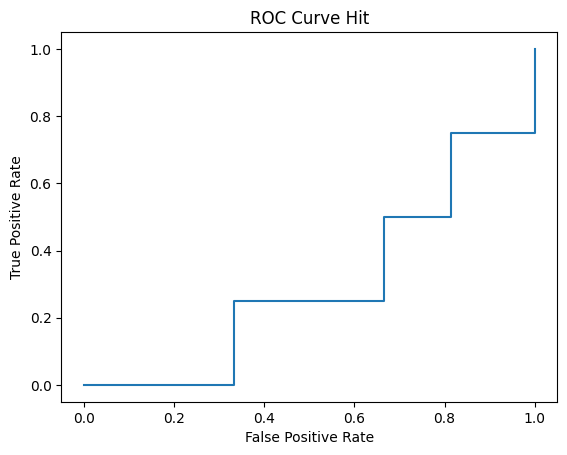

In [154]:
X_train, X_test, y_train, y_test = train_test_split(zero_alb_odds, zero_alb_hits, test_size=0.25, random_state=12312)
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[:, 1]
print(y_pred_proba)

y_pred_odds = []
for proba in y_pred_proba:
    y_pred_odds.append(calculate_american_odds(calculate_dec_odds(proba, 4)))

print(y_pred_proba)
print(y_pred_odds)
print(y_test)

for i in range(len(X_test)):
    if X_test[i][0] < 0:
        print(f"odds : {X_test[i]}")
        print(f"y_test : {y_test[i]}")

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Create the ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Hit')
plt.show()

odds : [-53.33246861425689, 8.048759715619134]
y_test : 0
odds : [15.195269934535043, 32.053994387653646]
y_test : 0
odds : [-149.44972381407374, -10.827241961598586]
y_test : 0
odds : [-8.211232344872984, 22.285708753946242]
y_test : 0
odds : [-363.4334612310097, -30.65054465892085]
y_test : 0
odds : [-11.105589723951793, 21.209911655471185]
y_test : 0
odds : [-34.61493047261168, 13.355253215252215]
y_test : 0
odds : [-462.7673908018458, -35.64995231063886]
y_test : 0
odds : [-20.14319220999139, 18.012939648580378]
y_test : 1
odds : [-37.15022992271101, 12.592111313855648]
y_test : 0
odds : [-216.41673325022887, -19.10507030438003]
y_test : 1
odds : [-18.409637237729246, 18.607886699654905]
y_test : 0
odds : [474.70031339713194, -145.58854440122073]
y_test : 0
odds : [-36.03402775814205, 12.926270342140004]
y_test : 1
odds : [12.69306214017005, 30.91016477247948]
y_test : 0
odds : [-92.2910484514747, -0.9851338434829259]
y_test : 0
odds : [-497.84960368689093, -37.086444356096344]
y_t

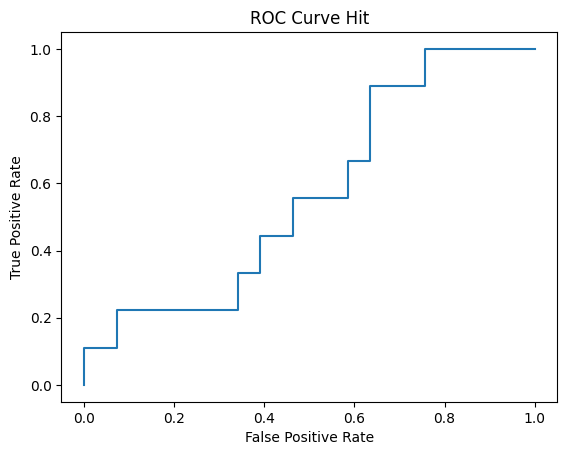

In [150]:
X_train, X_test, y_train, y_test = train_test_split(alba_odds, alba_hits, test_size=0.3, random_state=1)
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[:, 1]
# print(y_pred_proba)

y_pred_odds = []
for proba in y_pred_proba:
    y_pred_odds.append(calculate_american_odds(calculate_dec_odds(proba, 4)))

# print(y_pred_proba)
# print(y_pred_odds)
# print(y_test)

for i in range(len(X_test)):
    print(f"odds : {X_test[i]}")
    print(f"y_test : {y_test[i]}")

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Create the ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Hit')
plt.show()

[0.35394618 0.34754773 0.35887643 0.34754638 0.34673573 0.34734994
 0.34626899 0.34674163 0.34679746 0.34585222 0.34763067 0.34664742
 0.34733613 0.34773728 0.34590242 0.34693808 0.3468465  0.34674386
 0.34596029 0.3467508  0.34781384 0.35339447 0.3528322  0.34808726
 0.34721919 0.35873418 0.34585465 0.35935758 0.34759405 0.35743033
 0.34696008 0.34599099 0.3466328  0.34587059 0.35459186 0.33878281
 0.37471716 0.34662654 0.34779021 0.34687115 0.34679134 0.44884902
 0.34807912 0.34275138 0.34644974 0.34709283 0.34632625 0.34792519
 0.34752139 0.3462792  0.35954237 0.34713796 0.34641526 0.36021618
 0.34642439 0.34637828 0.34788629 0.3800307  0.34643642 0.34682832
 0.34655243 0.34747917 0.34801396 0.34761802 0.34641841 0.34646666
 0.34707473 0.2974362  0.34590089 0.34783495 0.34634589 0.34667704]
[0.35394618 0.34754773 0.35887643 0.34754638 0.34673573 0.34734994
 0.34626899 0.34674163 0.34679746 0.34585222 0.34763067 0.34664742
 0.34733613 0.34773728 0.34590242 0.34693808 0.3468465  0.346

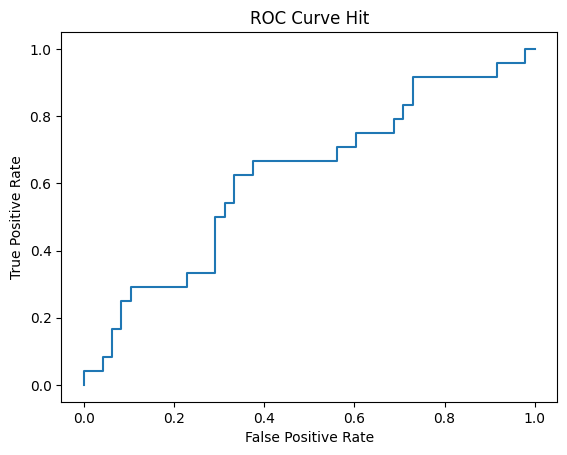

In [147]:
X_train, X_test, y_train, y_test = train_test_split(odds, hits, test_size=0.3, random_state=1)
log_regression = LogisticRegression()
log_regression.fit(X_train, y_train)

y_pred_proba = log_regression.predict_proba(X_test)[:, 1]
print(y_pred_proba)

y_pred_odds = []
for proba in y_pred_proba:
    y_pred_odds.append(calculate_american_odds(calculate_dec_odds(proba, 4)))

print(y_pred_proba)
print(y_pred_odds)
print(y_test)

for i in range(len(y_pred_odds)):
    if y_pred_odds[i] < 10:
        print(f"odds : {y_pred_odds[i]}")
        print(f"y_test : {y_test[i]}")

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)

# Create the ROC curve
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve Hit')
plt.show()